<a href="https://colab.research.google.com/github/FiyinfobaO/heart_disease_prediction/blob/main/heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HEART DISEASE PREDICTION USING ML

## ORIGINAL METADATA

Dataset used: [Kaggle data](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/data) referenced from [University of Carlifornia Irvine (UCI) Machine Learning Repository](https://archive.ics.uci.edu/dataset/45/heart+disease)

Column Descriptions (renamed a few for better understanding):
- id (Unique id for each patient)
- age (Age of the patient in years)
- dataset (place of study)
- sex (Male/Female)
- cp (chest pain type - typical angina, atypical angina, non-anginal, asymptomatic)
- trestbps (resting blood pressure in mm Hg on admission to the hospital)
- chol (serum cholesterol level in mg/dl)
- fbs (True, if fasting blood sugar > 120 mg/dl and False if not)
- restecg (resting electrocardiographic results - normal, stt abnormality, lv hypertrophy)
- thalach (maximum heart rate achieved)
- exang (exercise-induced angina - True/ False)
- oldpeak (ST depression induced by exercise relative to rest)
- slope (the slope of the peak exercise ST segment)
- ca: (number of major vessels (0-3) colored by fluoroscopy)
- thal (defect categories - normal; fixed defect; reversible defect)
- num (the predicted attribute/diagnosis of the heart disease. 0 = no heart disease; 1,2,3,4 = stages of heart disease)


#TOP (LIBRARIES INSTALLATION)

In [ ]:
!pip install chart_studio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.3 MB/s eta 0:00:00


In [ ]:
!pip install colab-env

  Preparing metadata (setup.py) ... done
  Created wheel for colab-env: filename=colab_env-0.2.0-py3-none-any.whl size=3805 sha256=79aa980a330f2eaa7e13ebb17db78c2f0f8e88b497d31f982c35b0d04615f4f5
  Stored in directory: /root/.cache/pip/wheels/ae/36/4f/466c2cd4db5d08f317893a920c4a0f58a81459ee3bdb136d35
Successfully built colab-env


In [ ]:
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import warnings
warnings.simplefilter(action='ignore')
from pprint import pprint
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import calendar
from time import time
from tqdm import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import chart_studio.plotly as py
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from scipy.stats import chi2_contingency, spearmanr, kendalltau, pearsonr
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier
import pickle
%matplotlib inline

In [ ]:
# define the database credentitals
username = os.environ.get('username')
api_key = os.environ.get('api_key')

In [ ]:
# to save plotly interactive charts
import chart_studio
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

## Helper functions - all functions are defined here!

In [ ]:
def count_plot(data, col, col2=None):
  """
  Plots a bar chart showing the number of patients in the category(col or col2).
  """
  if col2:
    # transform the data
    data = data.groupby([col, col2]).agg(count=(col,'count')).reset_index().sort_values('count', ascending=False)
    # plot the count
    fig = px.bar(data, x=col, y='count', category_orders={'diagnosis': ['Absent', 'Present']},
             text_auto='.2s', color=col2, barmode='group',
             labels=dict(
                 col=f'Heart Disease {col.capitalize}',
                 count='Patient Count')
             )
    fig.update_traces(textposition='outside')
    fig.show('svg')
  else:
    # transform the data
    data = data.groupby(col).agg(count=(col,'count')).reset_index().sort_values('count', ascending=False)
    # plot the count
    fig = px.bar(data, x=col, y='count', text_auto='.2s',
              labels=dict(
                  col=f'Heart Disease {col.capitalize}',
                  count='Patient Count')
              )
    fig.update_traces(textposition='outside')
    fig.show('svg')

def distribution_plot(data, col):
  "A kde distribution plot and box plot of the specified attribute in the data"
  plt.subplots(figsize=(36,12))
  plt.subplot(121)
  plot1 = sns.distplot(data[col])
  plot1.axes.set_title(f'{col.capitalize()} trend of the patients', fontsize=20)
  plot1.set_xlabel(col, fontsize=20)

  plt.subplot(122)
  sns.boxplot(data[col], orient='h')
  plt.show()

def get_best_estimator(*pipelines):
  """
  Using the best estimator_ would give the best model to call predictions with since refit is set to True by default.
  This is the equivalent of retraining a new model with the best_params_
  """
  scores = []
  for pipeline in pipelines:
    score = pipeline.best_score_
    scores.append(score)
  best_score_idx = np.argmax(scores)
  best_pipeline = pipelines[best_score_idx]
  best_estimator = best_pipeline.best_estimator_

  return best_pipeline, best_estimator

def evaluate(y_test, y_pred):
  "Function for model evaluation on test data"
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  print(f"\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1 Score: {f1:.4f}\nROC AUC: {roc_auc:.4f}\n")

def confusion_matrix_plot(y_test, y_pred, normalized=True, cmap='bone'):
  "Plot the confusion matric showing TP, TN, FP, and FN"
  cm = confusion_matrix(y_test, y_pred)
  if normalized:
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    norm_cm = (cm.astype('float')/ cm.sum(axis= 1)[:, np.newaxis])
    sns.heatmap(norm_cm, annot=cm, cmap='Blues', fmt='g', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
  else:
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
def detect_outliers(data, col):
    """
    Function to detect the presence of outliers in a column.
    """
    print(f'\n///////////// {col} column /////////////\n')
    # 1st quartile 25%
    Q1 = data[col].quantile(0.25)
    # 3rd quartile 75%
    Q3 = data[col].quantile(0.75)

    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Q1 is {Q1} while Q3 is {Q3}")
    print(f"IQR is {IQR}")
    print(f"The Lower limit is {lower_bound} while the Upper limit is {upper_bound}")

    # Check if the Probability Distribution Function(PDF) is a Gaussian Distribution
    plt.figure(figsize=(7,4))
    sns.displot(data[col], kind='kde')#.set_title(f'Distribution of {col}')
    plt.show()
    print('\n')
    plt.figure(figsize=(7,4))
    sns.boxplot(data[col])
    plt.show()

    # Return the detected Outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print('\nNo outliers!') if outliers.empty else print(outliers)

def predict(patients_features, model, train_data):
  """Function to diagnose a patient based on information gotten from them"""

  # preprocessing the patients features to the format the model expects
  patients_features = [patients_features]
  df_features = pd.DataFrame(patients_features, columns=train_data.columns.tolist())
  pred = model.predict(df_features)[0]
  if pred == 0:
    print("Patient does not have heart disease")
  else:
    print("Patient has heart disease")

In [ ]:
def hyperparam_tuner_acc(preprocess_pipeline, X_train, y_train):
  """
  Hyper param search that focuses on accuracy as the evaluation metric.
  """
  # initialize the pipeline with any estimator you like
  pipe = Pipeline(steps=[
      ('preprocessor', preprocess_pipeline),
      ('estimator', RandomForestClassifier())
    ])

  # Add a dict of estimator and estimator related parameters in this list
  # we prefix each estimators parameter with "estimator__" since we named the estimator, estimator in the pipeline steps
  params_grid = [{
                  'estimator': [RandomForestClassifier()],
                  'estimator__criterion': ['gini', 'entropy', 'log_loss'],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 1000],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                 {
                  'estimator': [XGBClassifier()],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__objective': ['binary:logistic', 'binary:logitraw', 'multi:softmax', 'multi:softprob'],
                  'estimator__min_child_weight': [1, 5, 10],
                  'estimator__gamma': [0.5, 1, 1.5, 2, 5],
                  'estimator__subsample': [0.6, 0.8, 1.0],
                  'estimator__colsample_bytree': [0.6, 0.8, 1.0],
                  'estimator__max_depth': [1, 2, 3, 4, 5],
                 },
                {
                  'estimator': [GradientBoostingClassifier()],
                  'estimator__criterion': ['friedman_mse', 'squared_error'],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                {
                  'estimator': [DecisionTreeClassifier()],
                  'estimator__criterion': ['gini', 'entropy', 'log_loss'],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                {
                  'estimator':[SVC()],
                  'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'estimator__gamma': ['scale', 'auto', 0.001, 0.0001],
                  },
                {
                  'estimator':[LogisticRegression()],
                  'estimator__penalty': [{
                                          'l1': {'estimator__solver': ['liblinear', 'saga']},
                                          'l2': {'estimator__solver': ['lbfgs', 'liblinear', 'netwon-cg', 'newton-cholesky', 'sag', 'saga']},
                                          'elasticnet': {'estimator__solver': ['saga']}
                                        }],
                  'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'estimator__max_iter': [50, 100, 150, 200, 400],
                  'estimator__multi_class': ['ovr', 'multinomial', 'auto'],
                  },
                {
                  'estimator': [AdaBoostClassifier()],
                  'estimator__estimator': [DecisionTreeClassifier(), XGBClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), LGBMClassifier()],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__algorithm': ['SAMME', 'SAMME.R'],
                  },
                ]

  rand_grid = RandomizedSearchCV(pipe, params_grid, cv=2, n_jobs=-1, verbose=2, n_iter=100, random_state=42)
  rs = rand_grid.fit(X_train, y_train)

  # Results from Randomized Search
  print("\n========================================================")
  print(" Results from Randomized Search " )
  print("========================================================")

  print("\n The best estimator across ALL searched params:\n",
            rs.best_estimator_)

  print("\n The best score across ALL searched params:\n",
            rs.best_score_)

  print("\n The best parameters across ALL searched params:\n",
            rs.best_params_)

  return rs

In [ ]:
def hyperparam_tuner_f1(preprocess_pipeline, X_train, y_train):
  """
  Hyper param search that focuses on f1 score as the evaluation metric.
  """
  # initialize the pipeline with any estimator you like
  pipe = Pipeline(steps=[
      ('preprocessor', preprocess_pipeline),
      ('estimator', RandomForestClassifier())
    ])

  # Add a dict of estimator and estimator related parameters in this list
  # we prefix each estimators parameter with "estimator__" since we named the estimator, estimator in the pipeline steps
  params_grid = [{
                  'estimator': [RandomForestClassifier()],
                  'estimator__criterion': ['gini', 'entropy', 'log_loss'],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 1000],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                 {
                  'estimator': [XGBClassifier()],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__objective': ['binary:logistic', 'binary:logitraw', 'multi:softmax', 'multi:softprob'],
                  'estimator__min_child_weight': [1, 5, 10],
                  'estimator__gamma': [0.5, 1, 1.5, 2, 5],
                  'estimator__subsample': [0.6, 0.8, 1.0],
                  'estimator__colsample_bytree': [0.6, 0.8, 1.0],
                  'estimator__max_depth': [1, 2, 3, 4, 5],
                 },
                {
                  'estimator': [GradientBoostingClassifier()],
                  'estimator__criterion': ['friedman_mse', 'squared_error'],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                {
                  'estimator': [DecisionTreeClassifier()],
                  'estimator__criterion': ['gini', 'entropy', 'log_loss'],
                  'estimator__min_samples_split': [2, 3, 5, 7, 9, 13],
                  'estimator__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12],
                  'estimator__max_depth': [1,2,3,4,5],
                  'estimator__max_features': [None, "sqrt", "log2"],
                  },
                {
                  'estimator':[SVC()],
                  'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                  'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'estimator__gamma': ['scale', 'auto', 0.001, 0.0001],
                  },
                {
                  'estimator':[LogisticRegression()],
                  'estimator__penalty': [{
                                          'l1': {'estimator__solver': ['liblinear', 'saga']},
                                          'l2': {'estimator__solver': ['lbfgs', 'liblinear', 'netwon-cg', 'newton-cholesky', 'sag', 'saga']},
                                          'elasticnet': {'estimator__solver': ['saga']}
                                        }],
                  'estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                  'estimator__max_iter': [50, 100, 150, 200, 400],
                  'estimator__multi_class': ['ovr', 'multinomial', 'auto'],
                  },
                {
                  'estimator': [AdaBoostClassifier()],
                  'estimator__estimator': [DecisionTreeClassifier(), XGBClassifier(), GradientBoostingClassifier(), RandomForestClassifier(), ExtraTreesClassifier(), LGBMClassifier()],
                  'estimator__n_estimators': [10, 50, 100, 250, 400, 600, 1000],
                  'estimator__learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                  'estimator__algorithm': ['SAMME', 'SAMME.R'],
                  },
                ]

  rand_grid = RandomizedSearchCV(pipe, params_grid, cv=2, n_jobs=-1, verbose=2, n_iter=100, random_state=42, scoring='f1')
  rs = rand_grid.fit(X_train, y_train)

  # Results from Randomized Search
  print("\n========================================================")
  print(" Results from Randomized Search " )
  print("========================================================")

  print("\n The best estimator across ALL searched params:\n",
            rs.best_estimator_)

  print("\n The best score across ALL searched params:\n",
            rs.best_score_)

  print("\n The best parameters across ALL searched params:\n",
            rs.best_params_)

  return rs

##Load data

In [ ]:
! cp '/content/drive/MyDrive/medtronic/heart_disease_uci.csv' '/content/'

In [ ]:
df = pd.read_csv('heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df.describe(include='all')

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920,920,920,861.000000,890.000000,830,918,865.000000,865,858.000000,611,309.000000,434,920.000000
unique,NaN,NaN,2,4,4,NaN,NaN,2,3,NaN,2,NaN,3,NaN,3,NaN
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,normal,NaN
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,196,NaN
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN,0.995652
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN,1.142693
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN,0.000000
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN,1.000000
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN,2.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [ ]:
# 4 datasets from the UCI repo that show the place where the data study was carried out
df.dataset.value_counts()

Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: dataset, dtype: int64

In [ ]:
df[df.dataset=='Cleveland'].isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       1
ca          5
thal        3
num         0
dtype: int64

In [ ]:
df[df.dataset=='Hungary'].isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalch        1
exang         1
oldpeak       0
slope       189
ca          290
thal        265
num           0
dtype: int64

In [ ]:
df[df.dataset=='VA Long Beach'].isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     56
chol          7
fbs           7
restecg       0
thalch       53
exang        53
oldpeak      56
slope       102
ca          198
thal        166
num           0
dtype: int64

In [ ]:
df[df.dataset=='Switzerland'].isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps      2
chol          0
fbs          75
restecg       1
thalch        1
exang         1
oldpeak       6
slope        17
ca          118
thal         52
num           0
dtype: int64

We will focus on the Cleveland dataset since it contains the least number of null values to worry about, and we can get the most number of datapoints to work with.

In [ ]:
df_new = df[df.dataset=='Cleveland']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        304 non-null    int64  
 1   age       304 non-null    int64  
 2   sex       304 non-null    object 
 3   dataset   304 non-null    object 
 4   cp        304 non-null    object 
 5   trestbps  304 non-null    float64
 6   chol      304 non-null    float64
 7   fbs       304 non-null    object 
 8   restecg   304 non-null    object 
 9   thalch    304 non-null    float64
 10  exang     304 non-null    object 
 11  oldpeak   304 non-null    float64
 12  slope     303 non-null    object 
 13  ca        299 non-null    float64
 14  thal      301 non-null    object 
 15  num       304 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 40.4+ KB


##Data Preprocessing

###fix column names - new metadata

We want to make some of the column names easier to understand so we will rename the following:
- cp ==> cp_type (chest pain type - typical angina, atypical angina, non-anginal, asymptomatic)
- trestbps ==> r_bp (resting blood pressure in mm Hg on admission to the hospital)
- fbs ==> is_diabetic (1, if fasting blood sugar > 120 mg/dl and 0 if not. [Source](https://www.sutterhealth.org/ask-an-expert/answers/elevated-blood-sugar-levels-diabetes#:~:text=Answer%3A,sugar%20over%20200%2C%20is%20diabetic.))
- restecg ==> r_ecg (resting electrocardiographic results - normal, stt abnormality, lv hypertrophy)
- thalach ==> max_heart_rate (maximum heart rate achieved)
- oldpeak ==> st_depression (ST depression induced by exercise relative to rest)
- ca ==> no_of_vessels (number of major vessels (0-3) colored by fluoroscopy)
- thal ==> thallium (defect categories - normal; fixed defect; reversible defect)
- num ==> diagnosis (the predicted attribute/diagnosis of the heart disease - 0=no heart disease; 1,2,3,4 = stages of heart disease)

In [ ]:
df_new.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [ ]:
df_new.rename(columns={
    'cp': 'cp_type',
    'trestbps':'r_bp',
    'fbs': 'is_diabetic',
    'restecg': 'r_ecg',
    'thalch': 'max_heart_rate',
    'oldpeak': 'st_depression',
    'ca': 'no_of_vessels',
    'thal': 'thallium',
    'num': 'diagnosis'}, inplace=True)

In [ ]:
df_new.head()

,id,age,sex,dataset,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              304 non-null    int64  
 1   age             304 non-null    int64  
 2   sex             304 non-null    object 
 3   dataset         304 non-null    object 
 4   cp_type         304 non-null    object 
 5   r_bp            304 non-null    float64
 6   chol            304 non-null    float64
 7   is_diabetic     304 non-null    object 
 8   r_ecg           304 non-null    object 
 9   max_heart_rate  304 non-null    float64
 10  exang           304 non-null    object 
 11  st_depression   304 non-null    float64
 12  slope           303 non-null    object 
 13  no_of_vessels   299 non-null    float64
 14  thallium        301 non-null    object 
 15  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 40.4+ KB


### Remove useless columns

In [ ]:
# id not needed in analysis, and dataset contains only cleveland data
df_new.drop(['id', 'dataset'], axis=1, inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   299 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


### Handle null values


In [ ]:
# check for null values from each feature
df_new.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             1
no_of_vessels     5
thallium          3
diagnosis         0
dtype: int64

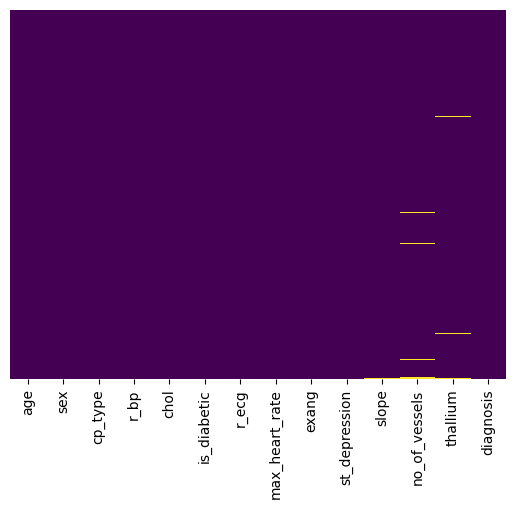

In [ ]:
# plt.figure(figsize=(15,6))
sns.heatmap(df_new.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

#### Method 1: manual multivariate/univariate

Filling manually based on ituition from observation with other records for the column and other columns

In [ ]:
# new copy to store method 1 implementation
df_new1 = df_new.copy()

##### no_of_vessels

In [ ]:
# checking null values in no_of_vessels
df_new1[df_new1.no_of_vessels.isnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
166,52,Male,non-anginal,138.0,223.0,False,normal,169.0,False,0.0,upsloping,NaN,normal,0
192,43,Male,asymptomatic,132.0,247.0,True,lv hypertrophy,143.0,True,0.1,flat,NaN,reversable defect,1
287,58,Male,atypical angina,125.0,220.0,False,normal,144.0,False,0.4,flat,NaN,reversable defect,0
302,38,Male,non-anginal,138.0,175.0,False,normal,173.0,False,0.0,upsloping,NaN,normal,0
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0,NaN,NaN,NaN,0


In [ ]:
df_new1[df_new1.no_of_vessels.isnull()].describe(include='all')

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
count,5.00000,5,5,5.000000,5.000000,5,5,5.000000,5,5.000000,4,0.0,4,5.000000
unique,NaN,1,3,NaN,NaN,2,2,NaN,2,NaN,2,NaN,2,NaN
top,NaN,Male,non-anginal,NaN,NaN,False,normal,NaN,False,NaN,upsloping,NaN,normal,NaN
freq,NaN,5,2,NaN,NaN,4,3,NaN,4,NaN,2,NaN,2,NaN
mean,43.80000,NaN,NaN,132.600000,199.400000,NaN,NaN,162.800000,NaN,0.100000,NaN,NaN,NaN,0.200000
std,11.75585,NaN,NaN,5.549775,45.785369,NaN,NaN,18.579559,NaN,0.173205,NaN,NaN,NaN,0.447214
min,28.00000,NaN,NaN,125.000000,132.000000,NaN,NaN,143.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
25%,38.00000,NaN,NaN,130.000000,175.000000,NaN,NaN,144.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
50%,43.00000,NaN,NaN,132.000000,220.000000,NaN,NaN,169.000000,NaN,0.000000,NaN,NaN,NaN,0.000000
75%,52.00000,NaN,NaN,138.000000,223.000000,NaN,NaN,173.000000,NaN,0.100000,NaN,NaN,NaN,0.000000


In [ ]:
df_new1[df_new1.no_of_vessels.isnull()]['sex'].value_counts()

Male    5
Name: sex, dtype: int64

- Sex is the only column with a single unique value

Lets look into the male sex

In [ ]:
# looking into the male sex
df_new1[df_new1.no_of_vessels.notnull()].query('sex=="Male"')['no_of_vessels'].value_counts()

0.0    111
1.0     50
2.0     25
3.0     16
Name: no_of_vessels, dtype: int64

In [ ]:
# looking into the male sex
df_new1[df_new1.sex=='Male']['no_of_vessels'].value_counts()

0.0    111
1.0     50
2.0     25
3.0     16
Name: no_of_vessels, dtype: int64

majority of males have 0 as their no of vessels

In [ ]:
# looking into the non-null values for no_of_vessels to see the most frequently used vessel number
df_new1[df_new1.no_of_vessels.notnull()]['no_of_vessels'].describe(include='all')

count    299.000000
mean       0.672241
std        0.937438
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
Name: no_of_vessels, dtype: float64

In [ ]:
df_new1[df_new1.no_of_vessels.notnull()]['no_of_vessels'].mode()

0    0.0
Name: no_of_vessels, dtype: float64

In [ ]:
df_new1.no_of_vessels.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: no_of_vessels, dtype: int64

###### Imputed
majority of the no_of_vessels that are not null have 0 vessels

In [ ]:
# imputing with 0 since it occurs the most
df_new1.no_of_vessels.fillna(0.0, inplace=True)
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new1.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             1
no_of_vessels     0
thallium          3
diagnosis         0
dtype: int64

##### thallium

In [ ]:
# checking null values in no_of_vessels
df_new1[df_new1.thallium.isnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
87,53,Female,non-anginal,128.0,216.0,False,lv hypertrophy,115.0,False,0.0,upsloping,0.0,NaN,0
266,52,Male,asymptomatic,128.0,204.0,True,normal,156.0,True,1.0,flat,0.0,NaN,2
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0,NaN,0.0,NaN,0


In [ ]:
df_new1[df_new1.thallium.isnull()].describe(include='all')

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
count,3.000000,3,3,3.000000,3.000000,3,3,3.000000,3,3.000000,2,3.0,0,3.000000
unique,NaN,2,3,NaN,NaN,2,2,NaN,2,NaN,2,NaN,0,NaN
top,NaN,Male,non-anginal,NaN,NaN,False,lv hypertrophy,NaN,False,NaN,upsloping,NaN,NaN,NaN
freq,NaN,2,1,NaN,NaN,2,2,NaN,2,NaN,1,NaN,NaN,NaN
mean,44.333333,NaN,NaN,128.666667,184.000000,NaN,NaN,152.000000,NaN,0.333333,NaN,0.0,NaN,0.666667
std,14.153916,NaN,NaN,1.154701,45.431267,NaN,NaN,35.171011,NaN,0.577350,NaN,0.0,NaN,1.154701
min,28.000000,NaN,NaN,128.000000,132.000000,NaN,NaN,115.000000,NaN,0.000000,NaN,0.0,NaN,0.000000
25%,40.000000,NaN,NaN,128.000000,168.000000,NaN,NaN,135.500000,NaN,0.000000,NaN,0.0,NaN,0.000000
50%,52.000000,NaN,NaN,128.000000,204.000000,NaN,NaN,156.000000,NaN,0.000000,NaN,0.0,NaN,0.000000
75%,52.500000,NaN,NaN,129.000000,210.000000,NaN,NaN,170.500000,NaN,0.500000,NaN,0.0,NaN,1.000000


There is no feature with a unique value across all the null thallium patients so let's look univariately at the non-null records for only the thallium feature, to find the most frequently used value

In [ ]:
# looking into the non-null values for thallium to see the most frequently used thalium number
df_new1[df_new1.thallium.notnull()]['thallium'].describe(include='all')

count        301
unique         3
top       normal
freq         166
Name: thallium, dtype: object

In [ ]:
df_new1[df_new1.thallium.notnull()]['thallium'].mode()

0    normal
Name: thallium, dtype: object

In [ ]:
df_new1.thallium.value_counts()

normal               166
reversable defect    117
fixed defect          18
Name: thallium, dtype: int64

###### Imputed
majority of the thallium that are not null are normal

In [ ]:
# imputing with 0 since it occurs the most
df_new1.thallium.fillna('normal', inplace=True)
df_new1.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             1
no_of_vessels     0
thallium          0
diagnosis         0
dtype: int64

##### slope

In [ ]:
# checking null values in no_of_vessels
df_new1[df_new1.slope.isnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0,NaN,0.0,normal,0


In [ ]:
df_new1[df_new1.slope.isnull()].describe(include='all')

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
count,1.0,1,1,1.0,1.0,1,1,1.0,1,1.0,0,1.0,1,1.0
unique,NaN,1,1,NaN,NaN,1,1,NaN,1,NaN,0,NaN,1,NaN
top,NaN,Male,atypical angina,NaN,NaN,False,lv hypertrophy,NaN,False,NaN,NaN,NaN,normal,NaN
freq,NaN,1,1,NaN,NaN,1,1,NaN,1,NaN,NaN,NaN,1,NaN
mean,28.0,NaN,NaN,130.0,132.0,NaN,NaN,185.0,NaN,0.0,NaN,0.0,NaN,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,28.0,NaN,NaN,130.0,132.0,NaN,NaN,185.0,NaN,0.0,NaN,0.0,NaN,0.0
25%,28.0,NaN,NaN,130.0,132.0,NaN,NaN,185.0,NaN,0.0,NaN,0.0,NaN,0.0
50%,28.0,NaN,NaN,130.0,132.0,NaN,NaN,185.0,NaN,0.0,NaN,0.0,NaN,0.0
75%,28.0,NaN,NaN,130.0,132.0,NaN,NaN,185.0,NaN,0.0,NaN,0.0,NaN,0.0


In [ ]:
# looking into the non-null values for thallium to see the most frequently used thalium number
df_new1[df_new1.slope.notnull()]['slope'].describe(include='all')

count           303
unique            3
top       upsloping
freq            142
Name: slope, dtype: object

In [ ]:
df_new1[df_new1.slope.notnull()]['slope'].mode()

0    upsloping
Name: slope, dtype: object

In [ ]:
df_new1.slope.value_counts()

upsloping      142
flat           140
downsloping     21
Name: slope, dtype: int64

In [ ]:
df_new1[df_new1.slope=='flat'].describe(include='all')

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
count,140.000000,140,140,140.000000,140.000000,140,140,140.000000,140,140.000000,140,140.000000,140,140.000000
unique,NaN,2,4,NaN,NaN,2,3,NaN,2,NaN,1,NaN,3,NaN
top,NaN,Male,asymptomatic,NaN,NaN,False,lv hypertrophy,NaN,False,NaN,flat,NaN,reversable defect,NaN
freq,NaN,95,84,NaN,NaN,121,76,NaN,76,NaN,140,NaN,70,NaN
mean,56.100000,NaN,NaN,132.100000,249.121429,NaN,NaN,139.292857,NaN,1.428571,NaN,0.828571,NaN,1.392857
std,8.437071,NaN,NaN,17.420033,55.270488,NaN,NaN,22.226919,NaN,1.041049,NaN,1.003181,NaN,1.312346
min,35.000000,NaN,NaN,100.000000,131.000000,NaN,NaN,71.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
25%,50.750000,NaN,NaN,120.000000,213.750000,NaN,NaN,124.750000,NaN,0.600000,NaN,0.000000,NaN,0.000000
50%,57.000000,NaN,NaN,130.000000,243.000000,NaN,NaN,142.000000,NaN,1.200000,NaN,0.000000,NaN,1.000000
75%,62.000000,NaN,NaN,140.000000,276.500000,NaN,NaN,154.250000,NaN,2.000000,NaN,1.000000,NaN,2.000000


In [ ]:
df_new1[df_new1.slope=='upsloping'].describe(include='all')

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
count,142.000000,142,142,142.000000,142.000000,142,142,142.000000,142,142.000000,142,142.000000,142,142.000000
unique,NaN,2,4,NaN,NaN,2,2,NaN,2,NaN,1,NaN,3,NaN
top,NaN,Male,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,upsloping,NaN,normal,NaN
freq,NaN,95,49,NaN,NaN,122,82,NaN,116,NaN,142,NaN,103,NaN
mean,52.661972,NaN,NaN,130.133803,245.633803,NaN,NaN,160.471831,NaN,0.408451,NaN,0.514085,NaN,0.408451
std,9.431265,NaN,NaN,16.743890,49.005497,NaN,NaN,17.748317,NaN,0.684322,NaN,0.822864,NaN,0.826468
min,29.000000,NaN,NaN,94.000000,126.000000,NaN,NaN,96.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
25%,45.000000,NaN,NaN,120.000000,209.250000,NaN,NaN,152.250000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,52.500000,NaN,NaN,130.000000,239.000000,NaN,NaN,162.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
75%,59.000000,NaN,NaN,140.000000,274.500000,NaN,NaN,172.000000,NaN,0.775000,NaN,1.000000,NaN,0.750000


###### Imputed
From the unique characteristics of the patient with the null slope and the upsloping characteristics of majority of the patients (thallium, resting bp, cholesterol, st depression and diagnosis), we will fill the ***upsloping***

In [ ]:
# imputing with 0 since it occurs the most
df_new1.slope.fillna('upsloping', inplace=True)
df_new1.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             0
no_of_vessels     0
thallium          0
diagnosis         0
dtype: int64

In [ ]:
df_new1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           304 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


#### Method 1b: alternative univariate

In [ ]:
# new copy to store method 1 implementation
df_new1b = df_new.copy()

##### no_of_vessels

Looking into the most frequently used vessel number for the non-null values of the no_of_vessels column

In [ ]:
# looking into the non-null values for no_of_vessels to see the most frequently used vessel number
df_new1b[df_new1b.no_of_vessels.notnull()]['no_of_vessels'].mode()

0    0.0
Name: no_of_vessels, dtype: float64

In [ ]:
df_new1b.no_of_vessels.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: no_of_vessels, dtype: int64

majority of the no_of_vessels that are not null have 0 vessels

In [ ]:
df_new1b.no_of_vessels.mode()[0]

0.0

###### Imputed

In [ ]:
# imputing with 0 since it occurs the most
df_new1b.no_of_vessels.fillna(df_new1b.no_of_vessels.mode()[0], inplace=True)
df_new1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new1b.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             1
no_of_vessels     0
thallium          3
diagnosis         0
dtype: int64

##### thallium

In [ ]:
# looking into the non-null values for thallium to see the most frequently used thalium number
df_new1b[df_new1b.thallium.notnull()]['thallium'].describe(include='all')

count        301
unique         3
top       normal
freq         166
Name: thallium, dtype: object

In [ ]:
df_new1b[df_new1b.thallium.notnull()]['thallium'].mode()

0    normal
Name: thallium, dtype: object

In [ ]:
df_new1b.thallium.value_counts()

normal               166
reversable defect    117
fixed defect          18
Name: thallium, dtype: int64

###### Imputed
Majority of the thallium that are not null are normal but there is a good mix of normal and reversable defect and arguably missing values cannot be filled with any of them. We could create a new category by assigning the value 'missing' to all the missing values in that column.

In [ ]:
# imputing with 0 since it occurs the most
df_new1b.thallium.fillna('missing', inplace=True)
df_new1b.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             1
no_of_vessels     0
thallium          0
diagnosis         0
dtype: int64

##### slope

In [ ]:
# looking into the non-null values for thallium to see the most frequently used thalium number
df_new1b[df_new1b.slope.notnull()]['slope'].describe(include='all')

count           303
unique            3
top       upsloping
freq            142
Name: slope, dtype: object

In [ ]:
df_new1b[df_new1b.slope.notnull()]['slope'].mode()

0    upsloping
Name: slope, dtype: object

In [ ]:
df_new1b.slope.value_counts()

upsloping      142
flat           140
downsloping     21
Name: slope, dtype: int64

###### Imputed
Although the most frequent slope value is ***upsloping***, there is a good mix of ***upsloping*** and ***flat***: 142 vs 140, and arguably missing values cannot be filled with any of them. We could create a new category by assigning the value 'missing' to all the missing values in that column.

In [ ]:
# imputing with 0 since it occurs the most
df_new1b.slope.fillna('missing', inplace=True)
df_new1b.isnull().sum()

age               0
sex               0
cp_type           0
r_bp              0
chol              0
is_diabetic       0
r_ecg             0
max_heart_rate    0
exang             0
st_depression     0
slope             0
no_of_vessels     0
thallium          0
diagnosis         0
dtype: int64

In [ ]:
df_new1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           304 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


#### Method 2: removing all values completely

In [ ]:
# new copy to store method 2 implementation
df_new2 = df_new.copy()

In [ ]:
df_new2.dropna(inplace=True)
df_new2.isnull().sum().all()

False

In [ ]:
df_new2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             297 non-null    int64  
 1   sex             297 non-null    object 
 2   cp_type         297 non-null    object 
 3   r_bp            297 non-null    float64
 4   chol            297 non-null    float64
 5   is_diabetic     297 non-null    object 
 6   r_ecg           297 non-null    object 
 7   max_heart_rate  297 non-null    float64
 8   exang           297 non-null    object 
 9   st_depression   297 non-null    float64
 10  slope           297 non-null    object 
 11  no_of_vessels   297 non-null    float64
 12  thallium        297 non-null    object 
 13  diagnosis       297 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 34.8+ KB


#### Visualize distribution of imputed values so far

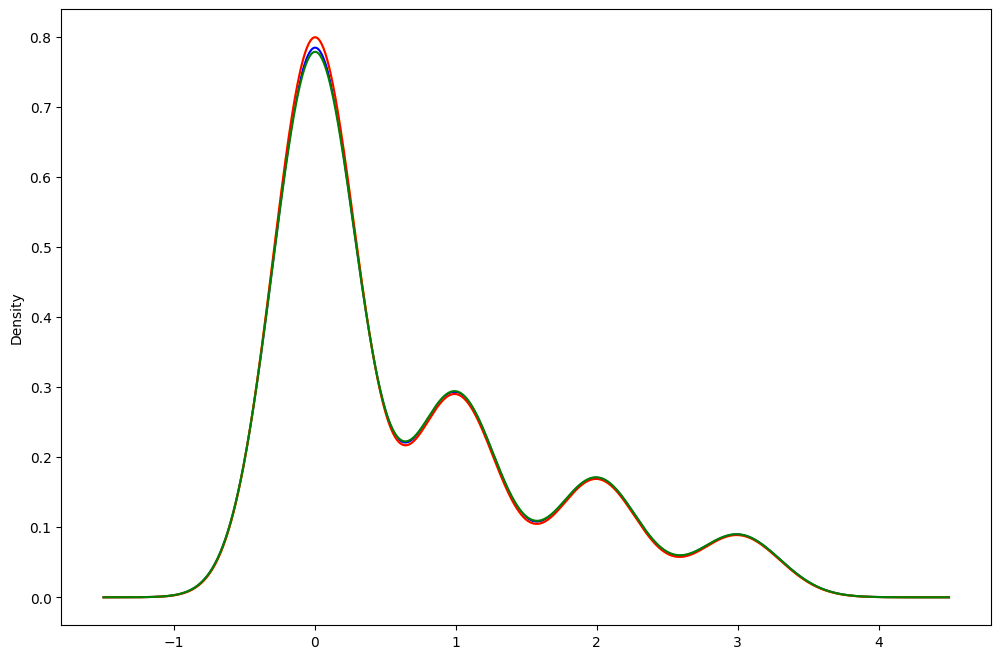

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

df_new.no_of_vessels.plot(kind='kde',color='blue')
df_new1.no_of_vessels.plot(kind='kde',color='yellow')
df_new1b.no_of_vessels.plot(kind='kde',color='red')
df_new2.no_of_vessels.plot(kind='kde',color='green')
plt.show()

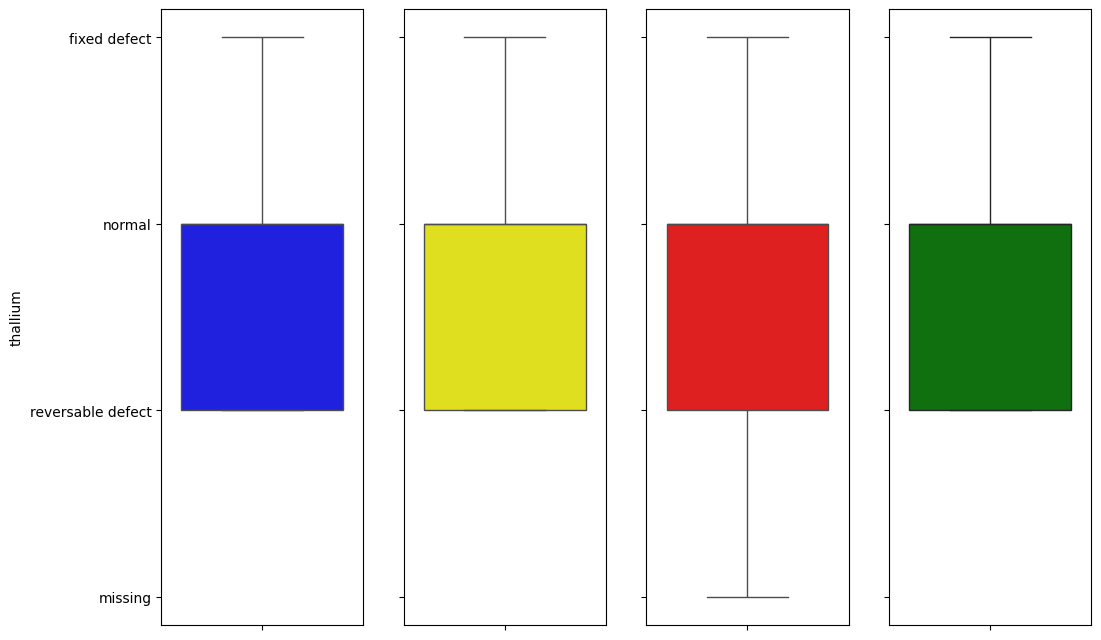

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(12,8), sharey=True)
sns.boxplot(y=df_new.thallium, ax=ax[0], color='blue')
sns.boxplot(y=df_new1.thallium, ax=ax[1], color='yellow')
sns.boxplot(y=df_new1b.thallium, ax=ax[2], color='red')
sns.boxplot(y=df_new2.thallium, ax=ax[3], color='green')
plt.show()

#### Method 3: multivariate using ML algo

Filling using an algorithm to predict the null values.

The idea:
Build 3 separate models to predict each of the 3 variables with Null values

For each model,
- training data is data from the remaining features without null values (0-9)
- testing data is data for all records with missing values
- split train to train and val so you ca validate models performance before making final prediction on test

Since each feature with missing value

In [ ]:
# new copy to store method 3 implementation
df_new3 = df_new.copy()

In [ ]:
df_new3.head()

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   299 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new3.diagnosis.value_counts()

0    165
1     55
2     36
3     35
4     13
Name: diagnosis, dtype: int64

##### no_of_vessels

- exploring features
  - Train: all non-null values of no of vessels excluding the diagnosis, slope, thallium and no_of_vessels columns
  - Test: all null values of no of vessels xcluding the diagnosis, slope, thallium and no_of_vessels columns
- slope and thallium are removed because they also contain null values
- diagnosis is removed since this is our original target for this analysis

In [ ]:
df_new3[df_new3.no_of_vessels.notnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,Female,asymptomatic,140.0,241.0,False,normal,123.0,True,0.2,flat,0.0,reversable defect,1
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2,flat,0.0,reversable defect,1
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4,flat,2.0,reversable defect,2
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2,flat,1.0,reversable defect,3


In [ ]:
df_new3[df_new3.no_of_vessels.notnull()].drop(['diagnosis', 'slope', 'thallium', 'no_of_vessels'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4
...,...,...,...,...,...,...,...,...,...,...
297,57,Female,asymptomatic,140.0,241.0,False,normal,123.0,True,0.2
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2


In [ ]:
df_new3[df_new3.no_of_vessels.isnull()].drop(['diagnosis', 'slope', 'thallium', 'no_of_vessels'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression
166,52,Male,non-anginal,138.0,223.0,False,normal,169.0,False,0.0
192,43,Male,asymptomatic,132.0,247.0,True,lv hypertrophy,143.0,True,0.1
287,58,Male,atypical angina,125.0,220.0,False,normal,144.0,False,0.4
302,38,Male,non-anginal,138.0,175.0,False,normal,173.0,False,0.0
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0


In [ ]:
X_train = df_new3[df_new3.no_of_vessels.notnull()].drop(['diagnosis', 'slope', 'thallium', 'no_of_vessels'], axis=1)
X_test = df_new3[df_new3.no_of_vessels.isnull()].drop(['diagnosis', 'slope', 'thallium', 'no_of_vessels'], axis=1)

- exploring target
  - Train: all non-null values of no of vessels column
  - Test: all null values of no of vessels column

In [ ]:
df_new3[df_new3.no_of_vessels.notnull()]['no_of_vessels']

0      0.0
1      3.0
2      2.0
3      0.0
4      0.0
      ... 
297    0.0
298    0.0
299    2.0
300    1.0
301    1.0
Name: no_of_vessels, Length: 299, dtype: float64

In [ ]:
df_new3[df_new3.no_of_vessels.isnull()]['no_of_vessels']

166   NaN
192   NaN
287   NaN
302   NaN
303   NaN
Name: no_of_vessels, dtype: float64

In [ ]:
y_train = df_new3[df_new3.no_of_vessels.notnull()]['no_of_vessels']
y_test = df_new3[df_new3.no_of_vessels.isnull()]['no_of_vessels']

###### encoding/scaling

Apply one-hot encoding to all categorical variables since none of them have a specific order/rank

In [ ]:
cat_cols  = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['sex', 'cp_type', 'is_diabetic', 'r_ecg', 'exang']

In [ ]:
cat_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(cat_transformer.fit_transform(X_train).shape)
cat_transformer.fit_transform(X_train)[:10]

(299, 13)


array([[  1. ,   0. ,   0. ,   1. ,   1. ,   0. ,   0. ,   0. ,  63. ,
        145. , 233. , 150. ,   2.3],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,  67. ,
        160. , 286. , 108. ,   1.5],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,  67. ,
        120. , 229. , 129. ,   2.6],
       [  1. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,  37. ,
        130. , 250. , 187. ,   3.5],
       [  0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  41. ,
        130. , 204. , 172. ,   1.4],
       [  1. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,  56. ,
        120. , 236. , 178. ,   0.8],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  62. ,
        140. , 268. , 160. ,   3.6],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   1. ,  57. ,
        120. , 354. , 163. ,   0.6],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  63. ,
        130. , 254. , 147. ,   1.4],
       [  1. ,   0. ,   0. ,

In [ ]:
preprocess_pipeline_std = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', StandardScaler())
])
# viewing the effect of the one hot encoding and scaling to mean of 0 and std of 1
print(preprocess_pipeline_std.fit_transform(X_train).shape)
preprocess_pipeline_std.fit_transform(X_train)[:10]

(299, 13)


array([[ 0.69296322, -0.44271887, -0.62505814,  3.46410162,  2.40737503,
        -0.99001639, -0.1164445 , -0.69825654,  0.94067407,  0.75419084,
        -0.27206074,  0.02159942,  1.07427684],
       [ 0.69296322, -0.44271887, -0.62505814, -0.28867513, -0.4153902 ,
        -0.99001639, -0.1164445 ,  1.4321384 ,  1.38482969,  1.60279745,
         0.75055465, -1.8111405 ,  0.38572641],
       [ 0.69296322, -0.44271887, -0.62505814, -0.28867513, -0.4153902 ,
        -0.99001639, -0.1164445 ,  1.4321384 ,  1.38482969, -0.6601535 ,
        -0.34923926, -0.89477054,  1.33248325],
       [ 0.69296322, -0.44271887,  1.59985118, -0.28867513, -0.4153902 ,
         1.01008429, -0.1164445 , -0.69825654, -1.94633746, -0.09441576,
         0.05594797,  1.63615602,  2.10710247],
       [-1.44307804,  2.25876976, -0.62505814, -0.28867513, -0.4153902 ,
        -0.99001639, -0.1164445 , -0.69825654, -1.50218184, -0.09441576,
        -0.831605  ,  0.98160604,  0.29965761],
       [ 0.69296322,  2.258769

- Alternative preprocessing steps

In [ ]:
# using MinMax Scaler
preprocess_pipeline_minmax = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', MinMaxScaler())
])
# viewing the effect of the one hot encoding
print(preprocess_pipeline_minmax.fit_transform(X_train).shape)
preprocess_pipeline_minmax.fit_transform(X_train)[:10]

(299, 13)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.70833333, 0.48113208,
        0.24429224, 0.60305344, 0.37096774],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.79166667, 0.62264151,
        0.3652968 , 0.28244275, 0.24193548],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.79166667, 0.24528302,
        0.23515982, 0.44274809, 0.41935484],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.16666667, 0.33962264,
        0.28310502, 0.88549618, 0.56451613],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.25      , 0.33962264,
        0.17808219, 0.77099237, 0.22580645],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.     

In [ ]:
# using standard scaler for only numerical features
num_cols = list(set(X_train.columns.tolist()) - set(X_train.select_dtypes(include='object').columns.tolist()))
preprocess_pipeline_sep_std = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', StandardScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_std.fit_transform(X_train).shape)
preprocess_pipeline_sep_std.fit_transform(X_train)[:10]

(299, 13)


array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        , -0.27206074,  0.94067407,
         1.07427684,  0.75419084,  0.02159942],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.75055465,  1.38482969,
         0.38572641,  1.60279745, -1.8111405 ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        , -0.34923926,  1.38482969,
         1.33248325, -0.6601535 , -0.89477054],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.05594797, -1.94633746,
         2.10710247, -0.09441576,  1.63615602],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.831605  , -1.50218184,
         0.29965761, -0.09441576,  0.98160604],
       [ 1.        ,  1.      

In [ ]:
# using minmax scaler for only numerical features
preprocess_pipeline_sep_minmax = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', MinMaxScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_minmax.fit_transform(X_train).shape)
preprocess_pipeline_sep_minmax.fit_transform(X_train)[:10]

(299, 13)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.24429224, 0.70833333,
        0.37096774, 0.48113208, 0.60305344],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.3652968 , 0.79166667,
        0.24193548, 0.62264151, 0.28244275],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.23515982, 0.79166667,
        0.41935484, 0.24528302, 0.44274809],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.28310502, 0.16666667,
        0.56451613, 0.33962264, 0.88549618],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.17808219, 0.25      ,
        0.22580645, 0.33962264, 0.77099237],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.     

###### hyperparam search

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std = hyperparam_tuner_acc(preprocess_pipeline_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
          

In [ ]:
model_preprocess_pipeline_minmax = hyperparam_tuner_acc(preprocess_pipeline_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
          

In [ ]:
model_preprocess_pipeline_sep_std = hyperparam_tuner_acc(preprocess_pipeline_sep_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'age',
                                                   'st_depression', 'r_bp',
                                                   'max_heart_rate'])])),
                ('estima

In [ ]:
model_preprocess_pipeline_sep_minmax = hyperparam_tuner_acc(preprocess_pipeline_sep_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'age',
                                                   'st_depression', 'r_bp',
                                                   'max_heart_rate'])])),
                ('estimato

###### best model pred

In [ ]:
best_pipeline, best_estimator = get_best_estimator(model_preprocess_pipeline_std, model_preprocess_pipeline_minmax, model_preprocess_pipeline_sep_std, model_preprocess_pipeline_sep_minmax)
pprint(best_estimator)
best_estimator

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None,

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsam...
                               feature_types=None, gamma=1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=1e-05, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', ...))])

In [ ]:
pd.DataFrame(best_pipeline.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
18,0.398791,0.015883,0.020868,0.006789,1.0,multi:softmax,400,1,3,0.00001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.606667,0.610738,0.608702,0.002036,1
11,0.701513,0.022313,0.017389,0.002021,1.0,multi:softprob,1000,1,3,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.600000,0.610738,0.605369,0.005369,2
50,0.287906,0.004018,0.016016,0.002092,1.0,multi:softmax,250,1,5,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.586667,0.617450,0.602058,0.015391,3
15,0.473534,0.029894,0.019591,0.002035,0.6,binary:logitraw,600,5,4,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",0.586667,0.610738,0.598702,0.012036,4
20,0.032202,0.005088,0.011346,0.001566,1.0,multi:softprob,10,1,3,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.593333,0.604027,0.598680,0.005347,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0.359432,0.050127,0.014690,0.005075,NaN,NaN,50,NaN,1,10,...,None,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.440000,0.167785,0.303893,0.136107,96
80,3.291114,0.001508,0.023096,0.000570,NaN,NaN,600,NaN,3,10,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 600, 'estimator__m...",0.253333,0.261745,0.257539,0.004206,97
93,0.776652,0.006356,0.014035,0.002042,NaN,NaN,100,NaN,5,10,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.153333,0.275168,0.214251,0.060917,98
73,0.215377,0.007239,0.011631,0.000463,1.0,binary:logitraw,400,1,3,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.146667,0.147651,0.147159,0.000492,99


In [ ]:
# best_model = RandomForestClassifier(max_depth=4, min_samples_leaf=2,
#                                         min_samples_split=5,
#                                         n_estimators=10)
# pipeline = Pipeline(steps=[
#               ('preprocessor', preprocess_pipeline_sep_minmax),
#               ('model', best_model)
#            ])
# pipeline.fit(X_train, y_train)
# best_pipeline = model_preprocess_pipeline_std.best_estimator_
# y_pred = best_pipeline.predict(X_test)

In [ ]:
# get prediction
y_pred = best_estimator.predict(X_test)

In [ ]:
y_pred

array([0, 0, 0, 0, 0], dtype=int32)

In [ ]:
y_pred[0]

0

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   299 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new3[df_new3.no_of_vessels.isnull()]['no_of_vessels']

166   NaN
192   NaN
287   NaN
302   NaN
303   NaN
Name: no_of_vessels, dtype: float64

In [ ]:
# fill with prediction
df_new3.loc[df_new3.no_of_vessels.isnull(), 'no_of_vessels'] = y_pred
# check null count
df_new3.no_of_vessels.isnull().sum()

0

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


##### thallium

- exploring features
  - Train: all non-null values of thallium excluding the diagnosis, slope, and thallium columns
  - Test: all null values of thallium excluding the diagnosis, slope, and thallium columns
- slope is removed because it contain null values
- diagnosis is removed since this is our original target for this analysis

In [ ]:
df_new3[df_new3.thallium.notnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2,flat,0.0,reversable defect,1
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4,flat,2.0,reversable defect,2
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2,flat,1.0,reversable defect,3
301,57,Female,atypical angina,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,flat,1.0,normal,1


In [ ]:
df_new3[df_new3.thallium.notnull()].drop(['diagnosis', 'slope', 'thallium'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,no_of_vessels
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0.0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,3.0
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,2.0
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0.0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2,0.0
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4,2.0
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2,1.0
301,57,Female,atypical angina,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,1.0


In [ ]:
df_new3[df_new3.thallium.isnull()].drop(['diagnosis', 'slope', 'thallium'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,no_of_vessels
87,53,Female,non-anginal,128.0,216.0,False,lv hypertrophy,115.0,False,0.0,0.0
266,52,Male,asymptomatic,128.0,204.0,True,normal,156.0,True,1.0,0.0
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0,0.0


In [ ]:
X_train = df_new3[df_new3.thallium.notnull()].drop(['diagnosis', 'slope', 'thallium'], axis=1)
X_test = df_new3[df_new3.thallium.isnull()].drop(['diagnosis', 'slope', 'thallium'], axis=1)

- exploring target
  - Train: all non-null values of thalliumcolumn
  - Test: all null values of thallium column

In [ ]:
df_new3[df_new3.thallium.notnull()]['thallium']

0           fixed defect
1                 normal
2      reversable defect
3                 normal
4                 normal
             ...        
298    reversable defect
299    reversable defect
300    reversable defect
301               normal
302               normal
Name: thallium, Length: 301, dtype: object

In [ ]:
df_new3[df_new3.thallium.isnull()]['thallium']

87     NaN
266    NaN
303    NaN
Name: thallium, dtype: object

In [ ]:
y_train = df_new3[df_new3.thallium.notnull()]['thallium']
y_test = df_new3[df_new3.thallium.isnull()]['thallium']

###### encoding/scaling

Apply one-hot encoding to all categorical variables since none of them have a specific order/rank

In [ ]:
cat_cols  = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['sex', 'cp_type', 'is_diabetic', 'r_ecg', 'exang']

In [ ]:
cat_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(cat_transformer.fit_transform(X_train).shape)
cat_transformer.fit_transform(X_train)[:10]

(301, 14)


array([[  1. ,   0. ,   0. ,   1. ,   1. ,   0. ,   0. ,   0. ,  63. ,
        145. , 233. , 150. ,   2.3,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,  67. ,
        160. , 286. , 108. ,   1.5,   3. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,  67. ,
        120. , 229. , 129. ,   2.6,   2. ],
       [  1. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,  37. ,
        130. , 250. , 187. ,   3.5,   0. ],
       [  0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  41. ,
        130. , 204. , 172. ,   1.4,   0. ],
       [  1. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,  56. ,
        120. , 236. , 178. ,   0.8,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  62. ,
        140. , 268. , 160. ,   3.6,   2. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   1. ,  57. ,
        120. , 354. , 163. ,   0.6,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,  63. ,
        1

In [ ]:
preprocess_pipeline_std = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', StandardScaler())
])
# viewing the effect of the one hot encoding and scaling to mean of 0 and std of 1
print(preprocess_pipeline_std.fit_transform(X_train).shape)
preprocess_pipeline_std.fit_transform(X_train)[:10]

(301, 14)


array([[ 0.68431914, -0.44632184, -0.62731054,  3.47663005,  2.41679728,
        -0.99668324, -0.11605177, -0.69480833,  0.94432161,  0.75374055,
        -0.26918861,  0.01310107,  1.08210515, -0.7146918 ],
       [ 0.68431914, -0.44632184, -0.62731054, -0.28763486, -0.41377074,
        -0.99668324, -0.11605177,  1.43924583,  1.38620393,  1.60473794,
         0.75449813, -1.82716305,  0.39331076,  2.49608777],
       [ 0.68431914, -0.44632184, -0.62731054, -0.28763486, -0.41377074,
        -0.99668324, -0.11605177,  1.43924583,  1.38620393, -0.66458844,
        -0.34644798, -0.90703099,  1.34040305,  1.42582791],
       [ 0.68431914, -0.44632184,  1.59410679, -0.28763486, -0.41377074,
         1.0033278 , -0.11605177, -0.69480833, -1.92791349, -0.09725684,
         0.05916374,  1.63428613,  2.11529675, -0.7146918 ],
       [-1.46130649,  2.24053565, -0.62731054, -0.28763486, -0.41377074,
        -0.99668324, -0.11605177, -0.69480833, -1.48603117, -0.09725684,
        -0.82931908,  0.97

- Alternative preprocessing steps

In [ ]:
# using MinMax Scaler
preprocess_pipeline_minmax = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', MinMaxScaler())
])
# viewing the effect of the one hot encoding
print(preprocess_pipeline_minmax.fit_transform(X_train).shape)
preprocess_pipeline_minmax.fit_transform(X_train)[:10]

(301, 14)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.70833333, 0.48113208,
        0.24429224, 0.60305344, 0.37096774, 0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.79166667, 0.62264151,
        0.3652968 , 0.28244275, 0.24193548, 1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.79166667, 0.24528302,
        0.23515982, 0.44274809, 0.41935484, 0.66666667],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.16666667, 0.33962264,
        0.28310502, 0.88549618, 0.56451613, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.25      , 0.33962264,
        0.17808219, 0.77099237, 0.22580645, 0.        ],
       [1.        , 1.        , 0. 

In [ ]:
# using standard scaler for only numerical features
num_cols = list(set(X_train.columns.tolist()) - set(X_train.select_dtypes(include='object').columns.tolist()))
preprocess_pipeline_sep_std = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', StandardScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_std.fit_transform(X_train).shape)
preprocess_pipeline_sep_std.fit_transform(X_train)[:10]

(301, 14)


array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        , -0.26918861, -0.7146918 ,
         0.94432161,  1.08210515,  0.75374055,  0.01310107],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.75449813,  2.49608777,
         1.38620393,  0.39331076,  1.60473794, -1.82716305],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        , -0.34644798,  1.42582791,
         1.38620393,  1.34040305, -0.66458844, -0.90703099],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.05916374, -0.7146918 ,
        -1.92791349,  2.11529675, -0.09725684,  1.63428613],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.82931908, -0.7146918 ,
        -1.48603117,  0.30

In [ ]:
# using minmax scaler for only numerical features
preprocess_pipeline_sep_minmax = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', MinMaxScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_minmax.fit_transform(X_train).shape)
preprocess_pipeline_sep_minmax.fit_transform(X_train)[:10]

(301, 14)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.24429224, 0.        ,
        0.70833333, 0.37096774, 0.48113208, 0.60305344],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.3652968 , 1.        ,
        0.79166667, 0.24193548, 0.62264151, 0.28244275],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.23515982, 0.66666667,
        0.79166667, 0.41935484, 0.24528302, 0.44274809],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.28310502, 0.        ,
        0.16666667, 0.56451613, 0.33962264, 0.88549618],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.17808219, 0.        ,
        0.25      , 0.22580645, 0.33962264, 0.77099237],
       [1.        , 1.        , 0. 

###### encoding - target

In [ ]:
y_train

0           fixed defect
1                 normal
2      reversable defect
3                 normal
4                 normal
             ...        
298    reversable defect
299    reversable defect
300    reversable defect
301               normal
302               normal
Name: thallium, Length: 301, dtype: object

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
# pass order to the encoder (test without order too)
encoder.classes_ = np.array(['normal', 'fixed defect', 'reversable defect'])
# transform target variables
y_train_encoded = encoder.transform(y_train)
y_train_encoded

array([1, 0, 2, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 1, 2, 0, 2, 2, 0, 0,
       0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 0, 2, 2, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0,
       0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 0,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 1, 2, 2,
       1, 0, 0, 2, 2, 0, 2, 0, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2,
       2, 0, 2, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 0]

###### hyperparam search

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std = hyperparam_tuner_acc(preprocess_pipeline_std, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
          

In [ ]:
model_preprocess_pipeline_minmax = hyperparam_tuner_acc(preprocess_pipeline_minmax, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang'])])),
          

In [ ]:
model_preprocess_pipeline_sep_std = hyperparam_tuner_acc(preprocess_pipeline_sep_std, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                              

In [ ]:
model_preprocess_pipeline_sep_minmax = hyperparam_tuner_acc(preprocess_pipeline_sep_minmax, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                

###### best model pred

In [ ]:
best_pipeline, best_estimator = get_best_estimator(model_preprocess_pipeline_std, model_preprocess_pipeline_minmax, model_preprocess_pipeline_sep_std, model_preprocess_pipeline_sep_minmax)
pprint(best_estimator)
best_estimator

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
                 RandomForestClassifier(max_depth=2, min_samples_split=3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
                 RandomForestClassifier(max_depth=2, min_samples_split=3))])

In [ ]:
pd.DataFrame(best_pipeline.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
89,0.254755,0.001603,0.019810,0.000846,NaN,NaN,100,NaN,2,NaN,...,sqrt,gini,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.668874,0.633333,0.651104,0.017770,1
69,0.102149,0.025030,0.022356,0.008431,0.8,binary:logistic,100,10,3,1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.8, 'estimator__obje...",0.615894,0.673333,0.644614,0.028720,2
33,0.289581,0.005790,0.016019,0.000854,1.0,binary:logitraw,600,1,2,0.1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.635762,0.653333,0.644547,0.008786,3
0,0.768259,0.039523,0.035570,0.001704,1.0,binary:logistic,1000,10,4,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.635762,0.646667,0.641214,0.005453,4
35,0.300593,0.009338,0.016269,0.000016,1.0,multi:softprob,600,10,3,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.635762,0.640000,0.637881,0.002119,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,1.759527,0.033801,0.014669,0.000659,NaN,NaN,400,NaN,3,10,...,None,squared_error,NaN,NaN,"{'estimator__n_estimators': 400, 'estimator__m...",0.496689,0.200000,0.348344,0.148344,96
77,0.049384,0.000334,0.012010,0.002493,NaN,NaN,10,NaN,2,10,...,log2,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 10, 'estimator__mi...",0.390728,0.300000,0.345364,0.045364,97
93,0.634055,0.013320,0.013535,0.000642,NaN,NaN,100,NaN,5,10,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.403974,0.153333,0.278653,0.125320,98
99,0.179518,0.001941,0.009720,0.001176,NaN,NaN,50,NaN,1,10,...,None,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.364238,0.060000,0.212119,0.152119,99


In [ ]:
# get prediction
y_pred = best_estimator.predict(X_test)
y_pred

array([0, 2, 0])

In [ ]:
encoder.inverse_transform(y_pred)

array(['normal', 'reversable defect', 'normal'], dtype='<U17')

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        301 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new3[df_new3.thallium.isnull()]['thallium']

87     NaN
266    NaN
303    NaN
Name: thallium, dtype: object

In [ ]:
# fill with prediction
df_new3.loc[df_new3.thallium.isnull(), 'thallium'] = encoder.inverse_transform(y_pred)
# check null count
df_new3.thallium.isnull().sum()

0

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


##### slope

- exploring features
  - Train: all non-null values of slope excluding the diagnosis and slope columns
  - Test: all null values of slope excluding the diagnosis and slope columns
- diagnosis is removed since this is our original target for this analysis

In [ ]:
df_new3[df_new3.slope.notnull()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2,flat,0.0,reversable defect,1
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4,flat,2.0,reversable defect,2
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2,flat,1.0,reversable defect,3
301,57,Female,atypical angina,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,flat,1.0,normal,1


In [ ]:
df_new3[df_new3.slope.notnull()].drop(['diagnosis', 'slope'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,no_of_vessels,thallium
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,0.0,fixed defect
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,3.0,normal
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,2.0,reversable defect
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,0.0,normal
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,Male,typical angina,110.0,264.0,False,normal,132.0,False,1.2,0.0,reversable defect
299,68,Male,asymptomatic,144.0,193.0,True,normal,141.0,False,3.4,2.0,reversable defect
300,57,Male,asymptomatic,130.0,131.0,False,normal,115.0,True,1.2,1.0,reversable defect
301,57,Female,atypical angina,130.0,236.0,False,lv hypertrophy,174.0,False,0.0,1.0,normal


In [ ]:
df_new3[df_new3.slope.isnull()].drop(['diagnosis', 'slope'], axis=1)

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,no_of_vessels,thallium
303,28,Male,atypical angina,130.0,132.0,False,lv hypertrophy,185.0,False,0.0,0.0,normal


In [ ]:
X_train = df_new3[df_new3.slope.notnull()].drop(['diagnosis', 'slope'], axis=1)
X_test = df_new3[df_new3.slope.isnull()].drop(['diagnosis', 'slope'], axis=1)

- exploring target
  - Train: all non-null values of slope column
  - Test: all null values of slope column

In [ ]:
df_new3[df_new3.slope.notnull()]['slope']

0      downsloping
1             flat
2             flat
3      downsloping
4        upsloping
          ...     
298           flat
299           flat
300           flat
301           flat
302      upsloping
Name: slope, Length: 303, dtype: object

In [ ]:
df_new3[df_new3.slope.isnull()]['slope']

303    NaN
Name: slope, dtype: object

In [ ]:
y_train = df_new3[df_new3.slope.notnull()]['slope']
y_test = df_new3[df_new3.slope.isnull()]['slope']

###### encoding/scaling

Apply one-hot encoding to all categorical variables since none of them have a specific order/rank

In [ ]:
cat_cols  = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['sex', 'cp_type', 'is_diabetic', 'r_ecg', 'exang', 'thallium']

In [ ]:
cat_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(cat_transformer.fit_transform(X_train).shape)
cat_transformer.fit_transform(X_train)[:10]

(303, 16)


array([[  1. ,   0. ,   0. ,   1. ,   1. ,   0. ,   0. ,   0. ,   0. ,
          0. ,  63. , 145. , 233. , 150. ,   2.3,   0. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ,
          0. ,  67. , 160. , 286. , 108. ,   1.5,   3. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,
          1. ,  67. , 120. , 229. , 129. ,   2.6,   2. ],
       [  1. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,
          0. ,  37. , 130. , 250. , 187. ,   3.5,   0. ],
       [  0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,
          0. ,  41. , 130. , 204. , 172. ,   1.4,   0. ],
       [  1. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,
          0. ,  56. , 120. , 236. , 178. ,   0.8,   0. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,
          0. ,  62. , 140. , 268. , 160. ,   3.6,   2. ],
       [  0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   1. ,   1. ,
          0. ,  57. , 120.

In [ ]:
preprocess_pipeline_std = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', StandardScaler())
])
# viewing the effect of the one hot encoding and scaling to mean of 0 and std of 1
print(preprocess_pipeline_std.fit_transform(X_train).shape)
preprocess_pipeline_std.fit_transform(X_train)[:10]

(303, 16)


array([[ 0.68620244, -0.44455422, -0.62953424,  3.4891135 ,  2.394438  ,
        -0.9967051 , -0.11566299, -0.69663055, -1.10812507, -0.79864751,
         0.94872647,  0.75752504, -0.2649003 ,  0.01719733,  1.08733806,
        -0.71113139],
       [ 0.68620244, -0.44455422, -0.62953424, -0.28660575, -0.41763453,
        -0.9967051 , -0.11566299,  1.43548113,  0.90242521, -0.79864751,
         1.39200191,  1.61121989,  0.76041519, -1.82190531,  0.39718162,
         2.5048807 ],
       [ 0.68620244, -0.44455422, -0.62953424, -0.28660575, -0.41763453,
        -0.9967051 , -0.11566299,  1.43548113, -1.10812507,  1.25211685,
         1.39200191, -0.6652997 , -0.34228261, -0.90235399,  1.34614673,
         1.43287667],
       [ 0.68620244, -0.44455422,  1.58847594, -0.28660575, -0.41763453,
         1.00330579, -0.11566299, -0.69663055,  0.90242521, -0.79864751,
        -1.93256387, -0.0961698 ,  0.06397448,  1.63735918,  2.12257273,
        -0.71113139],
       [-1.4572959 ,  2.24944438, -0

- Alternative preprocessing steps

In [ ]:
# using MinMax Scaler
preprocess_pipeline_minmax = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', MinMaxScaler())
])
# viewing the effect of the one hot encoding
print(preprocess_pipeline_minmax.fit_transform(X_train).shape)
preprocess_pipeline_minmax.fit_transform(X_train)[:10]

(303, 16)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70833333, 0.48113208, 0.24429224, 0.60305344, 0.37096774,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.79166667, 0.62264151, 0.3652968 , 0.28244275, 0.24193548,
        1.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.79166667, 0.24528302, 0.23515982, 0.44274809, 0.41935484,
        0.66666667],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.16666667, 0.33962264, 0.28310502, 0.88549618, 0.56451613,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [ ]:
# using standard scaler for only numerical features
num_cols = list(set(X_train.columns.tolist()) - set(X_train.select_dtypes(include='object').columns.tolist()))
preprocess_pipeline_sep_std = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', StandardScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_std.fit_transform(X_train).shape)
preprocess_pipeline_sep_std.fit_transform(X_train)[:10]

(303, 16)


array([[ 1.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.2649003 , -0.71113139,  0.94872647,  1.08733806,  0.75752504,
         0.01719733],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.76041519,  2.5048807 ,  1.39200191,  0.39718162,  1.61121989,
        -1.82190531],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        -0.34228261,  1.43287667,  1.39200191,  1.34614673, -0.6652997 ,
        -0.90235399],
       [ 1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.06397448, -0.71113139, -1.93256387,  2.12257273, -0.0961698 ,
         1.63735918],
       [ 0.        ,  1.        ,  0

In [ ]:
# using minmax scaler for only numerical features
preprocess_pipeline_sep_minmax = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', MinMaxScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_minmax.fit_transform(X_train).shape)
preprocess_pipeline_sep_minmax.fit_transform(X_train)[:10]

(303, 16)


array([[1.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.24429224, 0.        , 0.70833333, 0.37096774, 0.48113208,
        0.60305344],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.3652968 , 1.        , 0.79166667, 0.24193548, 0.62264151,
        0.28244275],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        0.23515982, 0.66666667, 0.79166667, 0.41935484, 0.24528302,
        0.44274809],
       [1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.28310502, 0.        , 0.16666667, 0.56451613, 0.33962264,
        0.88549618],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

###### encoding - target

In [ ]:
y_train

0      downsloping
1             flat
2             flat
3      downsloping
4        upsloping
          ...     
298           flat
299           flat
300           flat
301           flat
302      upsloping
Name: slope, Length: 303, dtype: object

In [ ]:
y_train.value_counts()

upsloping      142
flat           140
downsloping     21
Name: slope, dtype: int64

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)
# transform target variables
y_train_encoded = encoder.transform(y_train)
y_train_encoded

array([0, 1, 1, 0, 2, 2, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       1, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 0, 1, 2, 1, 1,
       1, 2, 0, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2,
       2, 2, 1, 0, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 1, 1, 0, 1, 2, 2, 1, 2,
       2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1,
       0, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1,
       2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 0, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2,
       2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2,
       1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0,
       1, 1, 2, 0, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 1,

###### hyperparam search

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std = hyperparam_tuner_acc(preprocess_pipeline_std, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_minmax = hyperparam_tuner_acc(preprocess_pipeline_minmax, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_sep_std = hyperparam_tuner_acc(preprocess_pipeline_sep_std, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                  

In [ ]:
model_preprocess_pipeline_sep_minmax = hyperparam_tuner_acc(preprocess_pipeline_sep_minmax, X_train, y_train_encoded)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                    

###### best model pred

In [ ]:
best_pipeline, best_estimator = get_best_estimator(model_preprocess_pipeline_std, model_preprocess_pipeline_minmax, model_preprocess_pipeline_sep_std, model_preprocess_pipeline_sep_minmax)
pprint(best_estimator)
best_estimator

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
           

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=...
                               feature_types=None, gamma=2, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [ ]:
pd.DataFrame(best_pipeline.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
52,0.106210,0.022847,0.025070,0.001426,1.0,binary:logistic,100,1,1,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.717105,0.728477,0.722791,0.005686,1
32,0.200382,0.006116,0.013961,0.000542,0.8,multi:softprob,400,1,1,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.8, 'estimator__obje...",0.710526,0.728477,0.719502,0.008975,2
88,0.582533,0.011107,0.015801,0.000675,0.8,multi:softmax,1000,5,3,0.00001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.8, 'estimator__obje...",0.710526,0.721854,0.716190,0.005664,3
87,0.462775,0.000710,0.016093,0.000237,1.0,binary:logitraw,1000,1,1,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.717105,0.715232,0.716169,0.000937,4
12,0.628579,0.008671,0.017526,0.000739,0.6,binary:logistic,1000,1,2,0.00001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",0.690789,0.735099,0.712944,0.022155,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.043995,0.005225,0.019313,0.009170,0.6,multi:softprob,50,1,3,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",0.217105,0.450331,0.333718,0.116613,96
77,0.102618,0.019961,0.011364,0.001437,NaN,NaN,10,NaN,2,10,...,log2,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 10, 'estimator__mi...",0.401316,0.218543,0.309929,0.091386,97
48,0.117754,0.004139,0.020712,0.009449,1.0,multi:softmax,250,1,2,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",0.263158,0.264901,0.264029,0.000871,98
99,0.190991,0.000608,0.007904,0.001025,NaN,NaN,50,NaN,1,10,...,None,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.236842,0.238411,0.237626,0.000784,99


In [ ]:
y_pred = best_estimator.predict(X_test)
y_pred

array([2])

In [ ]:
encoder.inverse_transform(y_pred)

array(['upsloping'], dtype=object)

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           303 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


In [ ]:
df_new3[df_new3.slope.isnull()]['slope']

303    NaN
Name: slope, dtype: object

In [ ]:
# fill with prediction
df_new3.loc[df_new3.slope.isnull(), 'slope'] = encoder.inverse_transform(y_pred)
# check null count
df_new3.slope.isnull().sum()

0

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           304 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


##### Summary

##### Visualize distribution of imputed values so far

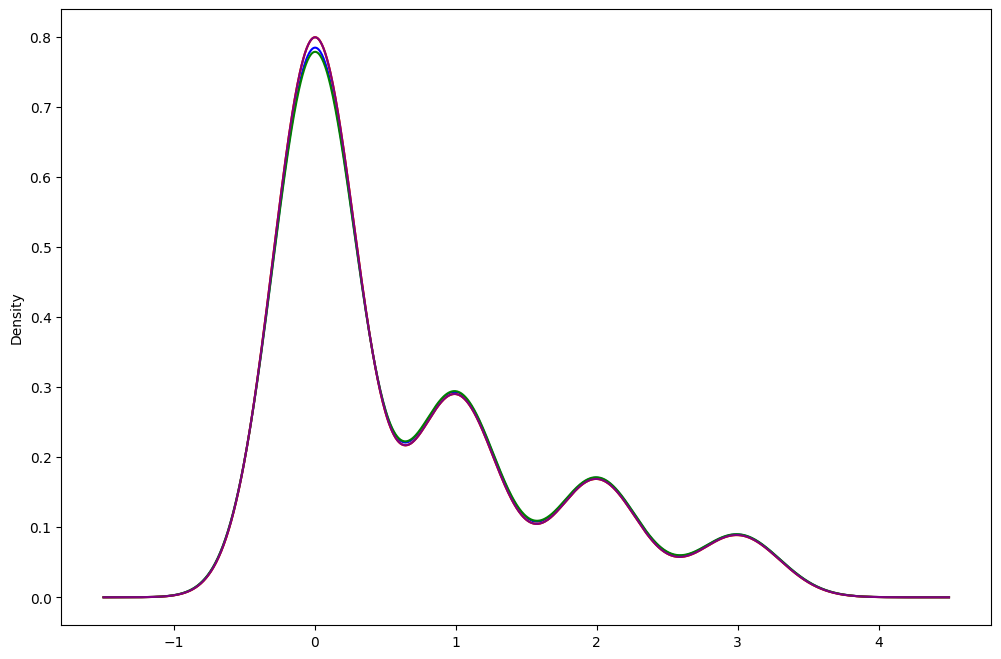

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))

df_new.no_of_vessels.plot(kind='kde',color='blue')
df_new1.no_of_vessels.plot(kind='kde',color='yellow')
df_new1b.no_of_vessels.plot(kind='kde',color='red')
df_new2.no_of_vessels.plot(kind='kde',color='green')
df_new3.no_of_vessels.plot(kind='kde',color='purple')
plt.show()

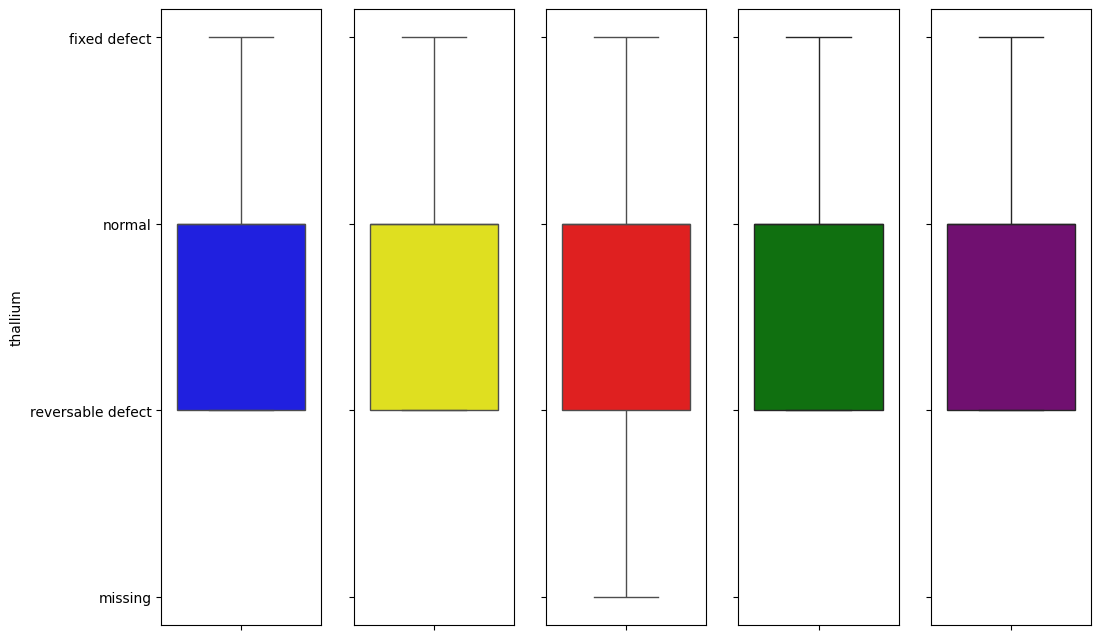

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(12,8), sharey=True)
sns.boxplot(y=df_new.thallium, ax=ax[0], color='blue')
sns.boxplot(y=df_new1.thallium, ax=ax[1], color='yellow')
sns.boxplot(y=df_new1b.thallium, ax=ax[2], color='red')
sns.boxplot(y=df_new2.thallium, ax=ax[3], color='green')
sns.boxplot(y=df_new3.thallium, ax=ax[4], color='purple')
plt.show()

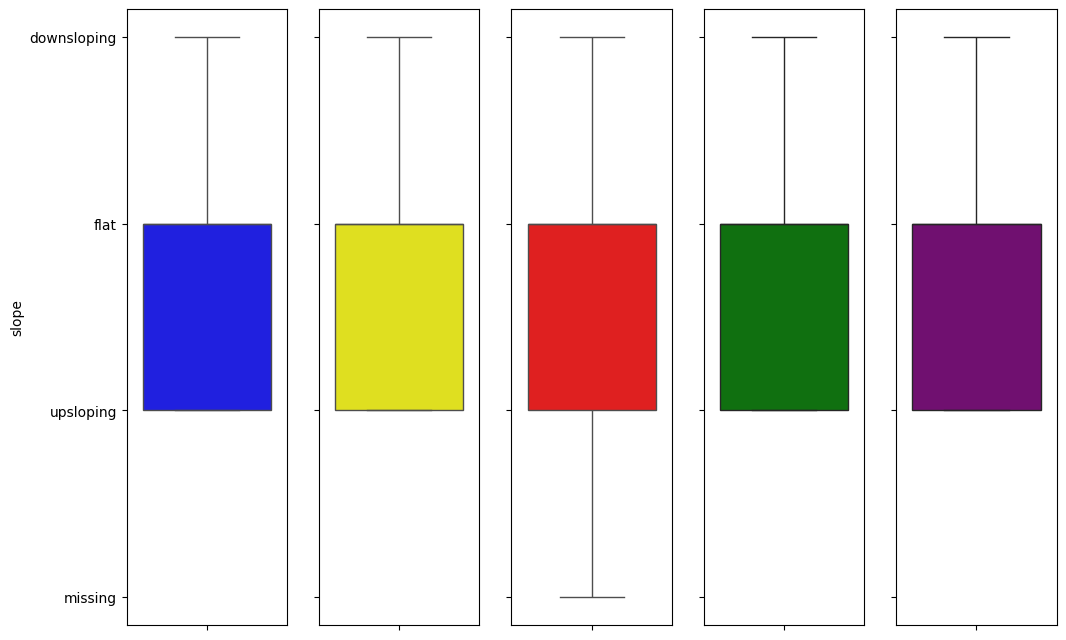

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(12,8), sharey=True)
sns.boxplot(y=df_new.slope, ax=ax[0], color='blue')
sns.boxplot(y=df_new1.slope, ax=ax[1], color='yellow')
sns.boxplot(y=df_new1b.slope, ax=ax[2], color='red')
sns.boxplot(y=df_new2.slope, ax=ax[3], color='green')
sns.boxplot(y=df_new3.slope, ax=ax[4], color='purple')
plt.show()

- Distributions are similar across all 3 strategies.
- the manual imputation (yellow) and model prediciton imputation (purple) are aligned but since models predictions utilized multivariate relationship without any bias, and we don't lose any information, we proceed with df_new3



#### Cheking for / Handling duplicates (if any)

In [ ]:
# checking for duplicates
df_new3[df_new3.duplicated()]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium,diagnosis


No duplicates to worry about!

#### Outlier check

In [ ]:
skew_df = df_new3.skew(numeric_only=True).sort_values()
skew_df

max_heart_rate   -0.535122
age              -0.252273
r_bp              0.708107
diagnosis         1.063281
chol              1.096717
no_of_vessels     1.213616
st_depression     1.273272
dtype: float64

- chol, st_depression, no_of_vessels, and diagnosis are extremely positively skewed (value ranges >1)
- r_bp is moderately positively skewed (value ranges btw 0.5 to 1)
- max_heart_rate is moderately negatively skewed (value ranges btw -0.5 to -1)
- age is fairly symmetrical (value ranges btw -0.5 to 0.5)


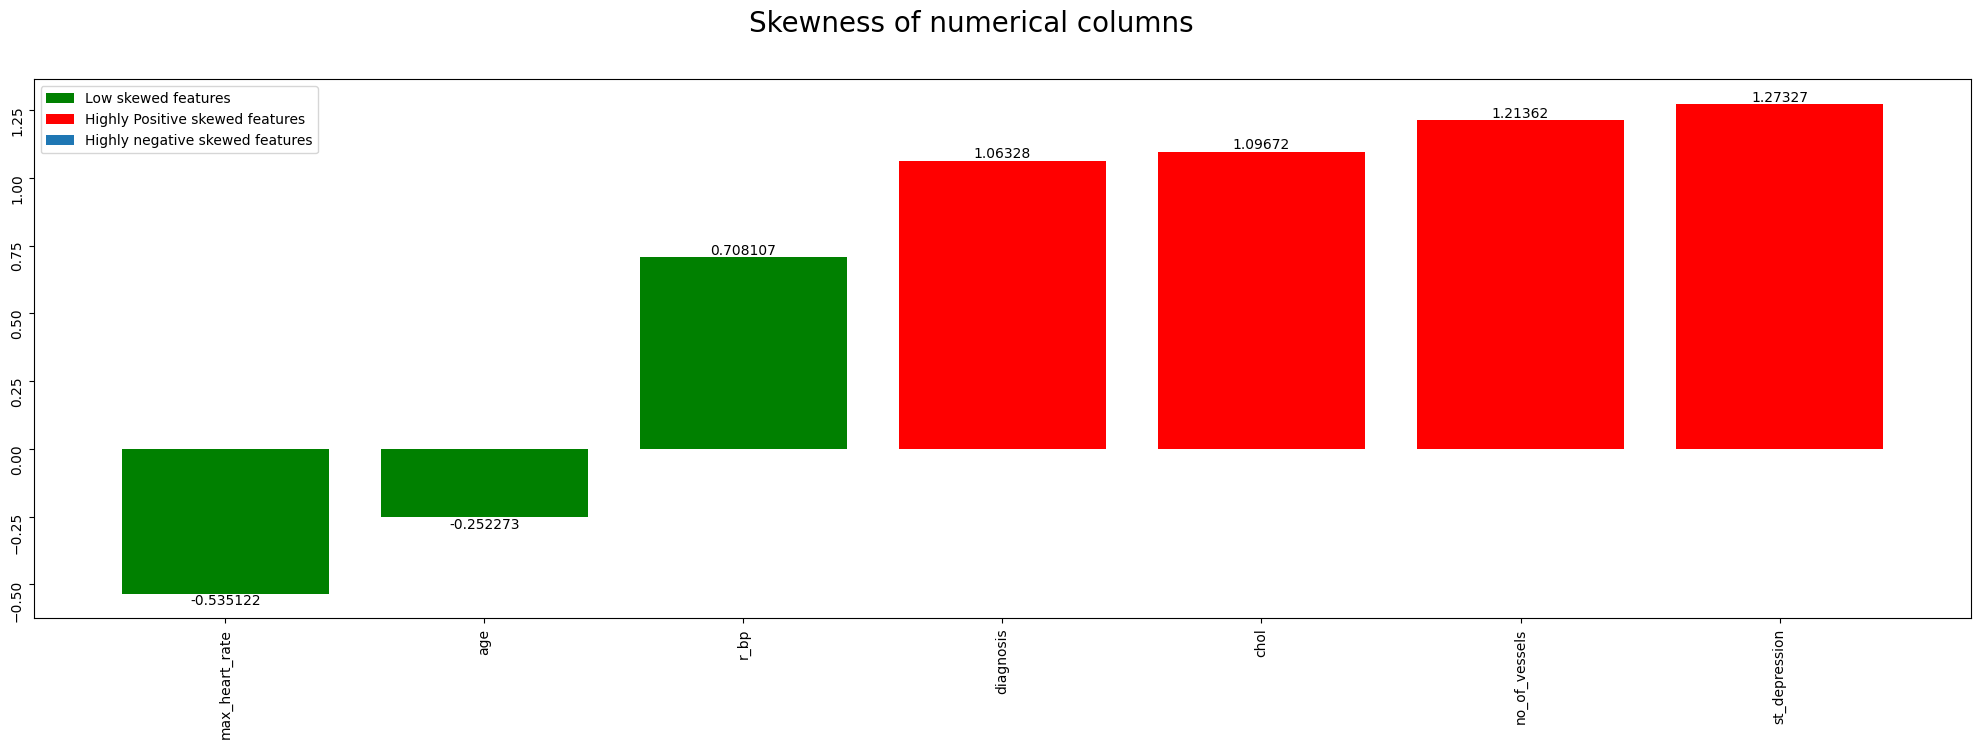

In [ ]:
fig,ax = plt.subplots(figsize=(25,7))

ax.bar(x = skew_df[(skew_df<1)].index, height = skew_df[(skew_df<1)], color = "g", label= "Low skewed features")
ax.bar(x = skew_df[skew_df>1].index, height = skew_df[skew_df>1], color = "r", label = "Highly Positive skewed features")
ax.bar(x = skew_df[skew_df<-1].index, height = skew_df[skew_df<-1], color = "b",label = "Highly negative skewed features")
ax.legend()
fig.suptitle("Skewness of numerical columns",fontsize = 20)
ax.tick_params(labelrotation=90)
for bars in ax.containers:
    ax.bar_label(bars)


///////////// max_heart_rate column /////////////

Q1 is 133.75 while Q3 is 166.0
IQR is 32.25
The Lower limit is 85.375 while the Upper limit is 214.375


<Figure size 700x400 with 0 Axes>

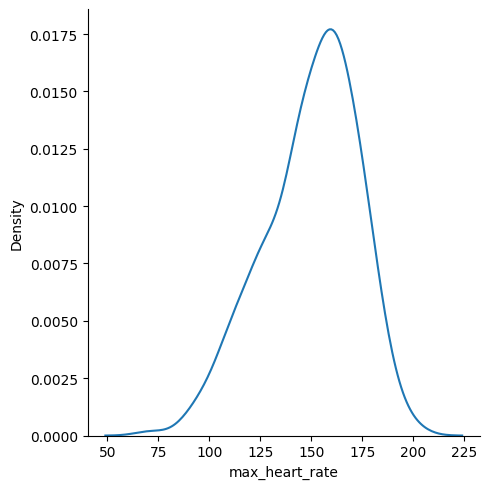

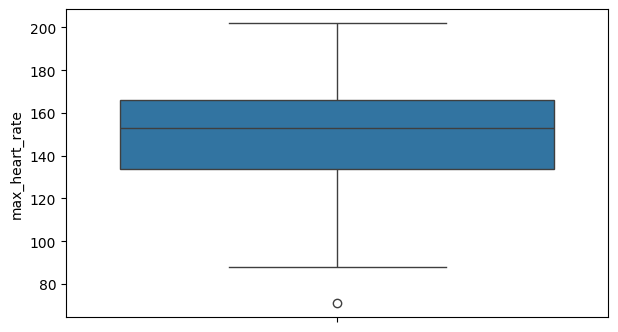

     age   sex       cp_type   r_bp   chol is_diabetic   r_ecg  \
245   67  Male  asymptomatic  120.0  237.0       False  normal   

     max_heart_rate  exang  st_depression slope  no_of_vessels thallium  \
245            71.0  False            1.0  flat            0.0   normal   

     diagnosis  
245          2  

///////////// age column /////////////

Q1 is 47.75 while Q3 is 61.0
IQR is 13.25
The Lower limit is 27.875 while the Upper limit is 80.875


<Figure size 700x400 with 0 Axes>

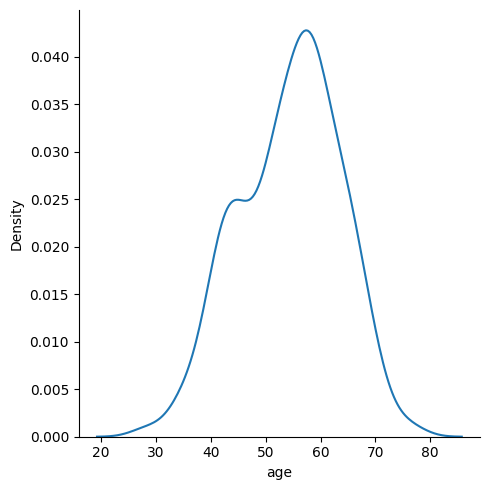

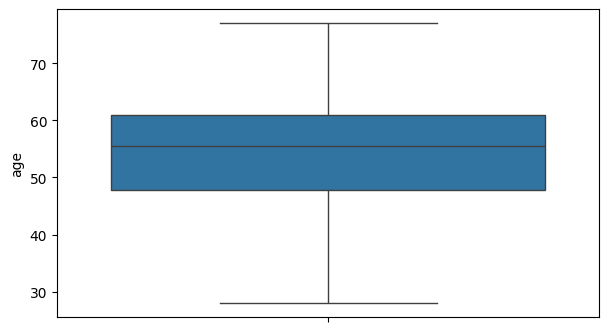


No outliers!

///////////// r_bp column /////////////

Q1 is 120.0 while Q3 is 140.0
IQR is 20.0
The Lower limit is 90.0 while the Upper limit is 170.0


<Figure size 700x400 with 0 Axes>

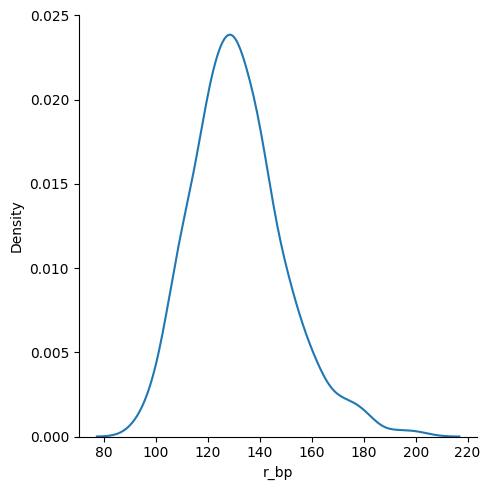

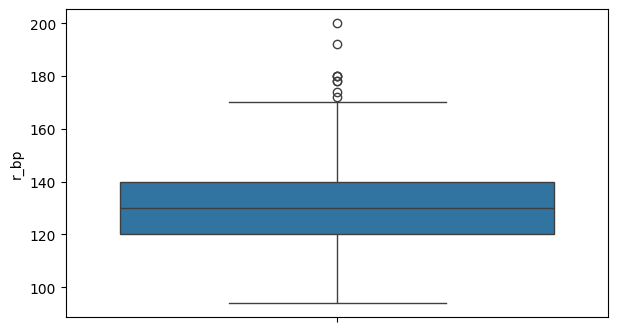

     age     sex          cp_type   r_bp   chol is_diabetic             r_ecg  \
14    52    Male      non-anginal  172.0  199.0        True            normal   
83    68    Male      non-anginal  180.0  274.0        True    lv hypertrophy   
126   56  Female     asymptomatic  200.0  288.0        True    lv hypertrophy   
172   59  Female     asymptomatic  174.0  249.0       False            normal   
183   59    Male   typical angina  178.0  270.0       False    lv hypertrophy   
188   54    Male  atypical angina  192.0  283.0       False    lv hypertrophy   
201   64  Female     asymptomatic  180.0  325.0       False            normal   
213   66  Female     asymptomatic  178.0  228.0        True            normal   
231   55  Female     asymptomatic  180.0  327.0       False  st-t abnormality   

     max_heart_rate  exang  st_depression        slope  no_of_vessels  \
14            162.0  False            0.5    upsloping            0.0   
83            150.0   True            1.6  

<Figure size 700x400 with 0 Axes>

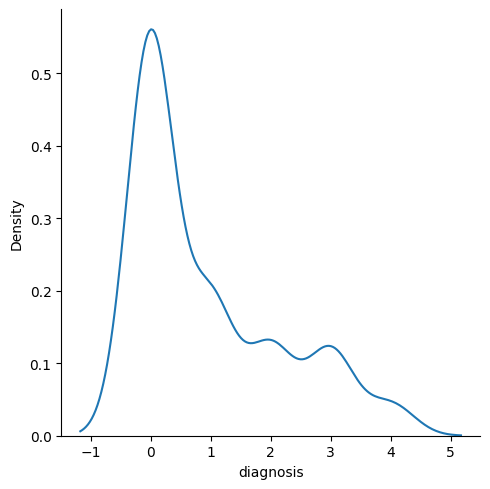

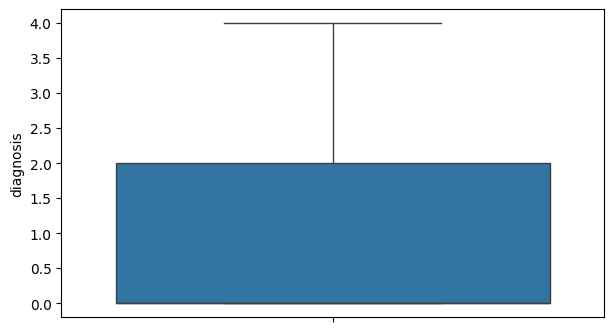


No outliers!

///////////// chol column /////////////

Q1 is 211.0 while Q3 is 275.0
IQR is 64.0
The Lower limit is 115.0 while the Upper limit is 371.0


<Figure size 700x400 with 0 Axes>

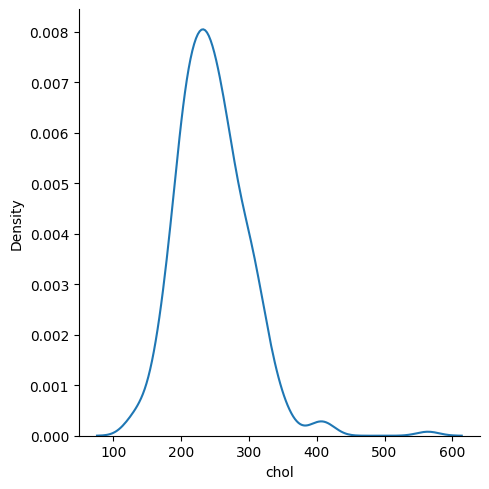

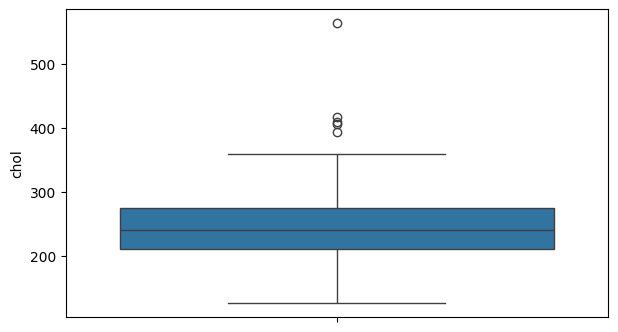

     age     sex       cp_type   r_bp   chol is_diabetic           r_ecg  \
48    65  Female   non-anginal  140.0  417.0        True  lv hypertrophy   
121   63  Female  asymptomatic  150.0  407.0       False  lv hypertrophy   
152   67  Female   non-anginal  115.0  564.0       False  lv hypertrophy   
173   62  Female  asymptomatic  140.0  394.0       False  lv hypertrophy   
181   56  Female  asymptomatic  134.0  409.0       False  lv hypertrophy   

     max_heart_rate  exang  st_depression      slope  no_of_vessels  \
48            157.0  False            0.8  upsloping            1.0   
121           154.0  False            4.0       flat            3.0   
152           160.0  False            1.6       flat            0.0   
173           157.0  False            1.2       flat            0.0   
181           150.0   True            1.9       flat            2.0   

              thallium  diagnosis  
48              normal          0  
121  reversable defect          4  
152  rev

<Figure size 700x400 with 0 Axes>

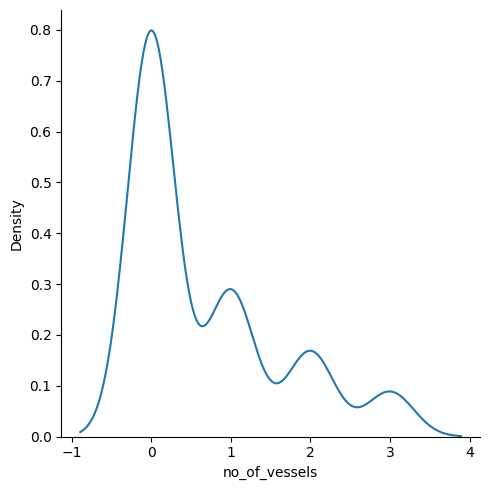

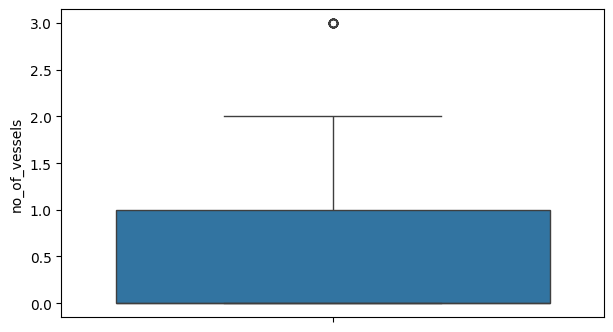

     age     sex          cp_type   r_bp   chol is_diabetic             r_ecg  \
1     67    Male     asymptomatic  160.0  286.0       False    lv hypertrophy   
40    65  Female     asymptomatic  150.0  225.0       False    lv hypertrophy   
62    58    Male     asymptomatic  128.0  216.0       False    lv hypertrophy   
91    62  Female     asymptomatic  160.0  164.0       False    lv hypertrophy   
92    62    Male      non-anginal  130.0  231.0       False            normal   
104   49    Male      non-anginal  120.0  188.0       False            normal   
118   63    Male     asymptomatic  130.0  330.0        True    lv hypertrophy   
121   63  Female     asymptomatic  150.0  407.0       False    lv hypertrophy   
146   57    Male     asymptomatic  165.0  289.0        True    lv hypertrophy   
155   70    Male     asymptomatic  130.0  322.0       False    lv hypertrophy   
161   77    Male     asymptomatic  125.0  304.0       False    lv hypertrophy   
176   52    Male     asympto

<Figure size 700x400 with 0 Axes>

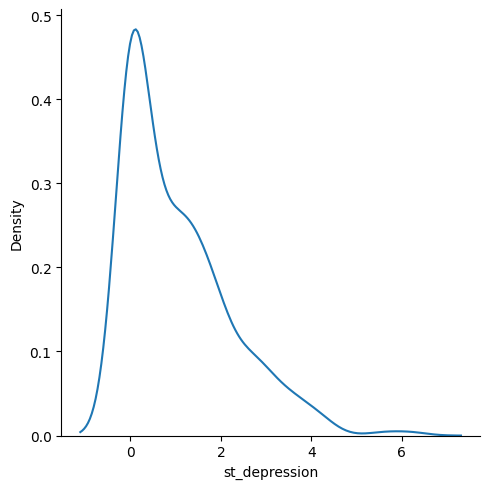

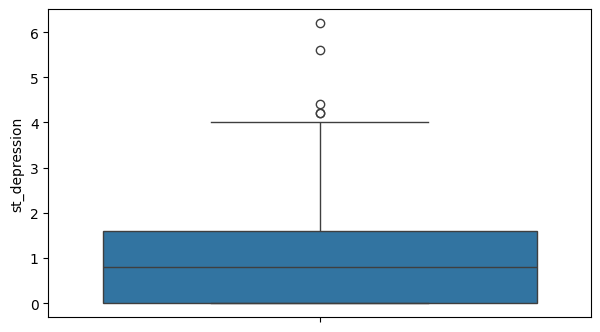

     age     sex         cp_type   r_bp   chol is_diabetic             r_ecg  \
91    62  Female    asymptomatic  160.0  164.0       False    lv hypertrophy   
123   55    Male    asymptomatic  140.0  217.0       False            normal   
183   59    Male  typical angina  178.0  270.0       False    lv hypertrophy   
191   51    Male    asymptomatic  140.0  298.0       False            normal   
285   58    Male    asymptomatic  114.0  318.0       False  st-t abnormality   

     max_heart_rate  exang  st_depression        slope  no_of_vessels  \
91            145.0  False            6.2  downsloping            3.0   
123           111.0   True            5.6  downsloping            0.0   
183           145.0  False            4.2  downsloping            0.0   
191           122.0   True            4.2         flat            3.0   
285           140.0  False            4.4  downsloping            3.0   

              thallium  diagnosis  
91   reversable defect          3  
123  rev

In [ ]:
for col in skew_df.index.values:
  detect_outliers(df_new3, col)

##EDA

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             304 non-null    int64  
 1   sex             304 non-null    object 
 2   cp_type         304 non-null    object 
 3   r_bp            304 non-null    float64
 4   chol            304 non-null    float64
 5   is_diabetic     304 non-null    object 
 6   r_ecg           304 non-null    object 
 7   max_heart_rate  304 non-null    float64
 8   exang           304 non-null    object 
 9   st_depression   304 non-null    float64
 10  slope           304 non-null    object 
 11  no_of_vessels   304 non-null    float64
 12  thallium        304 non-null    object 
 13  diagnosis       304 non-null    int64  
dtypes: float64(5), int64(2), object(7)
memory usage: 35.6+ KB


###Exploring the target

In [ ]:
df_new3.diagnosis.value_counts()

0    165
1     55
2     36
3     35
4     13
Name: diagnosis, dtype: int64

- The imbalance between label 0 (no heart disease) and the rest of the labels (heart disease present) is too wide. Because the data is small, we can't undersample the minority class, and oversampling the majority might introduce too many synthetic datapoints.

- We simplify this by aggregating the classes 1-4 as ***1***, to represent the presence of heart disease

In [ ]:
df_new3['diagnosis_encoded'] = df_new3.diagnosis.apply(lambda x: 0 if x == 0 else 1)
df_new3.diagnosis_encoded.value_counts()

0    165
1    139
Name: diagnosis_encoded, dtype: int64

In [ ]:
df_new3['diagnosis'] = df_new3.diagnosis_encoded.apply(lambda x: 'Present' if x == 1 else 'Absent')
df_new3.diagnosis.value_counts()

Absent     165
Present    139
Name: diagnosis, dtype: int64

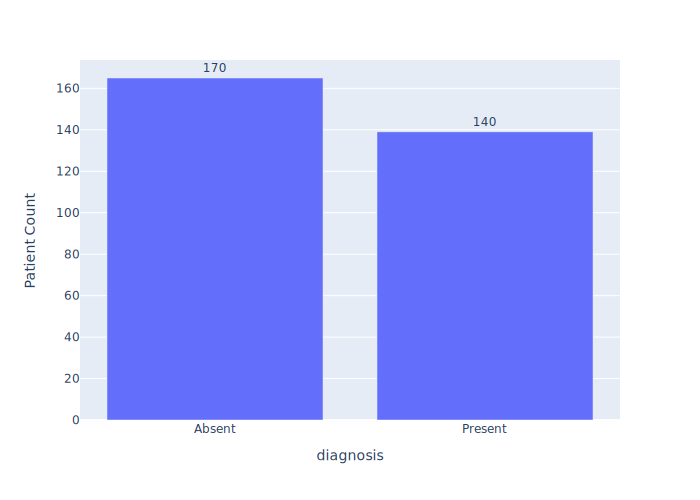

In [ ]:
count_plot(df_new3, 'diagnosis')

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                304 non-null    int64  
 1   sex                304 non-null    object 
 2   cp_type            304 non-null    object 
 3   r_bp               304 non-null    float64
 4   chol               304 non-null    float64
 5   is_diabetic        304 non-null    object 
 6   r_ecg              304 non-null    object 
 7   max_heart_rate     304 non-null    float64
 8   exang              304 non-null    object 
 9   st_depression      304 non-null    float64
 10  slope              304 non-null    object 
 11  no_of_vessels      304 non-null    float64
 12  thallium           304 non-null    object 
 13  diagnosis          304 non-null    object 
 14  diagnosis_encoded  304 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 38.0+ KB


### Age

In [ ]:
df_new3.age.describe()

count    304.000000
mean      54.351974
std        9.150256
min       28.000000
25%       47.750000
50%       55.500000
75%       61.000000
max       77.000000
Name: age, dtype: float64

- Youngest patient: 28yrs
- Oldest patient: 77yrs

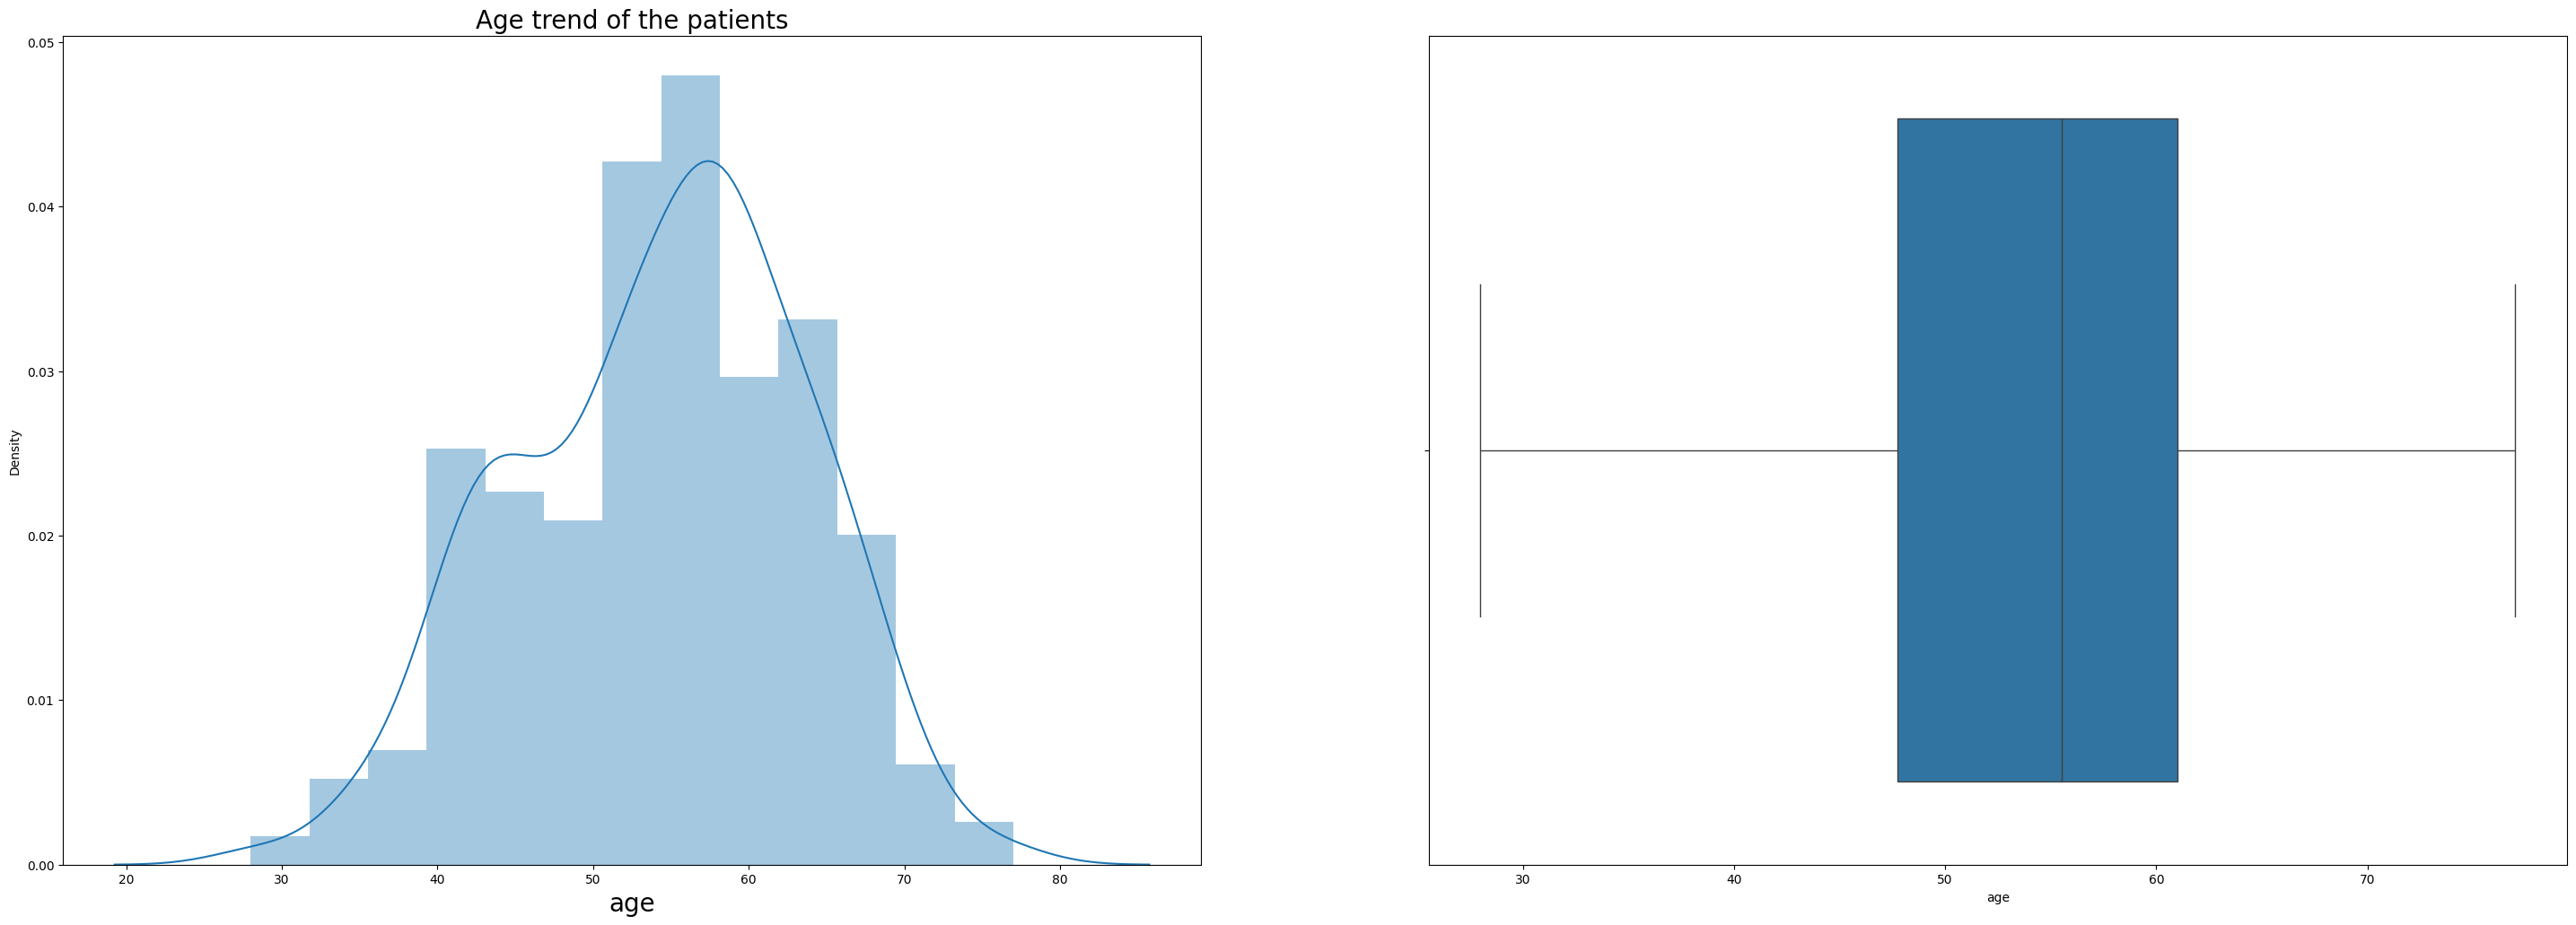

In [ ]:
distribution_plot(df_new3, 'age')

We can see that majority of the patients were between 50 and 65yrs old

#### plot against diagnosis

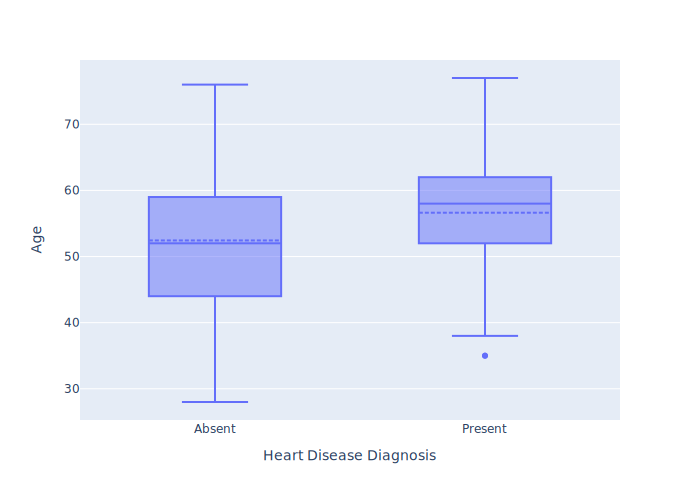

In [ ]:
fig = px.box(df_new3, x="diagnosis", y="age",
             labels=dict(
                 diagnosis='Heart Disease Diagnosis',
                 age='Age'))
fig.update_traces(boxmean=True)
fig.show('svg')

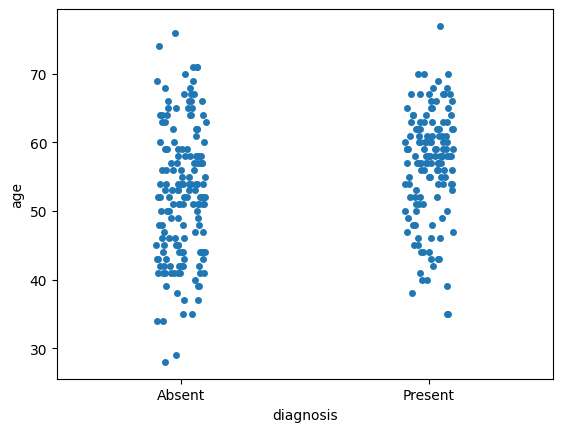

In [ ]:
sns.stripplot(data=df_new3, x='diagnosis', y='age')
plt.show()

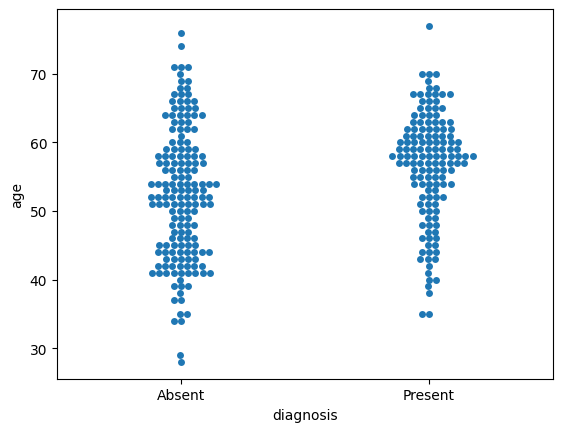

In [ ]:
sns.swarmplot(data=df_new3, x='diagnosis', y='age')
plt.show()

- We can see heart disease is more frequent in the older patients (the distribution of the patients age - mean and median) increases for patients with heart disease


### Sex

In [ ]:
df_new3.sex.value_counts()

Male      207
Female     97
Name: sex, dtype: int64

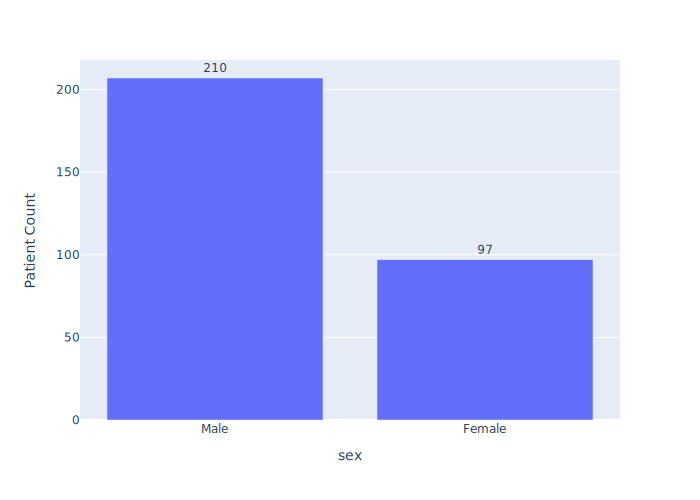

In [ ]:
count_plot(df_new3, 'sex')

- Majority of the patients are Male

#### plot against diagnosis

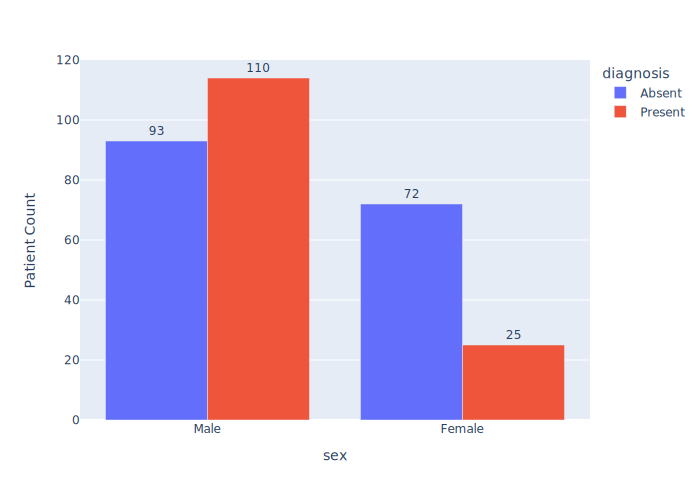

In [ ]:
count_plot(df_new3, 'sex', 'diagnosis')

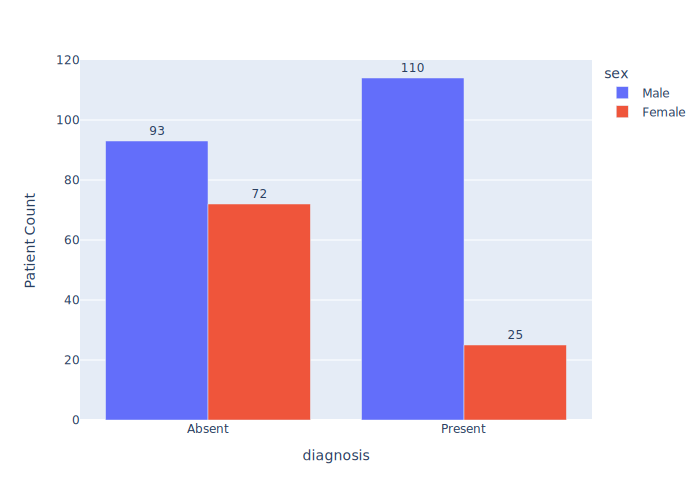

In [ ]:
count_plot(df_new3, 'diagnosis', 'sex')

- Although there are more males with heart disease, Both male and female patients have a chance of having heart disease
- Since the number of female patients is way smaller than males, The sex of the patient doesn't give a clear direct indication of the patients diagnosis, since we can see close to similar numbers for patients diagnosed with heart disease.


Proving no association/relationship btw sex and diagnosis using [Cramers V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

In [ ]:
def cramers_corrected_stat(data, col1, col2):
  """ calculate Cramers V statistic for categorial-categorial association.
      uses correction from Bergsma and Wicher,
      Journal of the Korean Statistical Society 42 (2013): 323-328
  """
  confusion_matrix = pd.crosstab(data[col1], data[col2]).to_numpy()
  chi2 = chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum()
  phi2 = chi2/n
  r,k = confusion_matrix.shape
  phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  rcorr = r - ((r-1)**2)/(n-1)
  kcorr = k - ((k-1)**2)/(n-1)
  return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [ ]:
cramers_corrected_stat(df_new3, 'sex', 'diagnosis')

0.26123998017312405

Since cramers coefficient ranges from 0-1 with 1 being highly correlated and 0 lacking correlation, this tells us that the sex and diagnosis are not correlated.

- Testing using pearsons correlation

In [ ]:
df_new3['sex_encoded'] = df_new3.sex.apply(lambda x: 0 if x=='Female' else 1)
df_new3.sex_encoded.value_counts()

1    207
0     97
Name: sex_encoded, dtype: int64

In [ ]:
df_new3[['sex_encoded','diagnosis_encoded']].corr()

,sex_encoded,diagnosis_encoded
sex_encoded,1.000000,0.274144
diagnosis_encoded,0.274144,1.000000


In [ ]:
corr, p_value = spearmanr(df_new3['sex_encoded'], df_new3['diagnosis_encoded'])
print(f'correlation: {corr}, p-value: {p_value}')

correlation: 0.2741438049918327, p-value: 1.2132036424630845e-06


In [ ]:
corr, p_value = kendalltau(df_new3['sex_encoded'], df_new3['diagnosis_encoded'])
print(f'correlation: {corr}, p-value: {p_value}')

correlation: 0.27414380499183266, p-value: 1.8241231732413761e-06


- All the results prove that there is low correlation btw the variables, and the p-value < 0.05 tells us that our correlation result is statisticaly significant and

In [ ]:
# # confirm with correlation check
# def check_correlation(data, col1, col2):
#   # Cross tabulation between columns specified
#   cross_tab_result = pd.crosstab(index=data[col1], columns=data[col2])
#   print(cross_tab_result)
#   print('\n')

#   # Performing Chi-sq test
#   chi_sqr_result = chi2_contingency(cross_tab_result)
#   print(chi_sqr_result)
#   p_value = chi_sqr_result[1]
#   if p_value <= 0.05:
#     # enough evidence to reject null hypothesis (H0) - no relationship ==> move with alternate (H1)
#     print(f"Since the p-value: {p_value} is < 0.05 significance level, we are 95% confident to reject the null hypothesis")
#     print(f"Therefore, {col1} and {col2} columns are correlated with eachother")
#   else:
#     # not enough evidence to reject null hypothesis (H0) - no relationship ==> move with null (H0)
#     print(f"Since the p-value: {p_value} is > 0.05 significance level, we can't reject the null hypothesis. ")
#     print(f"Therefore, {col1} and {col2} columns are not correlated with eachother")

In [ ]:
# check_correlation(df_new3, 'sex', 'diagnosis')

### Chest Pain Type

In [ ]:
df_new3.cp_type.value_counts()

asymptomatic       144
non-anginal         86
atypical angina     51
typical angina      23
Name: cp_type, dtype: int64

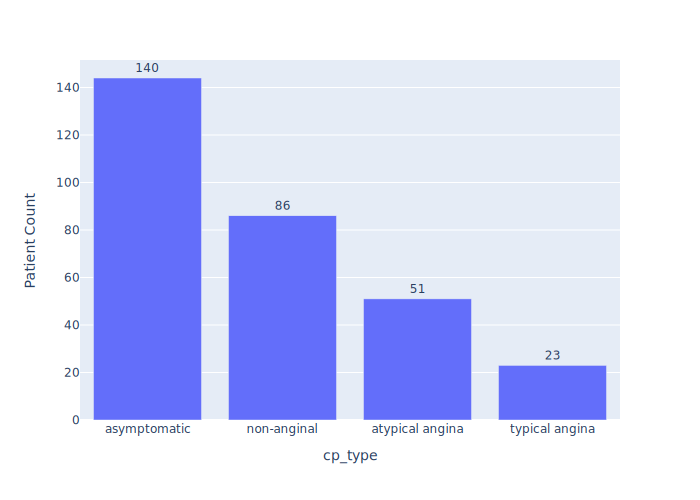

In [ ]:
count_plot(df_new3, 'cp_type')

#### plot against diagnosis

In [ ]:
# custom_dict = {'Absent':0, 'Mild':1, 'Moderate':2, 'Severe':3, 'Critical':4}
df_new3.groupby(['diagnosis', 'cp_type']).agg(count=('diagnosis','count')).reset_index().sort_values(['diagnosis','count'], ascending=[True,False])#, key=lambda x: x.map(custom_dict))

,diagnosis,cp_type,count
2,Absent,non-anginal,68
1,Absent,atypical angina,42
0,Absent,asymptomatic,39
3,Absent,typical angina,16
4,Present,asymptomatic,105
6,Present,non-anginal,18
5,Present,atypical angina,9
7,Present,typical angina,7


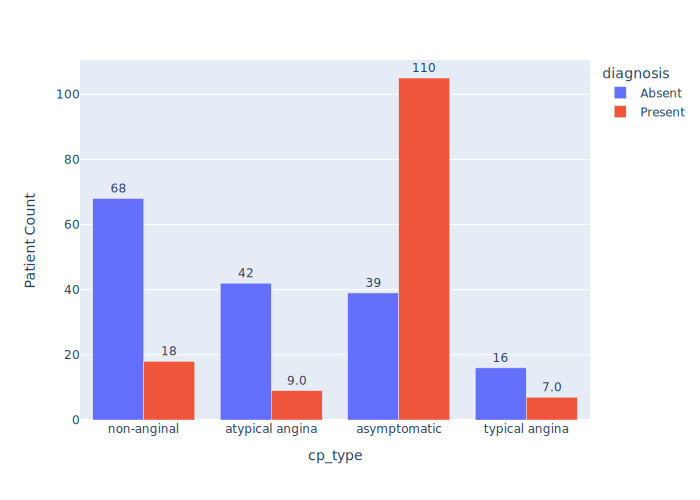

In [ ]:
count_plot(df_new3, 'cp_type', 'diagnosis')

- Asymptomatic chest pain definitely has an impact on patients being diagnosed with heart disease

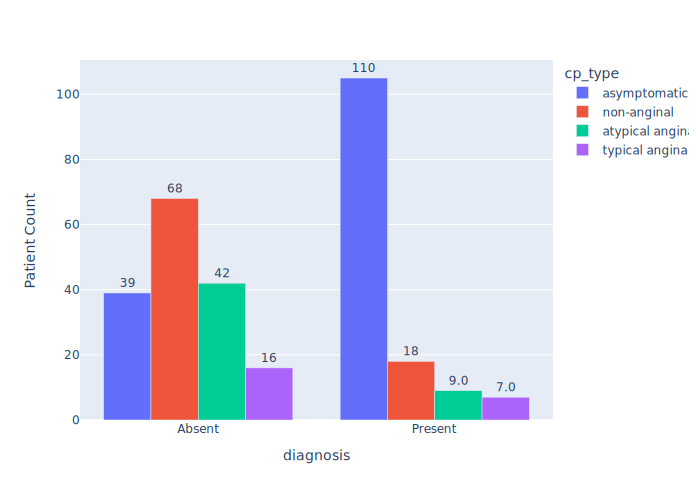

In [ ]:
count_plot(df_new3, 'diagnosis', 'cp_type')

- Majority of patients without heart disease have the Non-anginal chest pain
- Majority of patients with heart disease have the Asymptomatic chest pain
- Typical angina chest pain occurs the least / is the least frequently experienced chest pain for patients with/without heart disease

### Resting blood pressure (RBP)

In [ ]:
df_new3.r_bp.describe()

count    304.000000
mean     131.684211
std       17.570949
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: r_bp, dtype: float64

- Lowest RBP patient: 94
- Highest RBP patient: 200

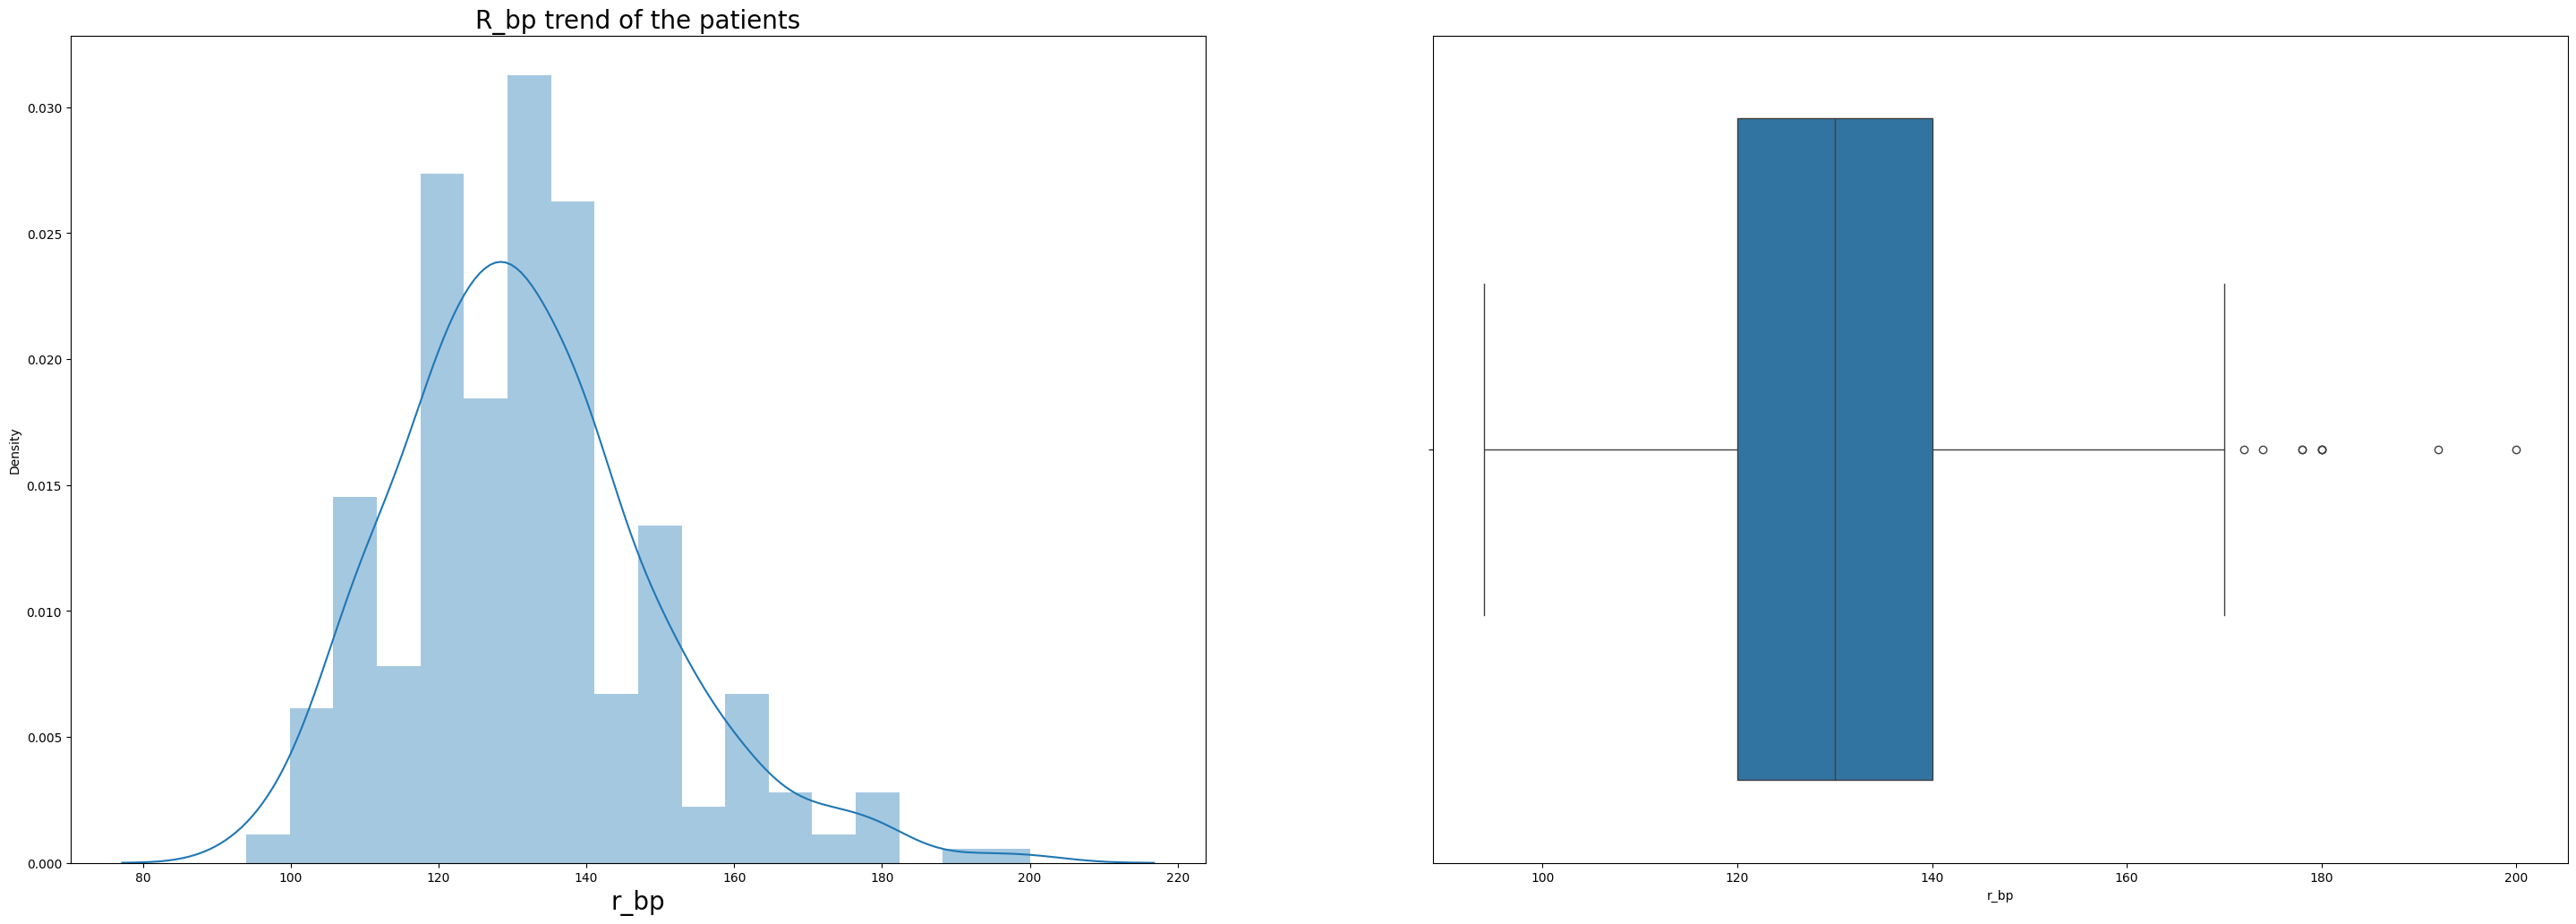

In [ ]:
distribution_plot(df_new3, 'r_bp')

We can see that majority of the patients had resting bp reading that were [not normal/healthy](https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings) - btw 120-140mmHg with some outliers >170 rbp

#### plot against diagnosis

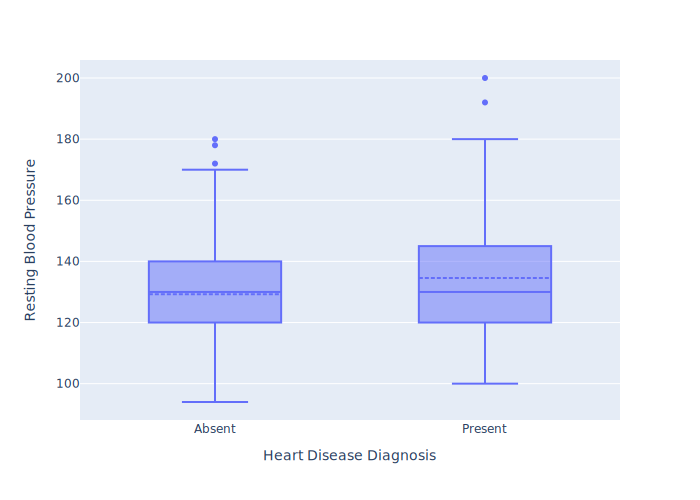

In [ ]:
fig = px.box(df_new3, x="diagnosis", y="r_bp",
            #  category_orders={'diagnosis': ['Present', 'Absent']},
             labels=dict(
                 diagnosis='Heart Disease Diagnosis',
                 r_bp='Resting Blood Pressure'))#, color="smoker")
fig.update_traces(boxmean=True)
fig.show('svg')

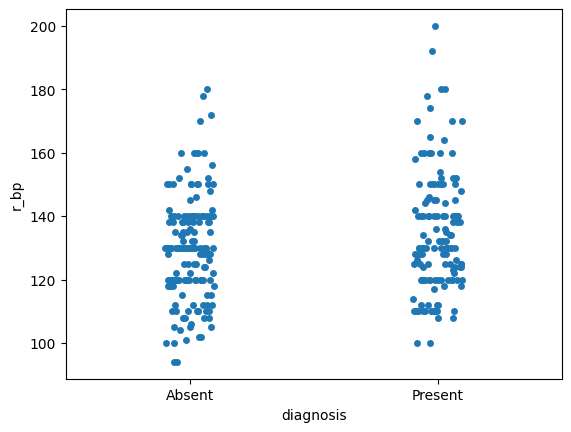

In [ ]:
sns.stripplot(data=df_new3, x='diagnosis', y='r_bp')
plt.show()

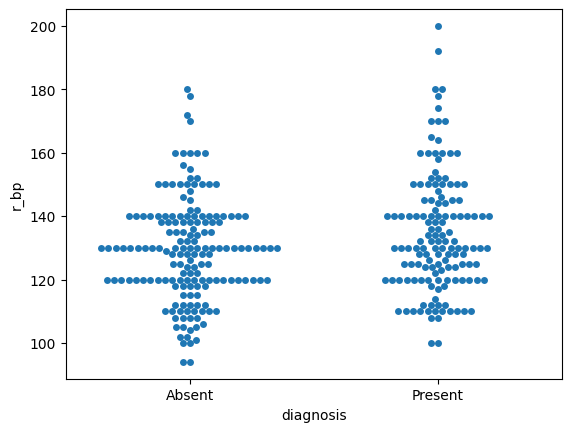

In [ ]:
sns.swarmplot(data=df_new3, x='diagnosis', y='r_bp')
plt.show()

- RBP is almost evenly distributed across both heart disease diagnosis
- Due to the lack of distinction across the bp values, this feature won't be useful in our model diagnosis


In [ ]:
df_new3[['r_bp','diagnosis_encoded']].corr()

,r_bp,diagnosis_encoded
r_bp,1.000000,0.150904
diagnosis_encoded,0.150904,1.000000


In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                304 non-null    int64  
 1   sex                304 non-null    object 
 2   cp_type            304 non-null    object 
 3   r_bp               304 non-null    float64
 4   chol               304 non-null    float64
 5   is_diabetic        304 non-null    object 
 6   r_ecg              304 non-null    object 
 7   max_heart_rate     304 non-null    float64
 8   exang              304 non-null    object 
 9   st_depression      304 non-null    float64
 10  slope              304 non-null    object 
 11  no_of_vessels      304 non-null    float64
 12  thallium           304 non-null    object 
 13  diagnosis          304 non-null    object 
 14  diagnosis_encoded  304 non-null    int64  
 15  sex_encoded        304 non-null    int64  
dtypes: float64(5), int64(3), o

### Cholesterol level

In [ ]:
df_new3.chol.describe()

count    304.000000
mean     246.315789
std       52.108280
min      126.000000
25%      211.000000
50%      240.500000
75%      275.000000
max      564.000000
Name: chol, dtype: float64

- Lowest cholesterol level of a patient: 126
- Highest cholesterol level of a patient: 500

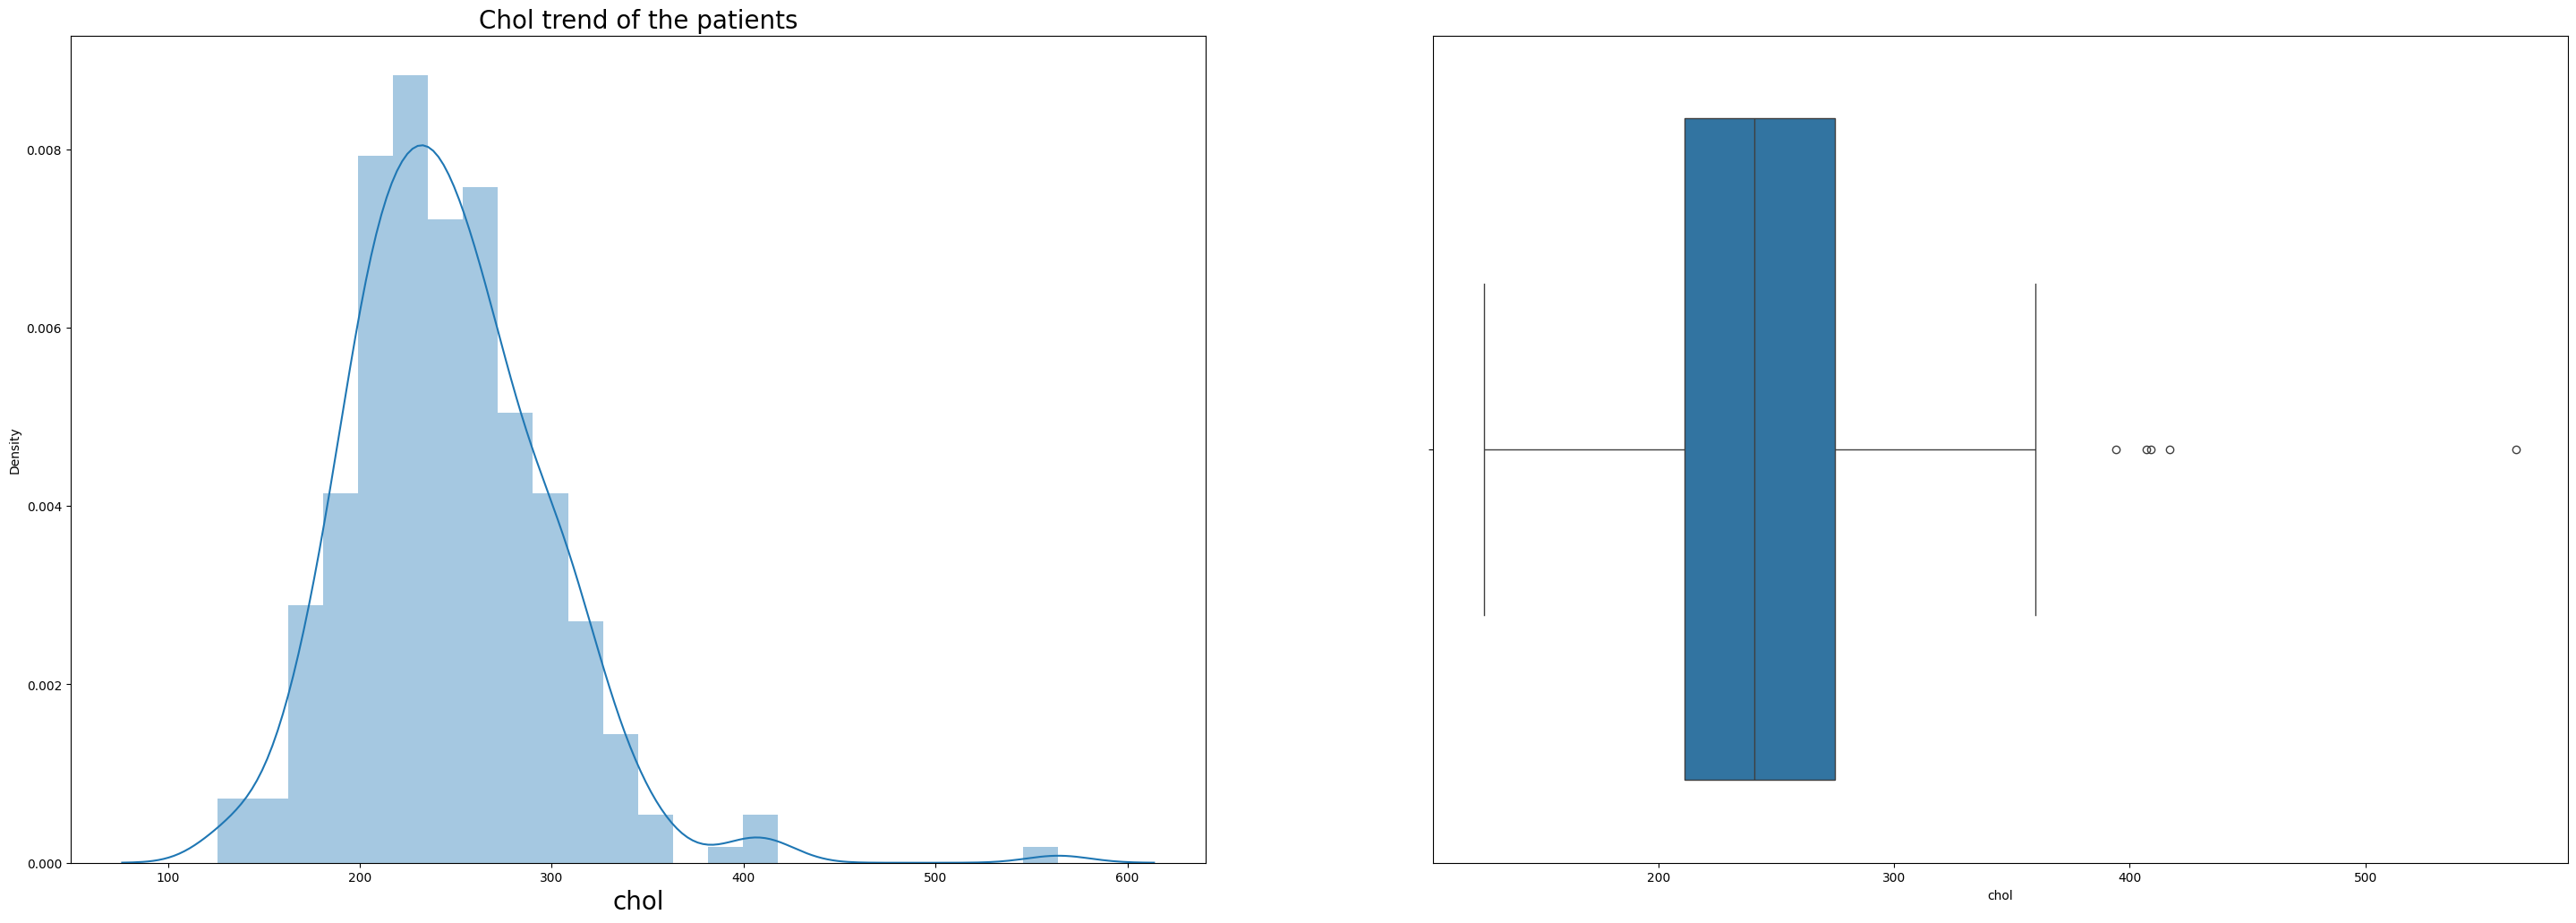

In [ ]:
distribution_plot(df_new3, 'chol')

We can see that majority of the patients had high cholesterol level btw 200-300 with some outliers >400

#### plot against diagnosis

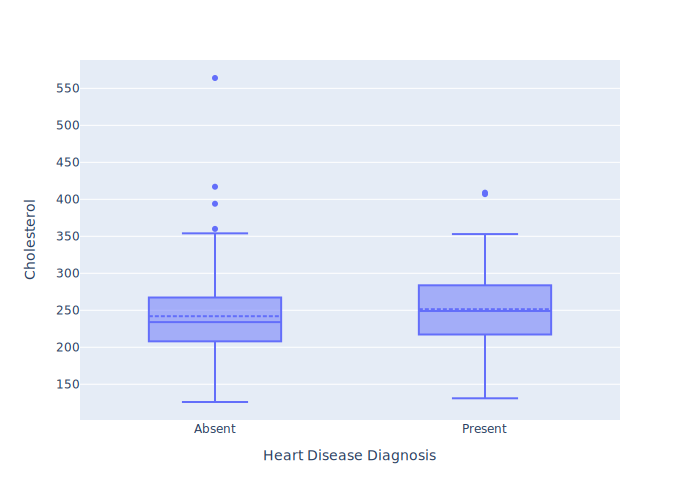

In [ ]:
fig = px.box(df_new3, x="diagnosis", y="chol",
            #  category_orders={'diagnosis': ['Absent', 'Mild', 'Moderate', 'Severe', 'Critical']},
             labels=dict(
                 diagnosis='Heart Disease Diagnosis',
                 chol='Cholesterol'))#, color="smoker")
fig.update_traces(boxmean=True)
fig.show('svg')

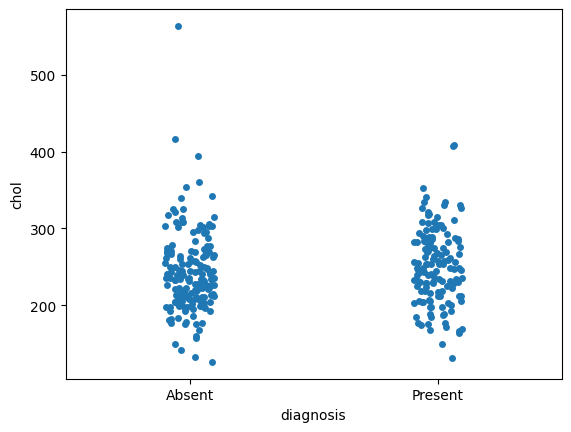

In [ ]:
sns.stripplot(data=df_new3, x='diagnosis', y='chol')
plt.show()

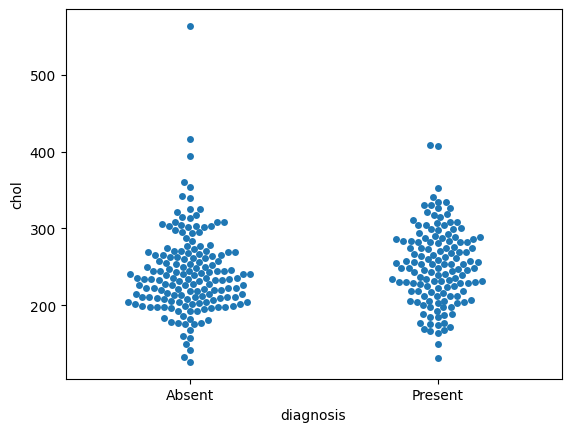

In [ ]:
sns.swarmplot(data=df_new3, x='diagnosis', y='chol')
plt.show()

- Cholesterol across across both heart diseases diagnosis ranges btw the similar high values
- Due to the lack of distinction across the cholesterol values, this feature won't be useful in our model diagnosis


### is_diabetic

In [ ]:
df_new3.is_diabetic.value_counts()

False    259
True      45
Name: is_diabetic, dtype: int64

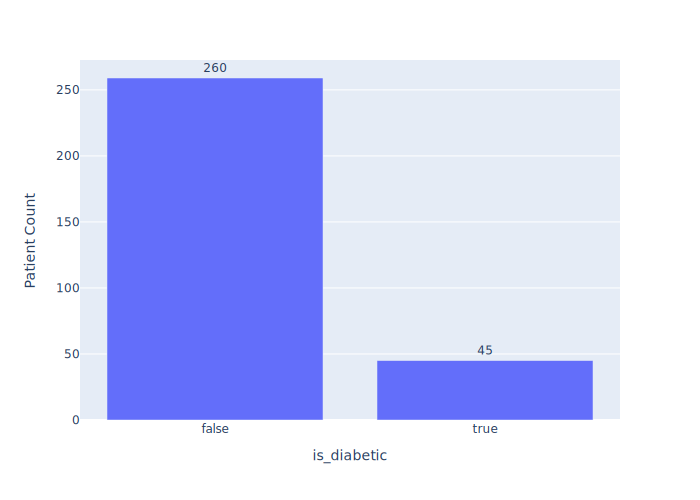

In [ ]:
count_plot(df_new3, 'is_diabetic')

Majority of patients are not diabetic

#### plot against diagnosis

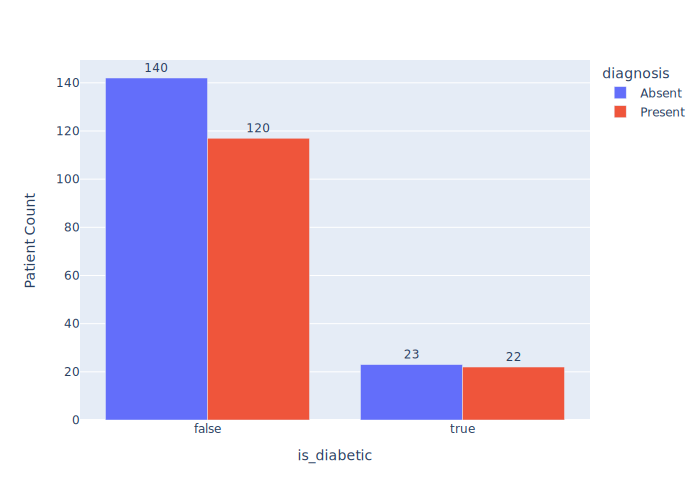

In [ ]:
count_plot(df_new3, 'is_diabetic', 'diagnosis')

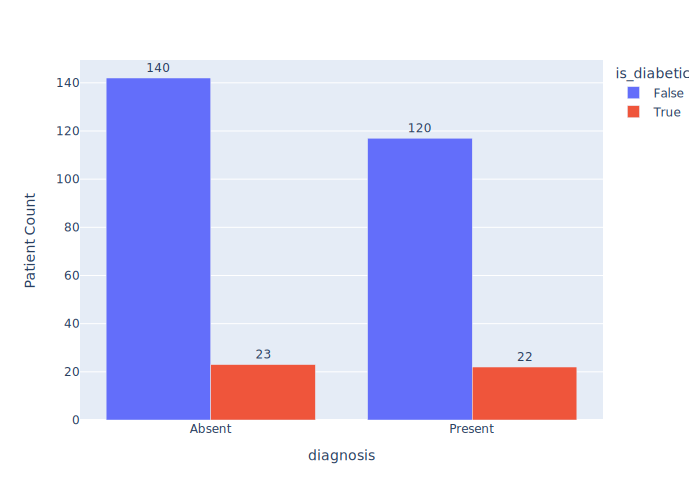

In [ ]:
count_plot(df_new3, 'diagnosis', 'is_diabetic')

- No distinct difference in the impact of diabetes on heart disease since the majority of patients diagnosed with heart disease were not diabetic and majority of the diabetic patients were diagnosed without heart disease, so we will be excluding this feature as well

### Resting ECG (RECG)

In [ ]:
df_new3.r_ecg.value_counts()

normal              151
lv hypertrophy      149
st-t abnormality      4
Name: r_ecg, dtype: int64

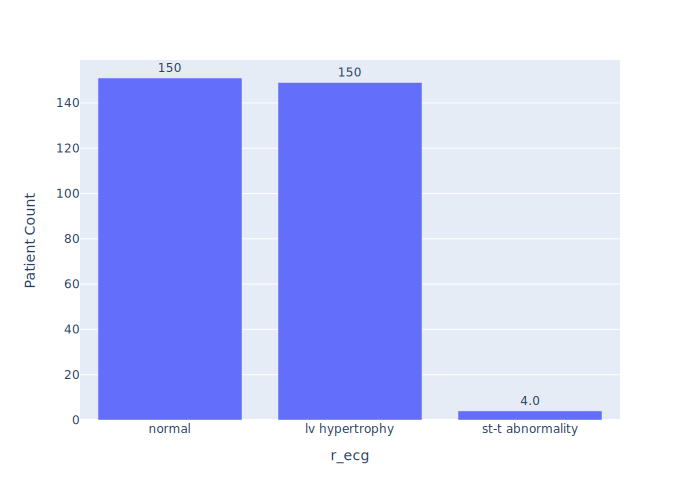

In [ ]:
count_plot(df_new3, 'r_ecg')

Majority of patients are not diabetic

#### plot against diagnosis

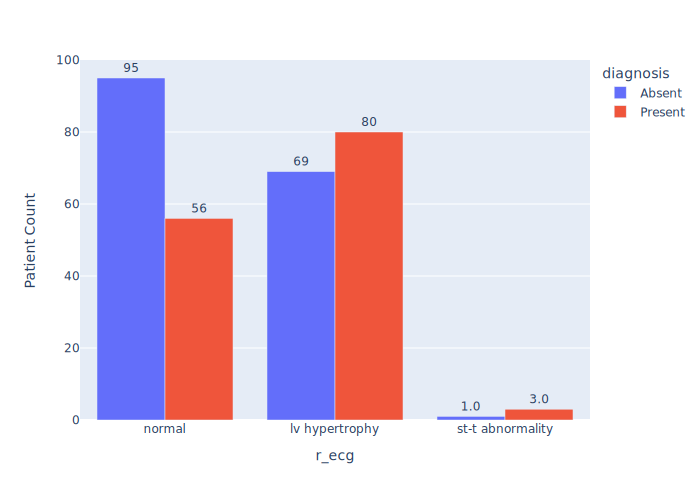

In [ ]:
count_plot(df_new3, 'r_ecg', 'diagnosis')

- Most patients with either a lv hypertrophy or st-t abnormality resting ecg value were diagnosed with heart disease, unlike patients with normal resting ecg which were mostly diagnosed to not have a heart disease

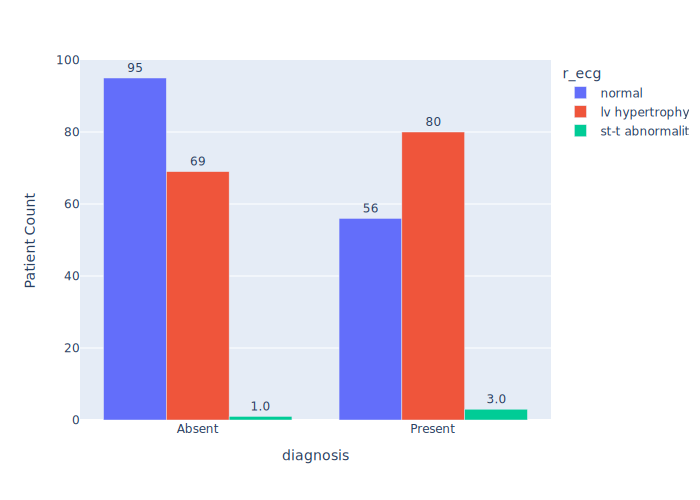

In [ ]:
count_plot(df_new3, 'diagnosis', 'r_ecg')

- Majority of patients with heart disease have the left ventricular (LV) Hypertrophy resting ECG and this comes as no surprise because people with the lv hypertrophy have a higher risk of getting heart disease. [Source](https://my.clevelandclinic.org/health/diseases/21883-left-ventricular-hypertrophy)
- We can also see that majority of the patients with st-t abnormality also experience a heart disease diagnosis, which also comes as no surprise. [Source](https://www.aafp.org/pubs/afp/issues/2000/0215/p1167a.html)

### Maximum heart rate

In [ ]:
df_new3.max_heart_rate.describe()

count    304.000000
mean     149.723684
std       22.927263
min       71.000000
25%      133.750000
50%      153.000000
75%      166.000000
max      202.000000
Name: max_heart_rate, dtype: float64

- Lowest max heart rate level of a patient: 71
- Highest max heart rate level of a patient: 202

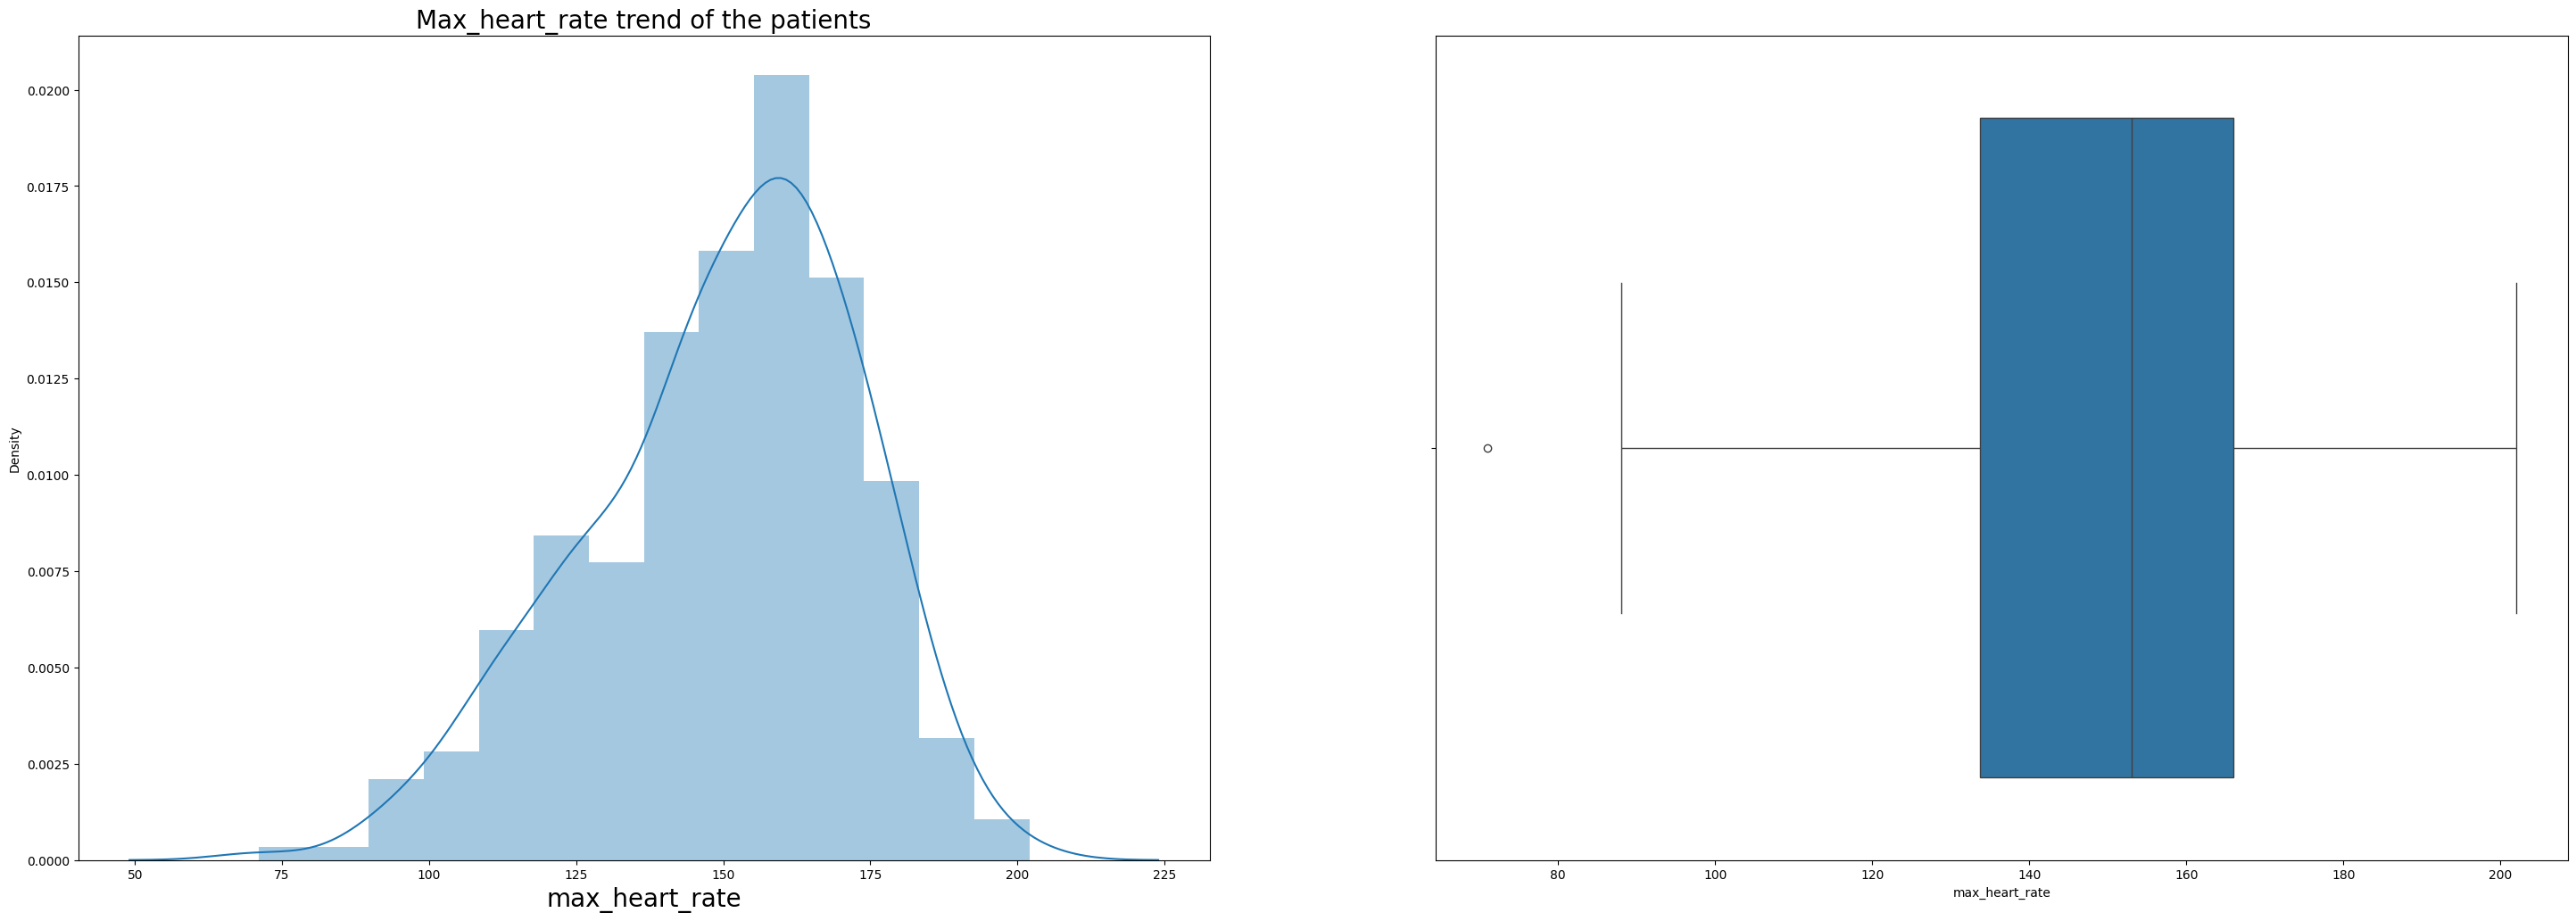

In [ ]:
distribution_plot(df_new3, 'max_heart_rate')

We can see that majority of the patients had max heart rate btw 135-165

#### plot against diagnosis

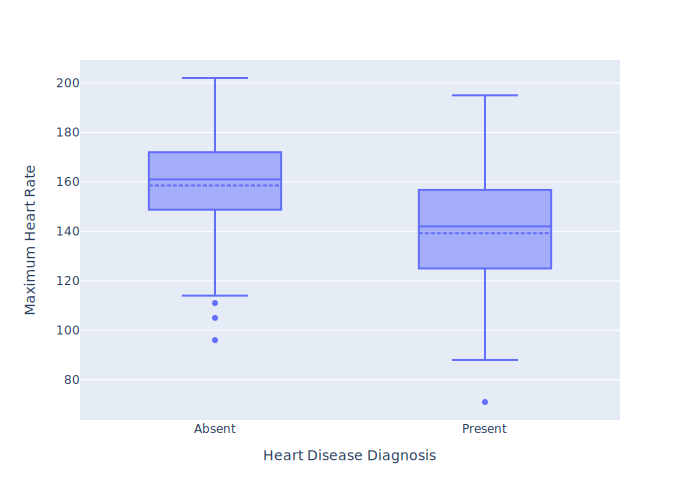

In [ ]:
fig = px.box(df_new3, x="diagnosis", y="max_heart_rate",
            #  category_orders={'diagnosis': ['Absent', 'Mild', 'Moderate', 'Severe', 'Critical']},
             labels=dict(
                 diagnosis='Heart Disease Diagnosis',
                 max_heart_rate='Maximum Heart Rate'))#, color="smoker")
fig.update_traces(boxmean=True)
fig.show('svg')

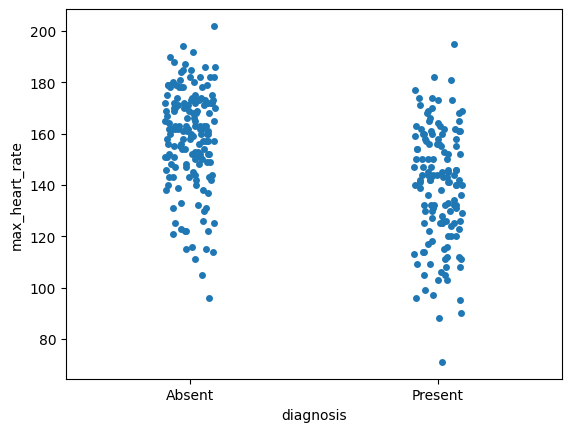

In [ ]:
sns.stripplot(data=df_new3, x='diagnosis', y='max_heart_rate')
plt.show()

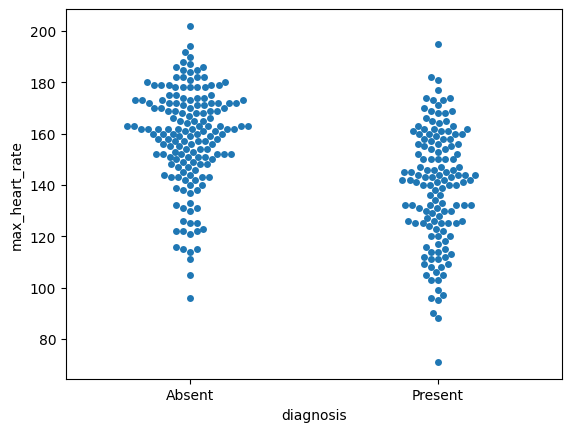

In [ ]:
sns.swarmplot(data=df_new3, x='diagnosis', y='max_heart_rate')
plt.show()

- No clear distinction in max heart rate across all the diagnoses so this feature won't be used as well


In [ ]:
df_new3[['max_heart_rate','diagnosis_encoded']].corr(method='spearman')

,max_heart_rate,diagnosis_encoded
max_heart_rate,1.000000,-0.425948
diagnosis_encoded,-0.425948,1.000000


### Exercised Induced Angina (exang)

In [ ]:
df_new3.exang.value_counts()

False    205
True      99
Name: exang, dtype: int64

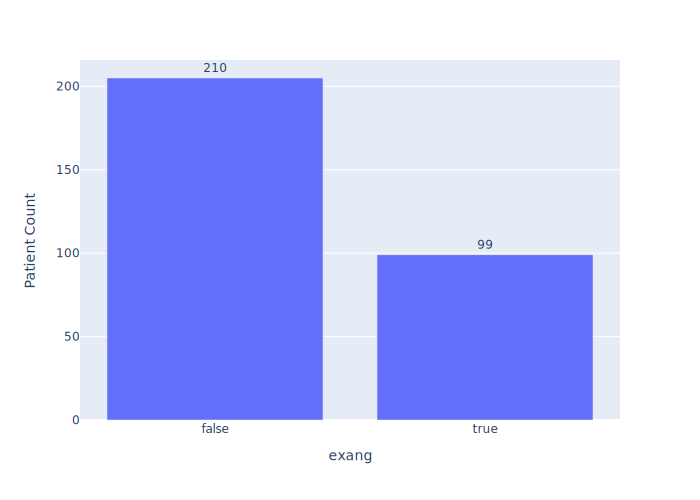

In [ ]:
count_plot(df_new3, 'exang')

Majority of patients don't have exercised induced angina

#### plot against diagnosis

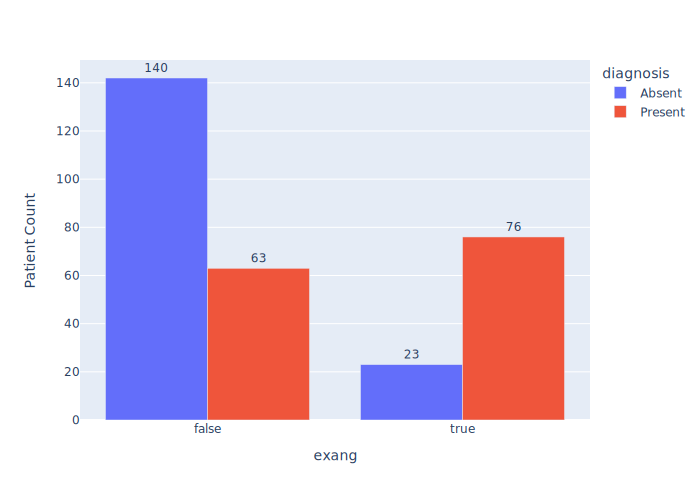

In [ ]:
count_plot(df_new3, 'exang', 'diagnosis')

- Majority of patients with exercised induced angina are diagnosed with heart disease in comparison to patients without it

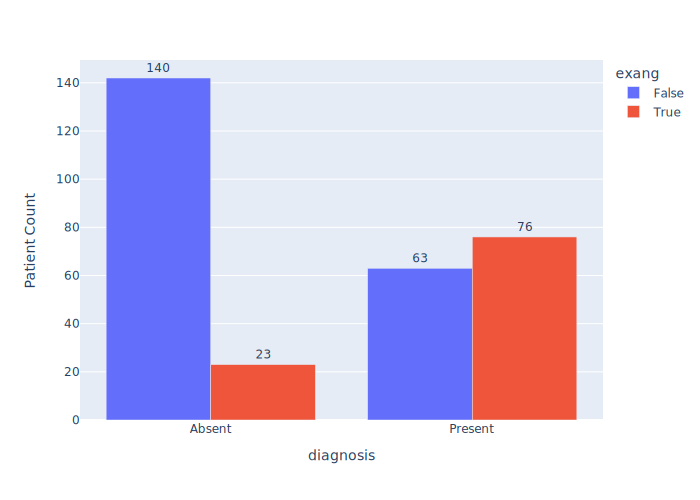

In [ ]:
count_plot(df_new3, 'diagnosis', 'exang')

- Majority of patients diagnosed with heart disease have exercise iduced angina in comparison patients without heart disease

### ST Depression

In [ ]:
df_new3.st_depression.describe()

count    304.000000
mean       1.036184
std        1.160690
min        0.000000
25%        0.000000
50%        0.800000
75%        1.600000
max        6.200000
Name: st_depression, dtype: float64

- ranges btw 0 and 6.2

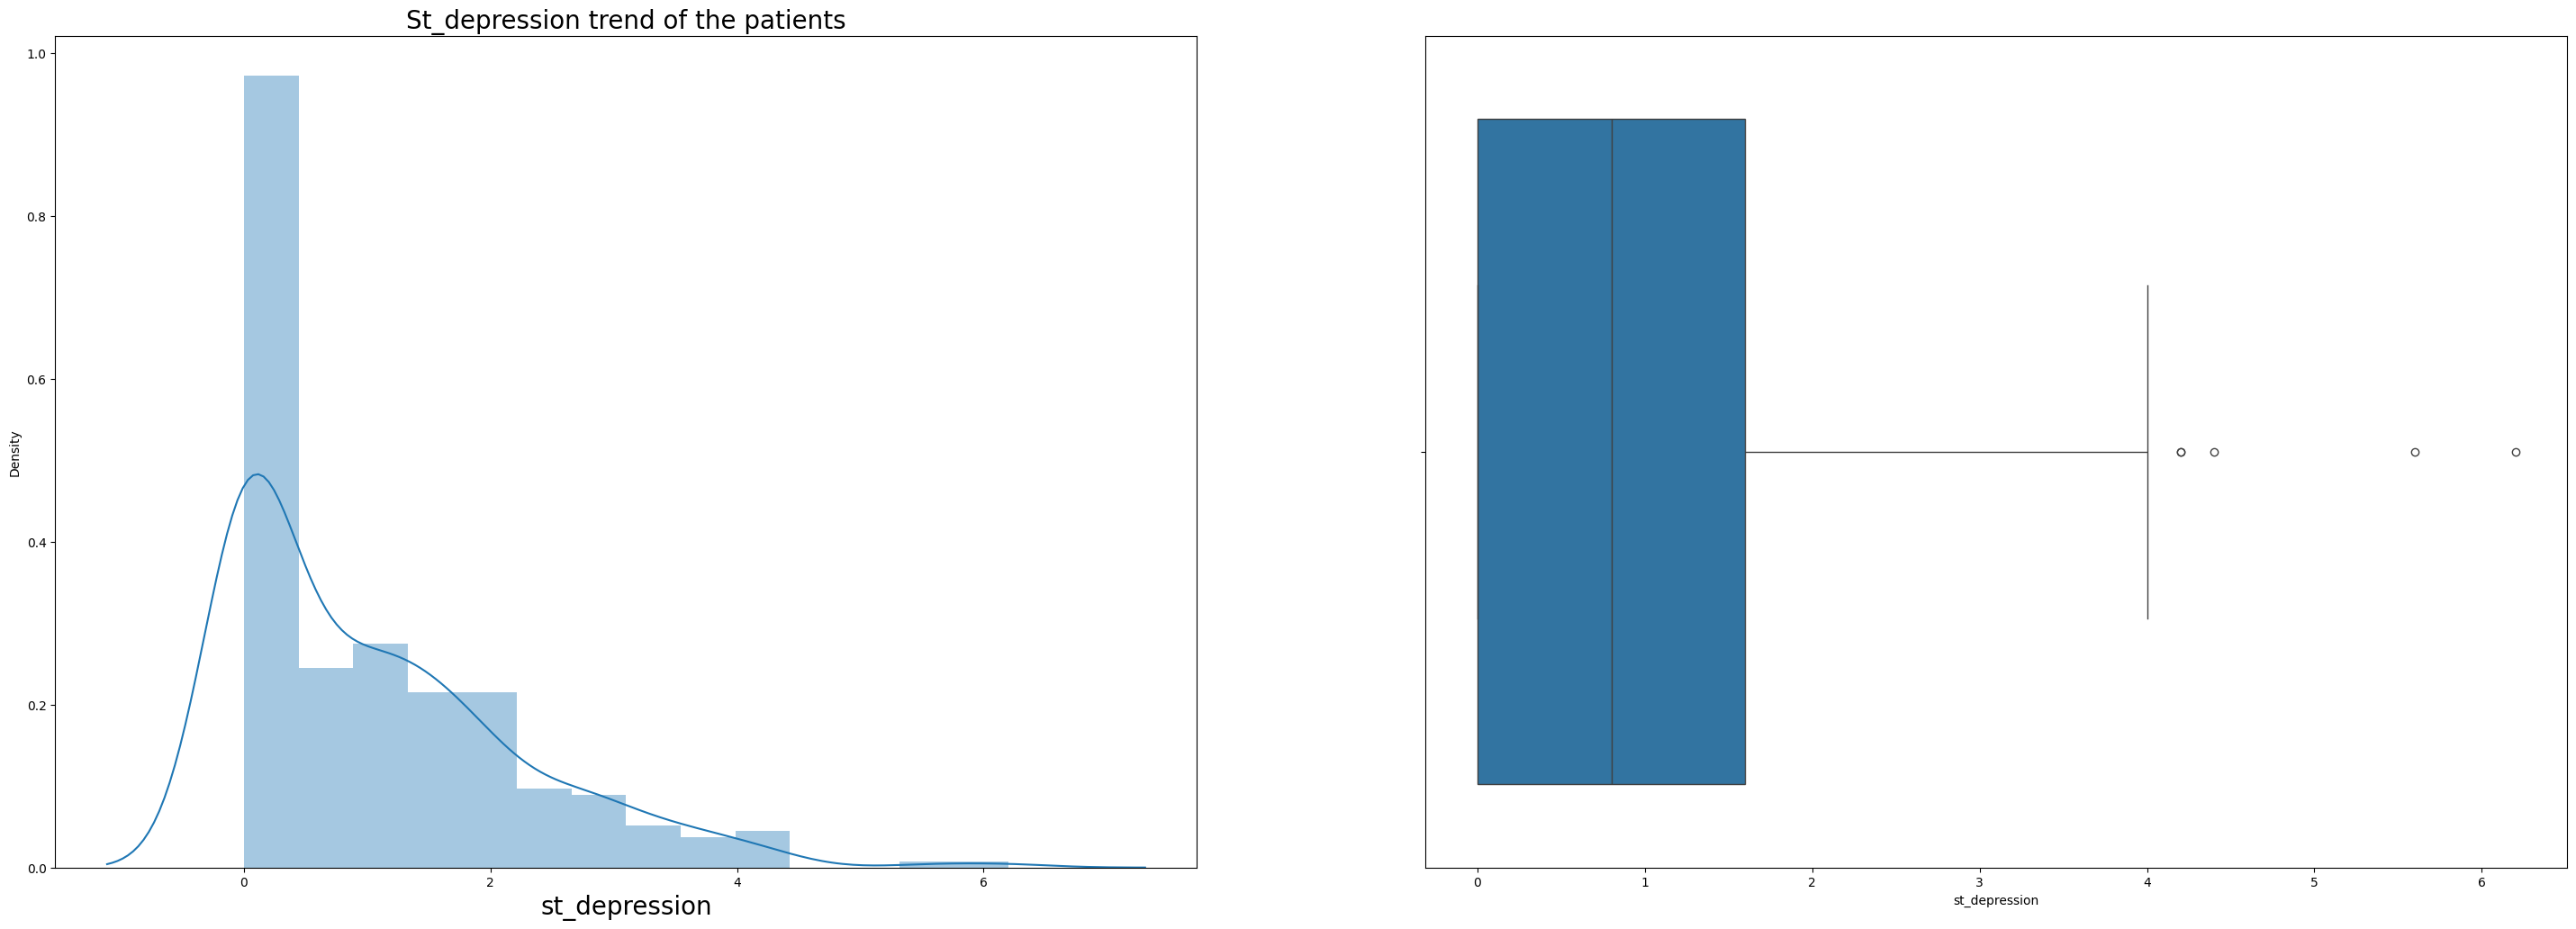

In [ ]:
distribution_plot(df_new3, 'st_depression')

We can see that majority of the patients had st depression btw 0 and 2

#### plot against diagnosis

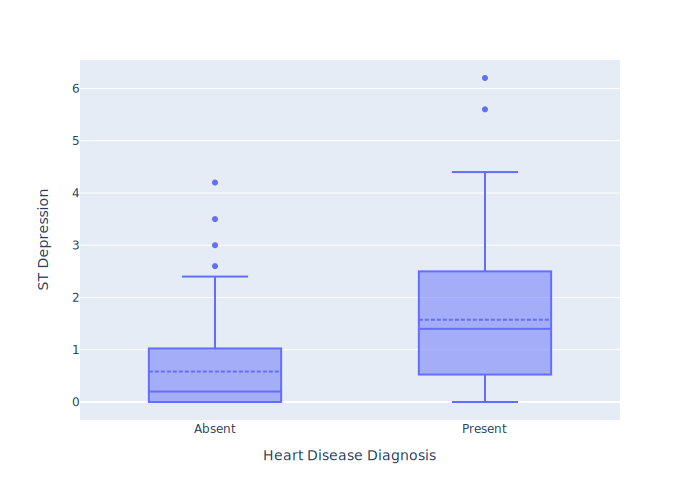

In [ ]:
fig = px.box(df_new3, x="diagnosis", y="st_depression",
            #  category_orders={'diagnosis': ['Absent', 'Mild', 'Moderate', 'Severe', 'Critical']},
             labels=dict(
                 diagnosis='Heart Disease Diagnosis',
                 st_depression='ST Depression'))#, color="smoker")
fig.update_traces(boxmean=True)
fig.show('svg')

- Patients without heart disease have majority of their st depression values btw 0 and 1, with a median of 0.2
- Patients with heart disease have majority of their st depression values btw 0.5 and 2.5 with a median of 1.4


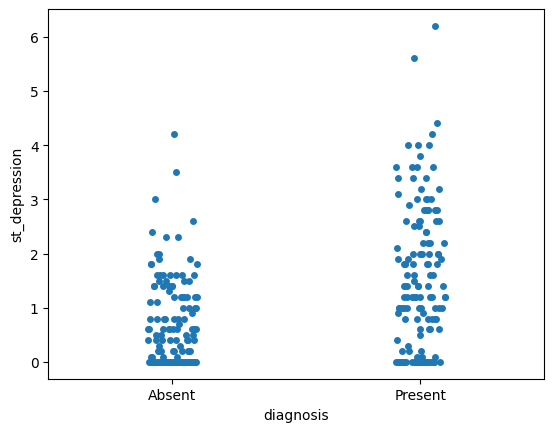

In [ ]:
sns.stripplot(data=df_new3, x='diagnosis', y='st_depression')
plt.show()

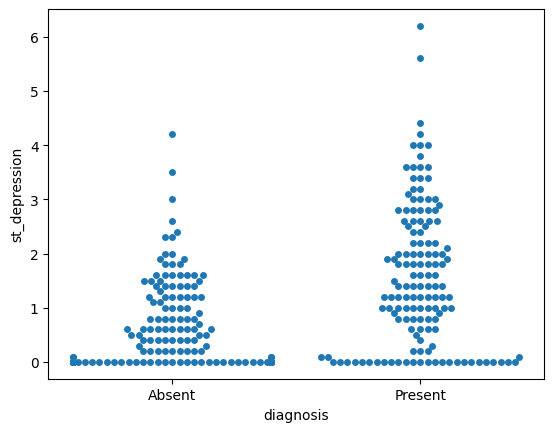

In [ ]:
sns.swarmplot(data=df_new3, x='diagnosis', y='st_depression')
plt.show()

### Slope

In [ ]:
df_new3.slope.value_counts()

upsloping      143
flat           140
downsloping     21
Name: slope, dtype: int64

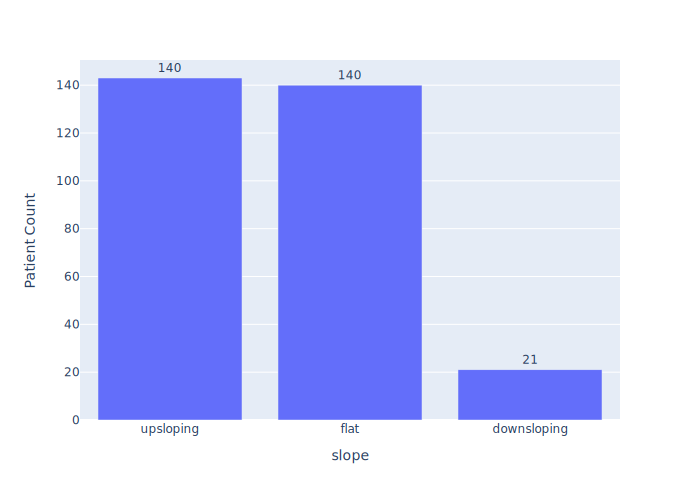

In [ ]:
count_plot(df_new3, 'slope')

Majority of patients either have unsloping / flat slope

#### plot against diagnosis

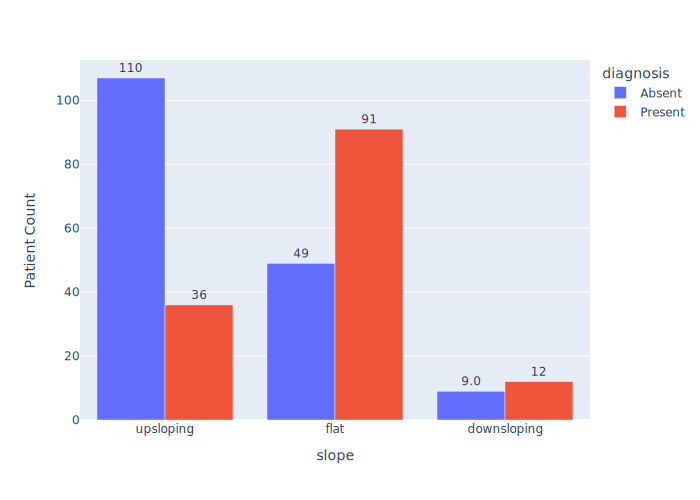

In [ ]:
count_plot(df_new3, 'slope', 'diagnosis')

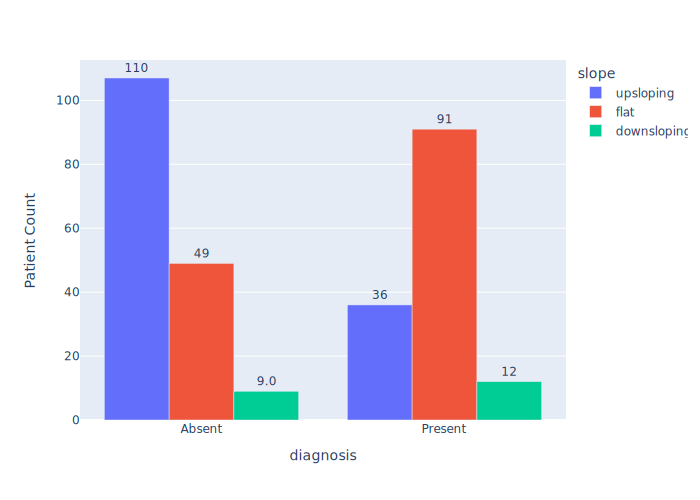

In [ ]:
count_plot(df_new3, 'diagnosis', 'slope')

- Majority of patients diagnosed with heart disease have a flat slope value while majority of patients without heart disease have an upsloping slope
- More patients were diagnosed with heart disease when the slope was flat or downsloping

### No of vessels

In [ ]:
df_new3.no_of_vessels.value_counts()

0.0    181
1.0     65
2.0     38
3.0     20
Name: no_of_vessels, dtype: int64

In [ ]:
df_new3['no_of_vessels_str'] = df_new3.no_of_vessels.astype(int).astype(str)
df_new3.no_of_vessels_str.value_counts()

0    181
1     65
2     38
3     20
Name: no_of_vessels_str, dtype: int64

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                304 non-null    int64  
 1   sex                304 non-null    object 
 2   cp_type            304 non-null    object 
 3   r_bp               304 non-null    float64
 4   chol               304 non-null    float64
 5   is_diabetic        304 non-null    object 
 6   r_ecg              304 non-null    object 
 7   max_heart_rate     304 non-null    float64
 8   exang              304 non-null    object 
 9   st_depression      304 non-null    float64
 10  slope              304 non-null    object 
 11  no_of_vessels      304 non-null    float64
 12  thallium           304 non-null    object 
 13  diagnosis          304 non-null    object 
 14  diagnosis_encoded  304 non-null    int64  
 15  sex_encoded        304 non-null    int64  
 16  no_of_vessels_str  304 non

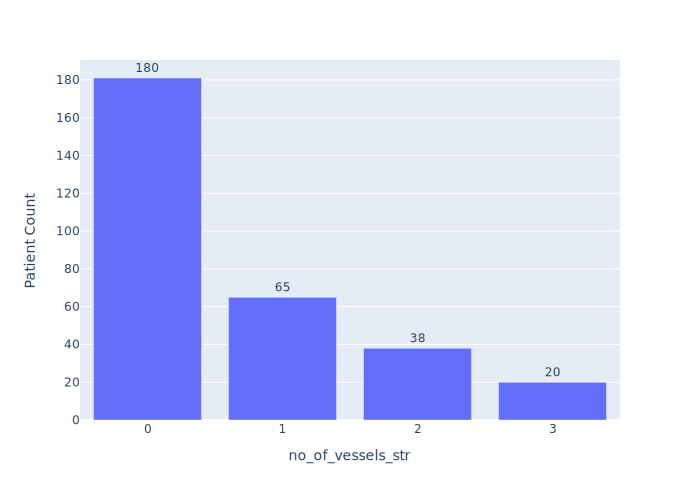

In [ ]:
count_plot(df_new3, 'no_of_vessels_str')

Majority of patients either have 0 vessels

#### plot against diagnosis

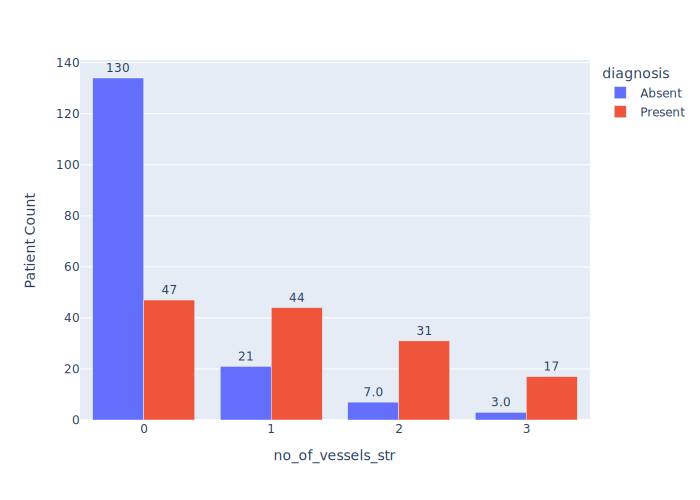

In [ ]:
count_plot(df_new3, 'no_of_vessels_str', 'diagnosis')

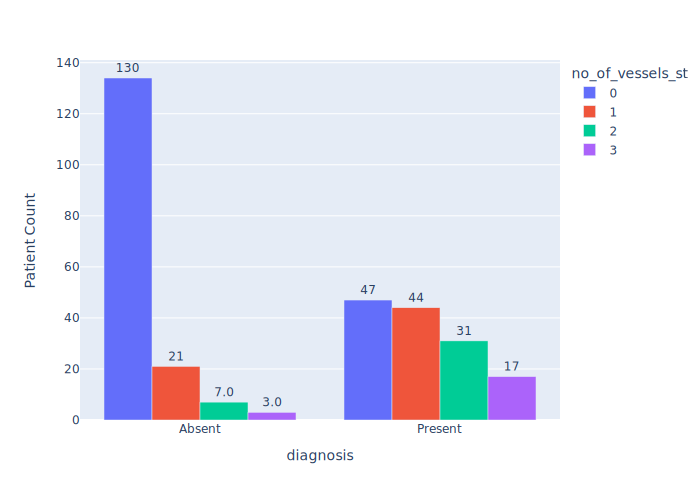

In [ ]:
count_plot(df_new3, 'diagnosis', 'no_of_vessels_str')

- Most patients without the heart disease had no vessel colored by flourosopy
- As the number of vessels increased, we had more patients diagnosed with a heart disease

### Thallium

In [ ]:
df_new3.thallium.value_counts()

normal               168
reversable defect    118
fixed defect          18
Name: thallium, dtype: int64

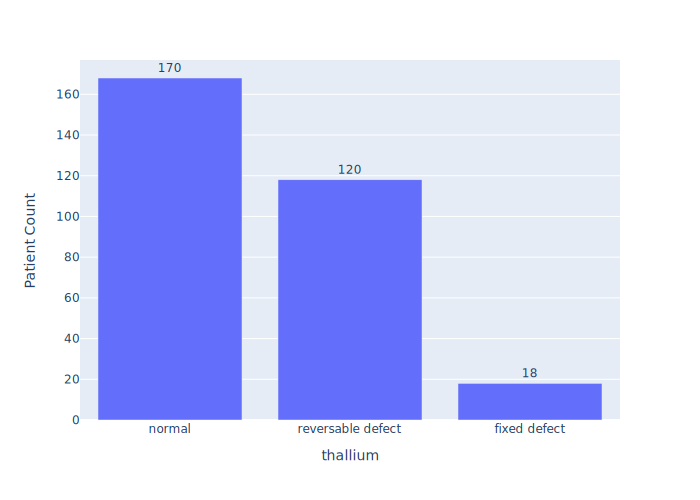

In [ ]:
count_plot(df_new3, 'thallium')

Majority of patients either have normal/reversable defect

#### plot against diagnosis

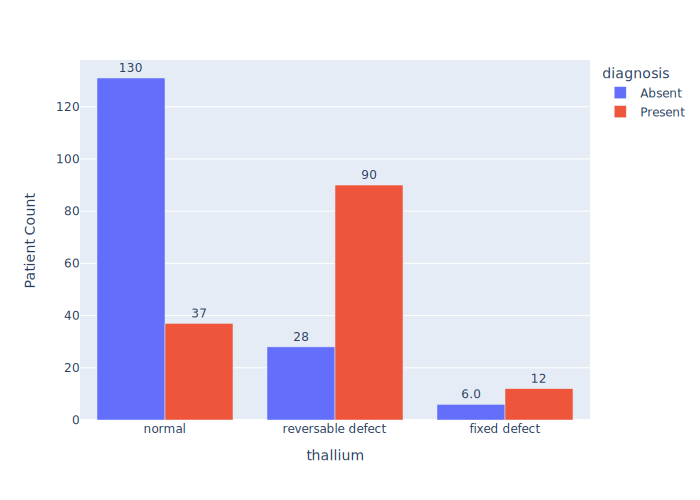

In [ ]:
count_plot(df_new3, 'thallium', 'diagnosis')

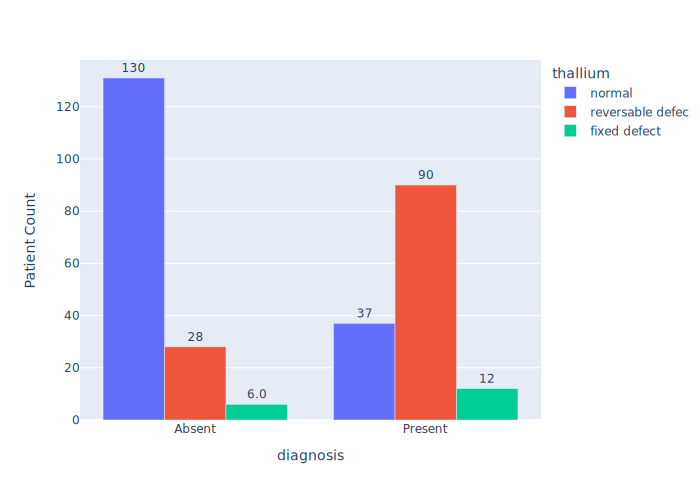

In [ ]:
count_plot(df_new3, 'diagnosis', 'thallium')

- Most patients without the heart disease had ***normal*** thallium with a few having reversable and fixed defects
- Most patients with the heart disease had ***reversable defect*** thallium
- More patients are diagnosed with heart diesease when the thallium was either a reversable defect or fixed defect

## Baseline Model (using all features)

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                304 non-null    int64  
 1   sex                304 non-null    object 
 2   cp_type            304 non-null    object 
 3   r_bp               304 non-null    float64
 4   chol               304 non-null    float64
 5   is_diabetic        304 non-null    object 
 6   r_ecg              304 non-null    object 
 7   max_heart_rate     304 non-null    float64
 8   exang              304 non-null    object 
 9   st_depression      304 non-null    float64
 10  slope              304 non-null    object 
 11  no_of_vessels      304 non-null    float64
 12  thallium           304 non-null    object 
 13  diagnosis          304 non-null    object 
 14  diagnosis_encoded  304 non-null    int64  
 15  sex_encoded        304 non-null    int64  
 16  no_of_vessels_str  304 non

In [ ]:
X_base = df_new3.drop(['diagnosis_encoded','diagnosis','sex_encoded','no_of_vessels_str'],axis=1)
y_base = df_new3[['diagnosis_encoded']]

In [ ]:
X_base[:5]

,age,sex,cp_type,r_bp,chol,is_diabetic,r_ecg,max_heart_rate,exang,st_depression,slope,no_of_vessels,thallium
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [ ]:
y_base[:5]

,diagnosis_encoded
0,0
1,1
2,1
3,0
4,0


In [ ]:
# split train into train and validation
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.2, random_state=42, stratify=y_base)
print('Train set: ', X_train_base.shape, y_train_base.shape)
print('Test set: ', X_test_base.shape, y_test_base.shape)

Train set:  (243, 13) (243, 1)
Test set:  (61, 13) (61, 1)


### encoding/scaling

Apply one-hot encoding to all categorical variables since none of them have a specific order/rank

In [ ]:
cat_cols_base  = X_train_base.select_dtypes(include='object').columns.tolist()
cat_cols_base

['sex', 'cp_type', 'is_diabetic', 'r_ecg', 'exang', 'slope', 'thallium']

In [ ]:
cat_transformer_base = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols_base)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(cat_transformer_base.fit_transform(X_train_base).shape)
cat_transformer_base.fit_transform(X_train_base)[:10]

(243, 18)


array([[  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,
          0. ,   0. ,   1. ,  59. , 170. , 326. , 140. ,   3.4,   0. ],
       [  1. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,
          1. ,   1. ,   0. ,  55. , 130. , 262. , 155. ,   0. ,   0. ],
       [  0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,
          1. ,   1. ,   0. ,  54. , 132. , 288. , 159. ,   0. ,   1. ],
       [  1. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,
          1. ,   0. ,   1. ,  54. , 108. , 309. , 156. ,   0. ,   0. ],
       [  1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,
          0. ,   0. ,   1. ,  69. , 140. , 254. , 146. ,   2. ,   3. ],
       [  1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,   0. ,
          1. ,   0. ,   1. ,  48. , 130. , 256. , 150. ,   0. ,   2. ],
       [  1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,   1. ,
          0. ,   0. ,   1. ,  54. , 124. , 266. , 109. ,   2.2,   1. ],

In [ ]:
preprocess_pipeline_std_base = Pipeline(steps=[
    ('cat_transformer', cat_transformer_base),
    ('scaler', StandardScaler())
])
# viewing the effect of the one hot encoding and scaling to mean of 0 and std of 1
print(preprocess_pipeline_std_base.fit_transform(X_train_base).shape)
preprocess_pipeline_std_base.fit_transform(X_train_base)[:10]

(243, 18)


array([[ 0.68755165, -0.4571162 , -0.61699418, -0.29124119, -0.41702883,
        -1.02923371, -0.06428243,  1.44081552, -0.90943261, -0.96362411,
        -1.12739879,  1.23743687,  0.50962109,  2.22095143,  1.43611472,
        -0.4346122 ,  2.14965615, -0.68762195],
       [ 0.68755165,  2.18762755, -0.61699418, -0.29124119, -0.41702883,
         0.97159662, -0.06428243, -0.69405138, -0.90943261,  1.03774904,
         0.88699758, -0.80812204,  0.06416093, -0.06176485,  0.21871277,
         0.22518017, -0.88631976, -0.68762195],
       [-1.45443618,  2.18762755, -0.61699418, -0.29124119,  2.39791576,
        -1.02923371, -0.06428243,  1.44081552, -0.90943261,  1.03774904,
         0.88699758, -0.80812204, -0.04720411,  0.05237096,  0.71328231,
         0.4011248 , -0.88631976,  0.44905923],
       [ 0.68755165,  2.18762755, -0.61699418, -0.29124119, -0.41702883,
         0.97159662, -0.06428243, -0.69405138, -0.90943261,  1.03774904,
        -1.12739879,  1.23743687, -0.04720411, -1.317

- Alternative preprocessing steps

In [ ]:
# using MinMax Scaler
preprocess_pipeline_minmax_base = Pipeline(steps=[
    ('cat_transformer', cat_transformer_base),
    ('scaler', MinMaxScaler())
])
# viewing the effect of the one hot encoding
print(preprocess_pipeline_minmax_base.fit_transform(X_train_base).shape)
preprocess_pipeline_minmax_base.fit_transform(X_train_base)[:10]

(243, 18)


array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.625     , 0.71698113, 0.456621  ,
        0.52671756, 0.5483871 , 0.        ],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.54166667, 0.33962264, 0.31050228,
        0.64122137, 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 0.52083333, 0.35849057, 0.36986301,
        0.67175573, 0.        , 0.33333333],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.52083333, 0.13207547, 0.41780822,
        0.64885496, 0.        , 0.        ],
    

In [ ]:
# using standard scaler for only numerical features
num_cols_base = list(set(X_train_base.columns.tolist()) - set(X_train_base.select_dtypes(include='object').columns.tolist()))
preprocess_pipeline_sep_std_base = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train_base.select_dtypes(include='object').columns.tolist()),
     ('numerical', StandardScaler(), num_cols_base)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_std_base.fit_transform(X_train_base).shape)
preprocess_pipeline_sep_std_base.fit_transform(X_train_base)[:10]

(243, 18)


array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  1.43611472, -0.68762195,  0.50962109,
         2.14965615,  2.22095143, -0.4346122 ],
       [ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.21871277, -0.68762195,  0.06416093,
        -0.88631976, -0.06176485,  0.22518017],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.71328231,  0.44905923, -0.04720411,
        -0.88631976,  0.05237096,  0.4011248 ],
       [ 1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  1.        ,  1.11274233, -0.687

In [ ]:
# using minmax scaler for only numerical features
preprocess_pipeline_sep_minmax_base = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train_base.select_dtypes(include='object').columns.tolist()),
     ('numerical', MinMaxScaler(), num_cols_base)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_minmax_base.fit_transform(X_train_base).shape)
preprocess_pipeline_sep_minmax_base.fit_transform(X_train_base)[:10]

(243, 18)


array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 1.        , 0.456621  , 0.        , 0.625     ,
        0.5483871 , 0.71698113, 0.52671756],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.31050228, 0.        , 0.54166667,
        0.        , 0.33962264, 0.64122137],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 1.        ,
        1.        , 0.        , 0.36986301, 0.33333333, 0.52083333,
        0.        , 0.35849057, 0.67175573],
       [1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.41780822, 0.        , 0.52083333,
        0.        , 0.13207547, 0.64885496],
    

### hyperparam search (Accuracy)

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std_base_acc = hyperparam_tuner_acc(preprocess_pipeline_std_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_minmax_base_acc = hyperparam_tuner_acc(preprocess_pipeline_minmax_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_sep_std_base_acc = hyperparam_tuner_acc(preprocess_pipeline_sep_std_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                 

In [ ]:
model_preprocess_pipeline_sep_minmax_base_acc = hyperparam_tuner_acc(preprocess_pipeline_sep_minmax_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                   

### best model pred (Accuracy)

- Using the best estimator_  would give the best model to call predictions with since refit is set to True by default.

This is the equivalent of retraining a new model with the best_params_

In [ ]:
best_pipeline_base_acc, best_estimator_base_acc = get_best_estimator(model_preprocess_pipeline_std_base_acc, model_preprocess_pipeline_minmax_base_acc, model_preprocess_pipeline_sep_std_base_acc, model_preprocess_pipeline_sep_minmax_base_acc)
pprint(best_estimator_base_acc)
best_estimator_base_acc

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
                 RandomForestClassifier(max_depth=2, min_samples_split=3))])

In [ ]:
pd.DataFrame(best_pipeline_base_acc.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
89,0.292874,0.007497,0.030299,0.002550,NaN,NaN,100,NaN,2,NaN,...,sqrt,gini,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.819672,0.809917,0.814795,0.004877,1
23,0.259642,0.001621,0.018597,0.001878,NaN,NaN,250,NaN,3,1,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 250, 'estimator__m...",0.860656,0.768595,0.814625,0.046030,2
36,4.428129,0.262750,0.196776,0.012422,NaN,NaN,1000,NaN,4,NaN,...,sqrt,gini,NaN,NaN,"{'estimator__n_estimators': 1000, 'estimator__...",0.811475,0.809917,0.810696,0.000779,3
98,0.078868,0.003072,0.015620,0.000817,NaN,NaN,50,NaN,3,0.1,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.819672,0.801653,0.810663,0.009010,4
55,0.279832,0.003418,0.025900,0.001068,NaN,NaN,100,NaN,2,NaN,...,sqrt,log_loss,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.811475,0.801653,0.806564,0.004911,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,0.033112,0.009764,0.000000,0.000000,1.0,multi:softmax,250,1,5,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
61,0.024272,0.000703,0.000000,0.000000,0.8,multi:softmax,10,1,4,1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.8, 'estimator__obje...",NaN,NaN,NaN,NaN,70
62,0.024757,0.000528,0.000000,0.000000,0.6,multi:softmax,400,10,2,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70
83,0.024190,0.000436,0.000000,0.000000,0.6,multi:softprob,50,1,3,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70


In [ ]:
# get prediction
y_pred_base_acc = best_estimator_base_acc.predict(X_test_base)

In [ ]:
y_pred_base_acc

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1])

#### Evaluation

In [ ]:
evaluate(y_test_base, y_pred_base_acc)


Accuracy: 0.8525
Precision: 0.8276
Recall: 0.8571
F1 Score: 0.8421
ROC AUC: 0.8528



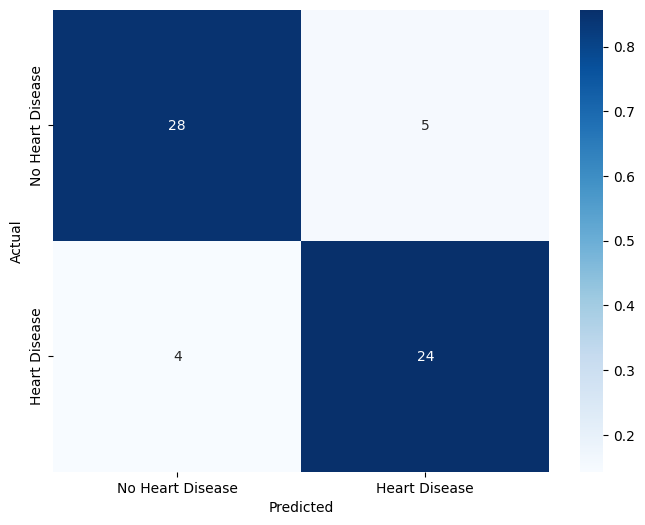

In [ ]:
confusion_matrix_plot(y_test_base, y_pred_base_acc)

- We can see that the model is more robust to preventing false negatives (Type II error) than false positives because the it performed better on the recall metric than precision.
- These false positives can be costly on the user experience because our system would be more likely to tell a user that they have a heart disease when they don't which means the user would've wasted money on potentially prescribed drug medications / clinical trials when they are indeed healthy.

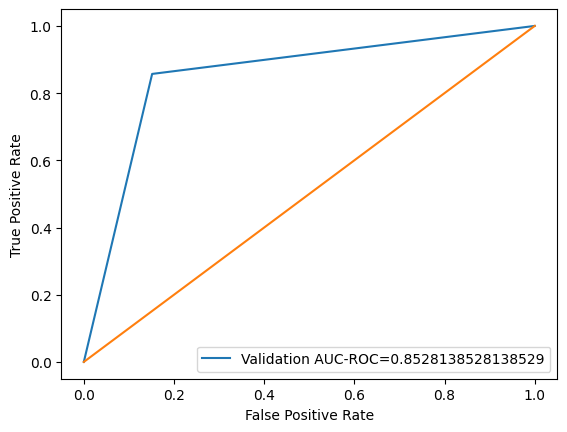

In [ ]:
fpr, tpr, _ = roc_curve(y_test_base, y_pred_base_acc)
auc = roc_auc_score(y_test_base, y_pred_base_acc)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### hyperparam search (F1 Score)

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std_base_f1 = hyperparam_tuner_f1(preprocess_pipeline_std_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_minmax_base_f1 = hyperparam_tuner_f1(preprocess_pipeline_minmax_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['sex',
                                                                    'cp_type',
                                                                    'is_diabetic',
                                                                    'r_ecg',
                                                                    'exang',
               

In [ ]:
model_preprocess_pipeline_sep_std_base_f1 = hyperparam_tuner_f1(preprocess_pipeline_sep_std_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                 

In [ ]:
model_preprocess_pipeline_sep_minmax_base_f1 = hyperparam_tuner_f1(preprocess_pipeline_sep_minmax_base, X_train_base, y_train_base)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                   

### best model pred (F1 Score)

- Using the best estimator_  would give the best model to call predictions with since refit is set to True by default.

This is the equivalent of retraining a new model with the best_params_

In [ ]:
best_pipeline_base_f1, best_estimator_base_f1 = get_best_estimator(model_preprocess_pipeline_std_base_f1, model_preprocess_pipeline_minmax_base_f1, model_preprocess_pipeline_sep_std_base_f1, model_preprocess_pipeline_sep_minmax_base_f1)
pprint(best_estimator_base_f1)
best_estimator_base_f1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
   

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['sex', 'cp_type',
                                                   'is_diabetic', 'r_ecg',
                                                   'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['chol', 'no_of_vessels',
                                                   'age', 'st_depression',
                                                   'r_bp',
                                                   'max_heart_rate'])])),
                ('estimator',
                 GradientBoostingClassifier(criterion='squared_error',
                                            learning_rate=1,
                                            max_features='log2',
                                            min_samples_leaf=6,
                                            n_estimators=250))])

In [ ]:
pd.DataFrame(best_pipeline_base_f1.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
23,0.275115,0.008263,0.024641,0.001166,NaN,NaN,250,NaN,3,1,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 250, 'estimator__m...",0.830508,0.750000,0.790254,0.040254,1
55,0.264230,0.010223,0.032154,0.000927,NaN,NaN,100,NaN,2,NaN,...,sqrt,log_loss,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.814159,0.764706,0.789433,0.024727,2
85,0.482659,0.003881,0.035744,0.006871,NaN,NaN,400,NaN,3,0.1,...,log2,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 400, 'estimator__m...",0.810345,0.760000,0.785172,0.025172,3
36,4.830457,0.093652,0.226853,0.028450,NaN,NaN,1000,NaN,4,NaN,...,sqrt,gini,NaN,NaN,"{'estimator__n_estimators': 1000, 'estimator__...",0.800000,0.769231,0.784615,0.015385,4
89,0.368465,0.107712,0.053641,0.019700,NaN,NaN,100,NaN,2,NaN,...,sqrt,gini,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.803419,0.757282,0.780350,0.023069,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0.026526,0.002142,0.000000,0.000000,0.6,multi:softprob,250,5,4,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70
25,0.028217,0.002598,0.000000,0.000000,1.0,multi:softprob,100,1,1,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
48,0.038838,0.014956,0.000000,0.000000,1.0,multi:softmax,250,1,2,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
17,0.028717,0.003258,0.000000,0.000000,0.6,multi:softprob,50,10,2,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70


In [ ]:
# get prediction
y_pred_base_f1 = best_estimator_base_f1.predict(X_test_base)

In [ ]:
y_pred_base_f1

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1])

#### Evaluation

In [ ]:
evaluate(y_test_base, y_pred_base_f1)


Accuracy: 0.8525
Precision: 0.7879
Recall: 0.9286
F1 Score: 0.8525
ROC AUC: 0.8582



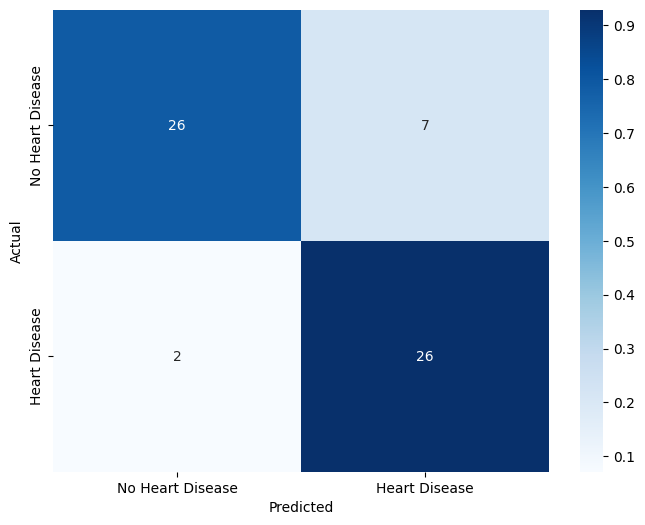

In [ ]:
confusion_matrix_plot(y_test_base, y_pred_base_f1)

##### Baseline Insights
- Focusing the model on the f1 score in the hyperparameter tuning gives us a model with more false positives but lesser false negatices. This is why the recall improves drastically, but the precision further declines.

- Striking a balance between what we want our model to optimize for can be challenging and majorly depends on the company using the system and their overarching goals, but generally speaking, most companies want their users to have trust in them and this trust/user experience can decline more with an increase in false negatives because you told them they were healthy when infact, they have heart disease and should be getting treatment immediately.

- The false positives on the other hand can equally reduce the users trust because they would've started treatment and wasted money/resources when they are in fact healthy, and one cannot say what side effects the treatment might have on a healthy person before they find out that they are healthy (hoping they do), so the false positives also has its issues.

- However, the false negatives is more costly for the users wellbeing and the reliability/trust of our system to the common man. Hence, this f1 hyperparam search produced a more effective model for us.

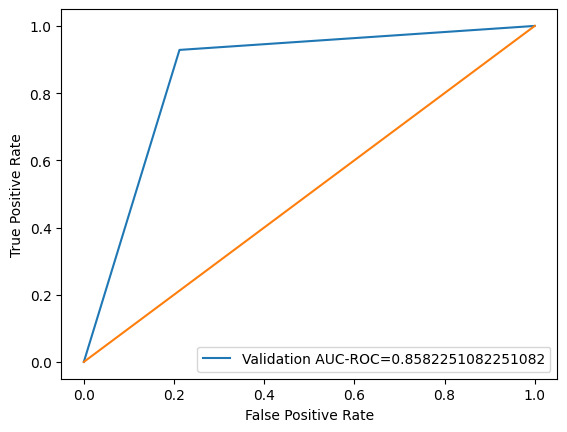

In [ ]:
fpr, tpr, _ = roc_curve(y_test_base, y_pred_base_f1)
auc = roc_auc_score(y_test_base, y_pred_base_f1)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

## Model using Feature Selection from EDA

In [ ]:
df_new3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 303
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                304 non-null    int64  
 1   sex                304 non-null    object 
 2   cp_type            304 non-null    object 
 3   r_bp               304 non-null    float64
 4   chol               304 non-null    float64
 5   is_diabetic        304 non-null    object 
 6   r_ecg              304 non-null    object 
 7   max_heart_rate     304 non-null    float64
 8   exang              304 non-null    object 
 9   st_depression      304 non-null    float64
 10  slope              304 non-null    object 
 11  no_of_vessels      304 non-null    float64
 12  thallium           304 non-null    object 
 13  diagnosis          304 non-null    object 
 14  diagnosis_encoded  304 non-null    int64  
 15  sex_encoded        304 non-null    int64  
 16  no_of_vessels_str  304 non

In [ ]:
# selecting most important features from eda
X = df_new3[['age','cp_type','exang','st_depression','slope','no_of_vessels','thallium']]
y = df_new3[['diagnosis_encoded']]

In [ ]:
X[:5]

,age,cp_type,exang,st_depression,slope,no_of_vessels,thallium
0,63,typical angina,False,2.3,downsloping,0.0,fixed defect
1,67,asymptomatic,True,1.5,flat,3.0,normal
2,67,asymptomatic,True,2.6,flat,2.0,reversable defect
3,37,non-anginal,False,3.5,downsloping,0.0,normal
4,41,atypical angina,False,1.4,upsloping,0.0,normal


In [ ]:
y[:5]

,diagnosis_encoded
0,0
1,1
2,1
3,0
4,0


In [ ]:
# split train into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (243, 7) (243, 1)
Test set:  (61, 7) (61, 1)


### encoding/scaling

Apply one-hot encoding to all categorical variables since none of them have a specific order/rank

In [ ]:
cat_cols  = X_train.select_dtypes(include='object').columns.tolist()
cat_cols

['cp_type', 'exang', 'slope', 'thallium']

In [ ]:
cat_transformer = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(cat_transformer.fit_transform(X_train).shape)
cat_transformer.fit_transform(X_train)[:10]

(243, 11)


array([[ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  1. , 59. ,  3.4,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0. , 55. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  1. ,  0. ,  1. ,  1. ,  0. , 54. ,  0. ,  1. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  1. , 54. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  1. ,  0. ,  0. ,  1. , 69. ,  2. ,  3. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ,  1. ,  0. ,  1. , 48. ,  0. ,  2. ],
       [ 0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. , 54. ,  2.2,  1. ],
       [ 0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. , 43. ,  2.5,  0. ],
       [ 0. ,  1. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0. , 65. ,  0.8,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. , 46. ,  1.8,  2. ]])

In [ ]:
preprocess_pipeline_std = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', StandardScaler())
])
# viewing the effect of the one hot encoding and scaling to mean of 0 and std of 1
print(preprocess_pipeline_std.fit_transform(X_train).shape)
preprocess_pipeline_std.fit_transform(X_train)[:10]

(243, 11)


array([[-0.4571162 , -0.61699418, -0.29124119,  1.44081552, -0.90943261,
        -0.96362411, -1.12739879,  1.23743687,  0.50962109,  2.14965615,
        -0.68762195],
       [ 2.18762755, -0.61699418, -0.29124119, -0.69405138, -0.90943261,
         1.03774904,  0.88699758, -0.80812204,  0.06416093, -0.88631976,
        -0.68762195],
       [ 2.18762755, -0.61699418, -0.29124119,  1.44081552, -0.90943261,
         1.03774904,  0.88699758, -0.80812204, -0.04720411, -0.88631976,
         0.44905923],
       [ 2.18762755, -0.61699418, -0.29124119, -0.69405138, -0.90943261,
         1.03774904, -1.12739879,  1.23743687, -0.04720411, -0.88631976,
        -0.68762195],
       [-0.4571162 ,  1.62076083, -0.29124119, -0.69405138,  1.0995867 ,
        -0.96362411, -1.12739879,  1.23743687,  1.62327151,  0.89954842,
         2.7224216 ],
       [-0.4571162 , -0.61699418, -0.29124119,  1.44081552, -0.90943261,
         1.03774904, -1.12739879,  1.23743687, -0.71539436, -0.88631976,
         1.585

- Alternative preprocessing steps

In [ ]:
# using MinMax Scaler
preprocess_pipeline_minmax = Pipeline(steps=[
    ('cat_transformer', cat_transformer),
    ('scaler', MinMaxScaler())
])
# viewing the effect of the one hot encoding
print(preprocess_pipeline_minmax.fit_transform(X_train).shape)
preprocess_pipeline_minmax.fit_transform(X_train)[:10]

(243, 11)


array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.625     , 0.5483871 ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.54166667, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 0.        , 0.52083333, 0.        ,
        0.33333333],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.52083333, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.83333333, 0.32258065,
        1.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.39583333, 0.        ,
        0.66666667],
       [0.        , 0.        , 0.        , 1.        , 1.

In [ ]:
# using standard scaler for only numerical features
num_cols = list(set(X_train.columns.tolist()) - set(X_train.select_dtypes(include='object').columns.tolist()))
preprocess_pipeline_sep_std = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', StandardScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_std.fit_transform(X_train).shape)
preprocess_pipeline_sep_std.fit_transform(X_train)[:10]

(243, 11)


array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        , -0.68762195,  2.14965615,
         0.50962109],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        , -0.68762195, -0.88631976,
         0.06416093],
       [ 1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.44905923, -0.88631976,
        -0.04720411],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  1.        , -0.68762195, -0.88631976,
        -0.04720411],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  1.        ,  2.7224216 ,  0.89954842,
         1.62327151],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  1.        ,  1.58574042, -0.88631976,
        -0.715

In [ ]:
# using minmax scaler for only numerical features
preprocess_pipeline_sep_minmax = ColumnTransformer(
    [('categorical', OneHotEncoder(drop='first', handle_unknown='ignore'), X_train.select_dtypes(include='object').columns.tolist()),
     ('numerical', MinMaxScaler(), num_cols)],
    remainder='passthrough'
)
# viewing the effect of the one hot encoding
print(preprocess_pipeline_sep_minmax.fit_transform(X_train).shape)
preprocess_pipeline_sep_minmax.fit_transform(X_train)[:10]

(243, 11)


array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.5483871 ,
        0.625     ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        0.54166667],
       [1.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 0.        , 0.33333333, 0.        ,
        0.52083333],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        0.52083333],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 1.        , 0.32258065,
        0.83333333],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        1.        , 0.        , 1.        , 0.66666667, 0.        ,
        0.39583333],
       [0.        , 0.        , 0.        , 1.        , 1.

### hyperparam search (Accuracy)

Using the accuracy hyperparam function rather than f1 score since accuracy gave better results in the baseline model


- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std_acc = hyperparam_tuner_acc(preprocess_pipeline_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('esti

In [ ]:
model_preprocess_pipeline_minmax_acc = hyperparam_tuner_acc(preprocess_pipeline_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', MinMaxScaler())])),
                ('estima

In [ ]:
model_preprocess_pipeline_sep_std_acc = hyperparam_tuner_acc(preprocess_pipeline_sep_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['cp_type', 'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['no_of_vessels',
                                                   'st_depression', 'age'])])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_...


In [ ]:
model_preprocess_pipeline_sep_minmax_acc = hyperparam_tuner_acc(preprocess_pipeline_sep_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['cp_type', 'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['no_of_vessels',
                                                   'st_depression', 'age'])])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_by...


### best model pred (Accuracy)

In [ ]:
best_pipeline_acc, best_estimator_acc = get_best_estimator(model_preprocess_pipeline_std_acc, model_preprocess_pipeline_minmax_acc, model_preprocess_pipeline_sep_std_acc, model_preprocess_pipeline_sep_minmax_acc)
pprint(best_estimator_acc)
best_estimator_acc

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylev...
           

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylev...
                               feature_types=None, gamma=5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logitraw', ...))])

In [ ]:
pd.DataFrame(best_pipeline_acc.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
54,0.200635,0.000651,0.016723,0.001585,0.6,binary:logitraw,1000,1,3,1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",0.827869,0.834711,0.831290,0.003421,1
72,0.075245,0.001122,0.012811,0.001291,NaN,NaN,50,NaN,5,1,...,sqrt,squared_error,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.827869,0.793388,0.810629,0.017240,2
85,0.867457,0.054570,0.028381,0.001605,NaN,NaN,400,NaN,3,0.1,...,log2,friedman_mse,NaN,NaN,"{'estimator__n_estimators': 400, 'estimator__m...",0.836066,0.785124,0.810595,0.025471,3
24,0.155096,0.002238,0.018140,0.000404,NaN,NaN,50,NaN,3,NaN,...,None,entropy,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.811475,0.801653,0.806564,0.004911,4
21,0.097276,0.006596,0.013246,0.000747,NaN,NaN,50,NaN,3,0.1,...,None,squared_error,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.811475,0.801653,0.806564,0.004911,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50,0.018715,0.001613,0.000000,0.000000,1.0,multi:softmax,250,1,5,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
61,0.018092,0.000152,0.000000,0.000000,0.8,multi:softmax,10,1,4,1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.8, 'estimator__obje...",NaN,NaN,NaN,NaN,70
62,0.018461,0.000642,0.000000,0.000000,0.6,multi:softmax,400,10,2,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70
83,0.038359,0.000098,0.000000,0.000000,0.6,multi:softprob,50,1,3,10,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70


In [ ]:
# get prediction
y_pred_acc = best_estimator_acc.predict(X_test)

In [ ]:
y_pred_acc

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1])

#### Evaluation

In [ ]:
evaluate(y_test, y_pred_acc)


Accuracy: 0.9016
Precision: 0.8438
Recall: 0.9643
F1 Score: 0.9000
ROC AUC: 0.9064



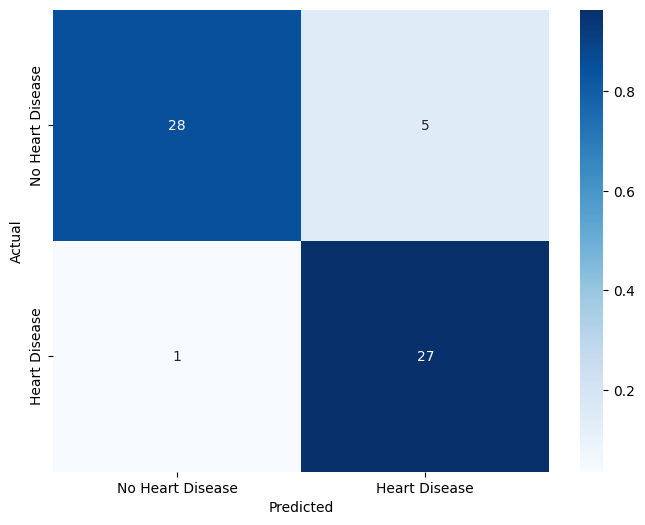

In [ ]:
confusion_matrix_plot(y_test, y_pred_acc)

##### Feature Selection Insights

Feature selection helped the model have a better chance at predicting the heart disease (made the model more precise and reduced chances of false alarms)
- false positives reduced
- true positives increased

Naturally, we want our system to not just provide a better experience for the users in terms of reduction of false alarms/scares, but majorly in terms of the systems efficiency and the users safety by ensuring that the system doesn't predict a user to be healthy when they have heart disease as this would be more costly on the users health and well-being.

Optimizing this in the model is where the recall metric comes in and where we want to minimize the false negatives since they are more costly to any organization trying to utilize this system. From this new model, we can see that;
- the false negatives are reduced
- the true negatives also increased


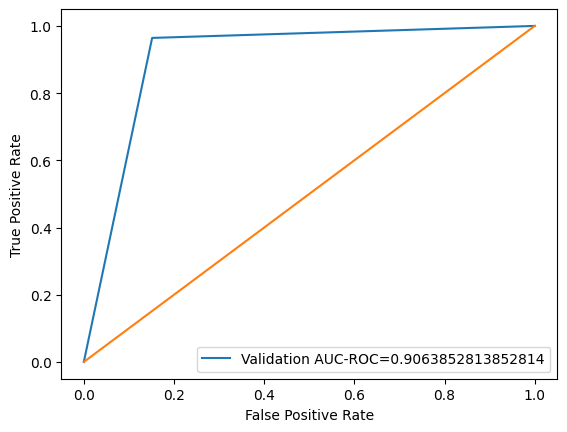

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_acc)
auc = roc_auc_score(y_test, y_pred_acc)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### hyperparam search (F1 Score)

- tuning with different preprocessing transformations

In [ ]:
model_preprocess_pipeline_std_f1 = hyperparam_tuner_f1(preprocess_pipeline_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('esti

In [ ]:
model_preprocess_pipeline_minmax_f1 = hyperparam_tuner_f1(preprocess_pipeline_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', MinMaxScaler())])),
                ('estima

In [ ]:
model_preprocess_pipeline_sep_std_f1 = hyperparam_tuner_f1(preprocess_pipeline_sep_std, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['cp_type', 'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', StandardScaler(),
                                                  ['no_of_vessels',
                                                   'st_depression', 'age'])])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_...


In [ ]:
model_preprocess_pipeline_sep_minmax_f1 = hyperparam_tuner_f1(preprocess_pipeline_sep_minmax, X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits

 Results from Randomized Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['cp_type', 'exang', 'slope',
                                                   'thallium']),
                                                 ('numerical', MinMaxScaler(),
                                                  ['no_of_vessels',
                                                   'st_depression', 'age'])])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_by...


### best model pred (F1 Score)

- Using the best estimator_  would give the best model to call predictions with since refit is set to True by default.

This is the equivalent of retraining a new model with the best_params_

In [ ]:
best_pipeline_f1, best_estimator_f1 = get_best_estimator(model_preprocess_pipeline_std_f1, model_preprocess_pipeline_minmax_f1, model_preprocess_pipeline_sep_std_f1, model_preprocess_pipeline_sep_minmax_f1)
pprint(best_estimator_f1)
best_estimator_f1

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylev...
           

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('categorical',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   ['cp_type',
                                                                    'exang',
                                                                    'slope',
                                                                    'thallium'])])),
                                 ('scaler', StandardScaler())])),
                ('estimator',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylev...
                               feature_types=None, gamma=5, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logitraw', ...))])

In [ ]:
pd.DataFrame(best_pipeline_f1.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__subsample,param_estimator__objective,param_estimator__n_estimators,param_estimator__min_child_weight,param_estimator__max_depth,param_estimator__learning_rate,...,param_estimator__max_features,param_estimator__criterion,param_estimator__estimator,param_estimator__algorithm,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
54,0.183591,0.001533,0.020375,0.000784,0.6,binary:logitraw,1000,1,3,1,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",0.817391,0.807692,0.812542,0.004849,1
78,0.304123,0.041693,0.030723,0.002085,NaN,NaN,100,NaN,3,NaN,...,log2,log_loss,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.821429,0.764706,0.793067,0.028361,2
38,0.462575,0.009362,0.020907,0.001137,NaN,NaN,400,NaN,3,0.01,...,log2,squared_error,NaN,NaN,"{'estimator__n_estimators': 400, 'estimator__m...",0.820513,0.764706,0.792609,0.027903,3
55,0.261115,0.005122,0.034034,0.000568,NaN,NaN,100,NaN,2,NaN,...,sqrt,log_loss,NaN,NaN,"{'estimator__n_estimators': 100, 'estimator__m...",0.803571,0.776699,0.790135,0.013436,4
21,0.081800,0.001534,0.017007,0.000535,NaN,NaN,50,NaN,3,0.1,...,None,squared_error,NaN,NaN,"{'estimator__n_estimators': 50, 'estimator__mi...",0.809917,0.764706,0.787312,0.022606,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,0.017022,0.000459,0.000000,0.000000,0.6,multi:softprob,250,5,4,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70
25,0.020718,0.003322,0.000000,0.000000,1.0,multi:softprob,100,1,1,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
50,0.017775,0.000954,0.000000,0.000000,1.0,multi:softmax,250,1,5,0.01,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 1.0, 'estimator__obje...",NaN,NaN,NaN,NaN,70
17,0.033728,0.006748,0.000000,0.000000,0.6,multi:softprob,50,10,2,0.001,...,NaN,NaN,NaN,NaN,"{'estimator__subsample': 0.6, 'estimator__obje...",NaN,NaN,NaN,NaN,70


In [ ]:
# get prediction
y_pred_f1 = best_estimator_f1.predict(X_test)

In [ ]:
y_pred_f1

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1])

#### Evaluation

In [ ]:
evaluate(y_test, y_pred_f1)


Accuracy: 0.9016
Precision: 0.8438
Recall: 0.9643
F1 Score: 0.9000
ROC AUC: 0.9064



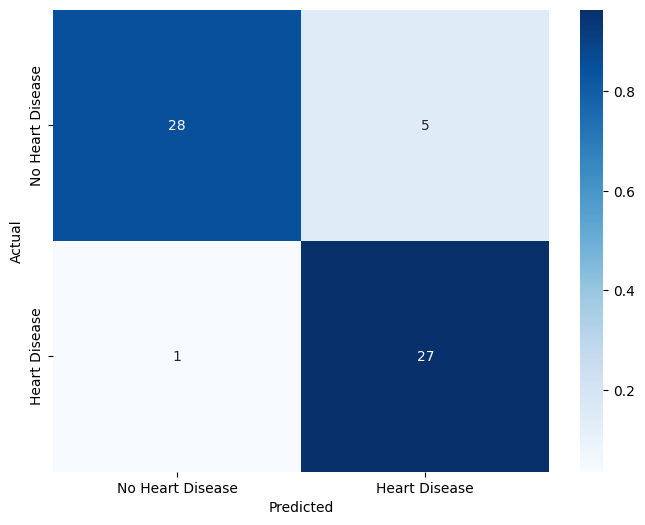

In [ ]:
confusion_matrix_plot(y_test, y_pred_f1)

- Both the accuracy and f1 hyperparam tuner gave us the same model with similar levels of performance so the same insights from the accuracy hyperparam tuner still suffice.

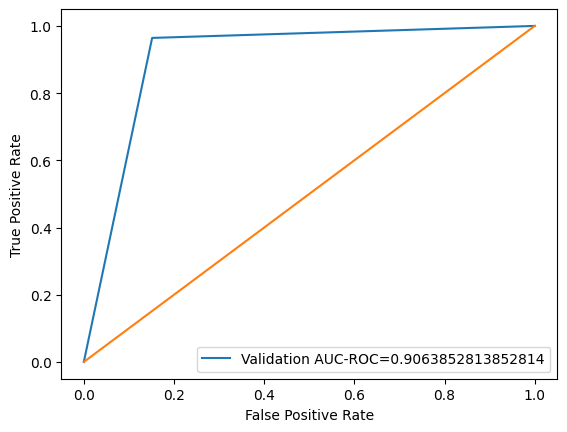

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_f1)
auc = roc_auc_score(y_test, y_pred_f1)
plt.plot(fpr, tpr, label= f"Validation AUC-ROC={str(auc)}")
x = np.linspace(0, 1, 1000)
plt.plot(x, x, linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

### Random patient predictions/diagnoses

Patient 1:

A **25** year old patient with **non-anginal** chest pain, **no occurence** of exercised induced angina, an ST depression/old peak reading of **1.1** from exercise relative to rest, an **upsloping** slope from the peak exercise ST segment, **0** major vessels colored by fluorscopy, and **normal** thallium without defect

In [ ]:
features = [25, 'non-anginal', 'False', 1.1, 'upsloping', 0, 'normal']
predict(features, best_estimator_acc, X)

Patient does not have heart disease


Patient 2:

A **75** year old patient with **asymptomatic** chest pain, **occurence** of exercised induced angina, an ST depression/old peak reading of **1.5** from exercise relative to rest, a **flat** slope from the peak exercise ST segment, **3** major vessels colored by fluorscopy, and **normal** thallium without defect

In [ ]:
features = [75, 'asymptomatic', 'True', 1.5, 'flat', 3, 'normal']
predict(features, best_estimator_acc, X)

Patient has heart disease


Patient 3:

A **40** year old patient with **asymptomatic** chest pain, **no occurence** of exercised induced angina, an ST depression/old peak reading of **0.6** from exercise relative to rest, an **upsloping** slope from the peak exercise ST segment, **1** major vessel colored by fluorscopy, and **reversable** thallium defect

In [ ]:
features = [40, 'asymptomatic', 'False', 0.6, 'upsloping', 1, 'reversable defect']
predict(features, best_estimator_acc, X)

Patient has heart disease


Patient 4:

A **5** year old patient with **typical-angina** chest pain, **occurence** of exercised induced angina, an ST depression/old peak reading of **5.7** from exercise relative to rest, a **flat** slope from the peak exercise ST segment, **2** major vessels colored by fluorscopy, and **fixed** thallium defect

In [ ]:
features = [5, 'typical-angina', 'True', 5.7, 'flat', 2, 'fixed defect']
predict(features, best_estimator_acc, X)

Patient has heart disease


Patient 5:

A **95** year old patient with **non-anginal** chest pain type, **no occurence** of exercised induced angina, an ST depression/old peak reading of **2.7** from exercise relative to rest, a **downsloping** slope from the peak exercise ST segment, **1** major vessel colored by fluorscopy, and **normal** thallium without defect

In [ ]:
features = [95, 'non-anginal', 'False', 2.7, 'downsloping', 1, 'normal']
predict(features, best_estimator_acc, X)

Patient does not have heart disease


## TO DO:
- Implement strategies to handle outliers detected via log transformations or other ways and build separate model with that data to observe performance